In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4472112, 828)
(4472112, 8)
validation
(638000, 828)
(638000, 8)
test
(493136, 828)
(493136, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/448 [..............................] - ETA: 13:00 - loss: 2.1769 - STD: 0.0614 - MAE: 0.2184

  4/448 [..............................] - ETA: 9s - loss: 2.0949 - STD: 0.0490 - MAE: 0.2167   

  7/448 [..............................] - ETA: 9s - loss: 2.0853 - STD: 0.0473 - MAE: 0.2165

 10/448 [..............................] - ETA: 9s - loss: 2.0758 - STD: 0.0439 - MAE: 0.2165

 13/448 [..............................] - ETA: 9s - loss: 2.0694 - STD: 0.0410 - MAE: 0.2165

 16/448 [>.............................] - ETA: 9s - loss: 2.0636 - STD: 0.0395 - MAE: 0.2165

 19/448 [>.............................] - ETA: 9s - loss: 2.0568 - STD: 0.0389 - MAE: 0.2163

 22/448 [>.............................] - ETA: 9s - loss: 2.0481 - STD: 0.0387 - MAE: 0.2161

 25/448 [>.............................] - ETA: 9s - loss: 2.0372 - STD: 0.0391 - MAE: 0.2157

 28/448 [>.............................] - ETA: 9s - loss: 2.0233 - STD: 0.0406 - MAE: 0.2151

 31/448 [=>............................] - ETA: 9s - loss: 2.0082 - STD: 0.0431 - MAE: 0.2144

 34/448 [=>............................] - ETA: 9s - loss: 1.9938 - STD: 0.0460 - MAE: 0.2137

 37/448 [=>............................] - ETA: 9s - loss: 1.9799 - STD: 0.0488 - MAE: 0.2129

 40/448 [=>............................] - ETA: 9s - loss: 1.9657 - STD: 0.0513 - MAE: 0.2122

 43/448 [=>............................] - ETA: 9s - loss: 1.9514 - STD: 0.0535 - MAE: 0.2115

 46/448 [==>...........................] - ETA: 9s - loss: 1.9357 - STD: 0.0556 - MAE: 0.2107

 49/448 [==>...........................] - ETA: 8s - loss: 1.9193 - STD: 0.0578 - MAE: 0.2099

 52/448 [==>...........................] - ETA: 8s - loss: 1.9016 - STD: 0.0601 - MAE: 0.2090

 55/448 [==>...........................] - ETA: 8s - loss: 1.8839 - STD: 0.0626 - MAE: 0.2080

 58/448 [==>...........................] - ETA: 8s - loss: 1.8668 - STD: 0.0654 - MAE: 0.2070

 61/448 [===>..........................] - ETA: 8s - loss: 1.8501 - STD: 0.0680 - MAE: 0.2060

 64/448 [===>..........................] - ETA: 8s - loss: 1.8337 - STD: 0.0706 - MAE: 0.2050

 67/448 [===>..........................] - ETA: 8s - loss: 1.8177 - STD: 0.0731 - MAE: 0.2040

 70/448 [===>..........................] - ETA: 8s - loss: 1.8025 - STD: 0.0755 - MAE: 0.2030

 73/448 [===>..........................] - ETA: 8s - loss: 1.7882 - STD: 0.0778 - MAE: 0.2020

 76/448 [====>.........................] - ETA: 8s - loss: 1.7741 - STD: 0.0802 - MAE: 0.2011

 79/448 [====>.........................] - ETA: 8s - loss: 1.7609 - STD: 0.0825 - MAE: 0.2002

 82/448 [====>.........................] - ETA: 8s - loss: 1.7482 - STD: 0.0846 - MAE: 0.1993

 85/448 [====>.........................] - ETA: 8s - loss: 1.7358 - STD: 0.0866 - MAE: 0.1984

 88/448 [====>.........................] - ETA: 8s - loss: 1.7238 - STD: 0.0886 - MAE: 0.1976

 91/448 [=====>........................] - ETA: 8s - loss: 1.7123 - STD: 0.0905 - MAE: 0.1967

 94/448 [=====>........................] - ETA: 7s - loss: 1.7011 - STD: 0.0924 - MAE: 0.1959

 97/448 [=====>........................] - ETA: 7s - loss: 1.6904 - STD: 0.0942 - MAE: 0.1951

100/448 [=====>........................] - ETA: 7s - loss: 1.6799 - STD: 0.0959 - MAE: 0.1943

103/448 [=====>........................] - ETA: 7s - loss: 1.6699 - STD: 0.0975 - MAE: 0.1936

106/448 [======>.......................] - ETA: 7s - loss: 1.6602 - STD: 0.0992 - MAE: 0.1928

109/448 [======>.......................] - ETA: 7s - loss: 1.6508 - STD: 0.1008 - MAE: 0.1921

112/448 [======>.......................] - ETA: 7s - loss: 1.6419 - STD: 0.1023 - MAE: 0.1914

115/448 [======>.......................] - ETA: 7s - loss: 1.6333 - STD: 0.1038 - MAE: 0.1907

118/448 [======>.......................] - ETA: 7s - loss: 1.6250 - STD: 0.1052 - MAE: 0.1901

121/448 [=======>......................] - ETA: 7s - loss: 1.6169 - STD: 0.1066 - MAE: 0.1894

124/448 [=======>......................] - ETA: 7s - loss: 1.6092 - STD: 0.1079 - MAE: 0.1888

127/448 [=======>......................] - ETA: 7s - loss: 1.6018 - STD: 0.1092 - MAE: 0.1882

130/448 [=======>......................] - ETA: 9s - loss: 1.5964 - STD: 0.1104 - MAE: 0.1876

133/448 [=======>......................] - ETA: 8s - loss: 1.5894 - STD: 0.1116 - MAE: 0.1871

136/448 [========>.....................] - ETA: 8s - loss: 1.5826 - STD: 0.1128 - MAE: 0.1865

139/448 [========>.....................] - ETA: 8s - loss: 1.5761 - STD: 0.1139 - MAE: 0.1860

142/448 [========>.....................] - ETA: 8s - loss: 1.5697 - STD: 0.1150 - MAE: 0.1855

145/448 [========>.....................] - ETA: 8s - loss: 1.5636 - STD: 0.1161 - MAE: 0.1850

148/448 [========>.....................] - ETA: 8s - loss: 1.5577 - STD: 0.1171 - MAE: 0.1845

151/448 [=========>....................] - ETA: 8s - loss: 1.5518 - STD: 0.1181 - MAE: 0.1840

154/448 [=========>....................] - ETA: 8s - loss: 1.5459 - STD: 0.1191 - MAE: 0.1835

157/448 [=========>....................] - ETA: 7s - loss: 1.5404 - STD: 0.1201 - MAE: 0.1831

160/448 [=========>....................] - ETA: 7s - loss: 1.5350 - STD: 0.1210 - MAE: 0.1826

163/448 [=========>....................] - ETA: 7s - loss: 1.5297 - STD: 0.1219 - MAE: 0.1822

166/448 [==========>...................] - ETA: 7s - loss: 1.5247 - STD: 0.1228 - MAE: 0.1817

169/448 [==========>...................] - ETA: 7s - loss: 1.5198 - STD: 0.1236 - MAE: 0.1813

172/448 [==========>...................] - ETA: 7s - loss: 1.5152 - STD: 0.1244 - MAE: 0.1809

175/448 [==========>...................] - ETA: 7s - loss: 1.5106 - STD: 0.1252 - MAE: 0.1806

178/448 [==========>...................] - ETA: 7s - loss: 1.5061 - STD: 0.1260 - MAE: 0.1802

181/448 [===========>..................] - ETA: 7s - loss: 1.5017 - STD: 0.1268 - MAE: 0.1798

184/448 [===========>..................] - ETA: 7s - loss: 1.4973 - STD: 0.1275 - MAE: 0.1794

187/448 [===========>..................] - ETA: 6s - loss: 1.4932 - STD: 0.1283 - MAE: 0.1791

190/448 [===========>..................] - ETA: 6s - loss: 1.4892 - STD: 0.1290 - MAE: 0.1787

193/448 [===========>..................] - ETA: 6s - loss: 1.4852 - STD: 0.1296 - MAE: 0.1784

196/448 [============>.................] - ETA: 6s - loss: 1.4813 - STD: 0.1303 - MAE: 0.1781

199/448 [============>.................] - ETA: 6s - loss: 1.4775 - STD: 0.1310 - MAE: 0.1777

202/448 [============>.................] - ETA: 6s - loss: 1.4737 - STD: 0.1316 - MAE: 0.1774

205/448 [============>.................] - ETA: 6s - loss: 1.4701 - STD: 0.1322 - MAE: 0.1771

208/448 [============>.................] - ETA: 6s - loss: 1.4665 - STD: 0.1329 - MAE: 0.1768

211/448 [=============>................] - ETA: 6s - loss: 1.4630 - STD: 0.1335 - MAE: 0.1765

214/448 [=============>................] - ETA: 6s - loss: 1.4594 - STD: 0.1340 - MAE: 0.1762

217/448 [=============>................] - ETA: 6s - loss: 1.4561 - STD: 0.1346 - MAE: 0.1759

220/448 [=============>................] - ETA: 5s - loss: 1.4529 - STD: 0.1352 - MAE: 0.1756

223/448 [=============>................] - ETA: 5s - loss: 1.4498 - STD: 0.1358 - MAE: 0.1754

226/448 [==============>...............] - ETA: 5s - loss: 1.4466 - STD: 0.1363 - MAE: 0.1751

229/448 [==============>...............] - ETA: 5s - loss: 1.4436 - STD: 0.1368 - MAE: 0.1748

232/448 [==============>...............] - ETA: 5s - loss: 1.4406 - STD: 0.1373 - MAE: 0.1746

235/448 [==============>...............] - ETA: 5s - loss: 1.4376 - STD: 0.1379 - MAE: 0.1743

238/448 [==============>...............] - ETA: 5s - loss: 1.4347 - STD: 0.1384 - MAE: 0.1740

241/448 [===============>..............] - ETA: 5s - loss: 1.4318 - STD: 0.1388 - MAE: 0.1738

244/448 [===============>..............] - ETA: 5s - loss: 1.4288 - STD: 0.1393 - MAE: 0.1735

247/448 [===============>..............] - ETA: 5s - loss: 1.4260 - STD: 0.1398 - MAE: 0.1733

250/448 [===============>..............] - ETA: 5s - loss: 1.4232 - STD: 0.1403 - MAE: 0.1730

253/448 [===============>..............] - ETA: 4s - loss: 1.4205 - STD: 0.1408 - MAE: 0.1728

256/448 [================>.............] - ETA: 4s - loss: 1.4178 - STD: 0.1412 - MAE: 0.1725

259/448 [================>.............] - ETA: 4s - loss: 1.4153 - STD: 0.1417 - MAE: 0.1723

262/448 [================>.............] - ETA: 4s - loss: 1.4127 - STD: 0.1421 - MAE: 0.1721

265/448 [================>.............] - ETA: 4s - loss: 1.4102 - STD: 0.1425 - MAE: 0.1719

268/448 [================>.............] - ETA: 4s - loss: 1.4078 - STD: 0.1429 - MAE: 0.1717

271/448 [=================>............] - ETA: 4s - loss: 1.4053 - STD: 0.1433 - MAE: 0.1714

274/448 [=================>............] - ETA: 4s - loss: 1.4029 - STD: 0.1437 - MAE: 0.1712

277/448 [=================>............] - ETA: 4s - loss: 1.4004 - STD: 0.1441 - MAE: 0.1710

280/448 [=================>............] - ETA: 4s - loss: 1.3981 - STD: 0.1445 - MAE: 0.1708

283/448 [=================>............] - ETA: 4s - loss: 1.3957 - STD: 0.1449 - MAE: 0.1706

286/448 [==================>...........] - ETA: 4s - loss: 1.3936 - STD: 0.1453 - MAE: 0.1704

289/448 [==================>...........] - ETA: 3s - loss: 1.3915 - STD: 0.1457 - MAE: 0.1702

292/448 [==================>...........] - ETA: 3s - loss: 1.3894 - STD: 0.1460 - MAE: 0.1700

295/448 [==================>...........] - ETA: 3s - loss: 1.3872 - STD: 0.1464 - MAE: 0.1698

298/448 [==================>...........] - ETA: 3s - loss: 1.3850 - STD: 0.1468 - MAE: 0.1696

301/448 [===================>..........] - ETA: 3s - loss: 1.3830 - STD: 0.1471 - MAE: 0.1695

304/448 [===================>..........] - ETA: 3s - loss: 1.3810 - STD: 0.1475 - MAE: 0.1693

307/448 [===================>..........] - ETA: 3s - loss: 1.3791 - STD: 0.1478 - MAE: 0.1691

310/448 [===================>..........] - ETA: 3s - loss: 1.3771 - STD: 0.1482 - MAE: 0.1689

313/448 [===================>..........] - ETA: 3s - loss: 1.3751 - STD: 0.1485 - MAE: 0.1687

316/448 [====================>.........] - ETA: 3s - loss: 1.3731 - STD: 0.1488 - MAE: 0.1686

319/448 [====================>.........] - ETA: 3s - loss: 1.3712 - STD: 0.1492 - MAE: 0.1684

322/448 [====================>.........] - ETA: 3s - loss: 1.3693 - STD: 0.1495 - MAE: 0.1682

325/448 [====================>.........] - ETA: 3s - loss: 1.3675 - STD: 0.1498 - MAE: 0.1680

328/448 [====================>.........] - ETA: 2s - loss: 1.3657 - STD: 0.1501 - MAE: 0.1679

331/448 [=====================>........] - ETA: 2s - loss: 1.3638 - STD: 0.1504 - MAE: 0.1677

334/448 [=====================>........] - ETA: 2s - loss: 1.3620 - STD: 0.1507 - MAE: 0.1675

337/448 [=====================>........] - ETA: 2s - loss: 1.3601 - STD: 0.1510 - MAE: 0.1674

340/448 [=====================>........] - ETA: 2s - loss: 1.3583 - STD: 0.1513 - MAE: 0.1672

343/448 [=====================>........] - ETA: 2s - loss: 1.3566 - STD: 0.1516 - MAE: 0.1671

346/448 [======================>.......] - ETA: 2s - loss: 1.3549 - STD: 0.1519 - MAE: 0.1669

349/448 [======================>.......] - ETA: 2s - loss: 1.3532 - STD: 0.1522 - MAE: 0.1668

352/448 [======================>.......] - ETA: 2s - loss: 1.3515 - STD: 0.1525 - MAE: 0.1666

355/448 [======================>.......] - ETA: 2s - loss: 1.3499 - STD: 0.1527 - MAE: 0.1664

358/448 [======================>.......] - ETA: 2s - loss: 1.3482 - STD: 0.1530 - MAE: 0.1663

361/448 [=======================>......] - ETA: 2s - loss: 1.3466 - STD: 0.1533 - MAE: 0.1661

364/448 [=======================>......] - ETA: 2s - loss: 1.3451 - STD: 0.1536 - MAE: 0.1660

367/448 [=======================>......] - ETA: 1s - loss: 1.3434 - STD: 0.1538 - MAE: 0.1659

370/448 [=======================>......] - ETA: 1s - loss: 1.3419 - STD: 0.1541 - MAE: 0.1657

373/448 [=======================>......] - ETA: 1s - loss: 1.3403 - STD: 0.1543 - MAE: 0.1656

376/448 [========================>.....] - ETA: 1s - loss: 1.3389 - STD: 0.1546 - MAE: 0.1654

379/448 [========================>.....] - ETA: 1s - loss: 1.3373 - STD: 0.1549 - MAE: 0.1653

382/448 [========================>.....] - ETA: 1s - loss: 1.3358 - STD: 0.1551 - MAE: 0.1651

385/448 [========================>.....] - ETA: 1s - loss: 1.3344 - STD: 0.1554 - MAE: 0.1650

388/448 [========================>.....] - ETA: 1s - loss: 1.3331 - STD: 0.1556 - MAE: 0.1649

391/448 [=========================>....] - ETA: 1s - loss: 1.3318 - STD: 0.1558 - MAE: 0.1648

394/448 [=========================>....] - ETA: 1s - loss: 1.3304 - STD: 0.1561 - MAE: 0.1646

397/448 [=========================>....] - ETA: 1s - loss: 1.3290 - STD: 0.1563 - MAE: 0.1645

400/448 [=========================>....] - ETA: 1s - loss: 1.3275 - STD: 0.1565 - MAE: 0.1644

403/448 [=========================>....] - ETA: 1s - loss: 1.3262 - STD: 0.1568 - MAE: 0.1642

406/448 [==========================>...] - ETA: 1s - loss: 1.3248 - STD: 0.1570 - MAE: 0.1641

409/448 [==========================>...] - ETA: 0s - loss: 1.3233 - STD: 0.1572 - MAE: 0.1640

412/448 [==========================>...] - ETA: 0s - loss: 1.3219 - STD: 0.1574 - MAE: 0.1639

415/448 [==========================>...] - ETA: 0s - loss: 1.3205 - STD: 0.1577 - MAE: 0.1637

418/448 [==========================>...] - ETA: 0s - loss: 1.3192 - STD: 0.1579 - MAE: 0.1636

421/448 [===========================>..] - ETA: 0s - loss: 1.3179 - STD: 0.1581 - MAE: 0.1635

424/448 [===========================>..] - ETA: 0s - loss: 1.3165 - STD: 0.1583 - MAE: 0.1634

427/448 [===========================>..] - ETA: 0s - loss: 1.3151 - STD: 0.1585 - MAE: 0.1632

430/448 [===========================>..] - ETA: 0s - loss: 1.3138 - STD: 0.1587 - MAE: 0.1631

433/448 [===========================>..] - ETA: 0s - loss: 1.3125 - STD: 0.1590 - MAE: 0.1630

436/448 [============================>.] - ETA: 0s - loss: 1.3113 - STD: 0.1592 - MAE: 0.1629

439/448 [============================>.] - ETA: 0s - loss: 1.3100 - STD: 0.1594 - MAE: 0.1628

442/448 [============================>.] - ETA: 0s - loss: 1.3090 - STD: 0.1596 - MAE: 0.1626

445/448 [============================>.] - ETA: 0s - loss: 1.3080 - STD: 0.1598 - MAE: 0.1625

448/448 [==============================] - ETA: 0s - loss: 1.3069 - STD: 0.1600 - MAE: 0.1624

448/448 [==============================] - 14s 28ms/step - loss: 1.3069 - STD: 0.1600 - MAE: 0.1624 - val_loss: 1.1100 - val_STD: 0.1864 - val_MAE: 0.1451


Epoch 2/10000


  1/448 [..............................] - ETA: 23s - loss: 1.1541 - STD: 0.1878 - MAE: 0.1473

  4/448 [..............................] - ETA: 10s - loss: 1.1494 - STD: 0.1891 - MAE: 0.1467

  7/448 [..............................] - ETA: 10s - loss: 1.1466 - STD: 0.1897 - MAE: 0.1463

 10/448 [..............................] - ETA: 9s - loss: 1.1490 - STD: 0.1898 - MAE: 0.1464 

 13/448 [..............................] - ETA: 9s - loss: 1.1439 - STD: 0.1896 - MAE: 0.1463

 16/448 [>.............................] - ETA: 9s - loss: 1.1416 - STD: 0.1894 - MAE: 0.1462

 19/448 [>.............................] - ETA: 9s - loss: 1.1370 - STD: 0.1897 - MAE: 0.1459

 22/448 [>.............................] - ETA: 9s - loss: 1.1341 - STD: 0.1900 - MAE: 0.1457

 25/448 [>.............................] - ETA: 9s - loss: 1.1311 - STD: 0.1901 - MAE: 0.1454

 28/448 [>.............................] - ETA: 9s - loss: 1.1283 - STD: 0.1902 - MAE: 0.1452

 31/448 [=>............................] - ETA: 9s - loss: 1.1270 - STD: 0.1903 - MAE: 0.1451

 34/448 [=>............................] - ETA: 9s - loss: 1.1255 - STD: 0.1904 - MAE: 0.1450

 37/448 [=>............................] - ETA: 9s - loss: 1.1239 - STD: 0.1905 - MAE: 0.1449

 40/448 [=>............................] - ETA: 9s - loss: 1.1226 - STD: 0.1907 - MAE: 0.1448

 43/448 [=>............................] - ETA: 9s - loss: 1.1216 - STD: 0.1907 - MAE: 0.1447

 46/448 [==>...........................] - ETA: 9s - loss: 1.1207 - STD: 0.1908 - MAE: 0.1446

 49/448 [==>...........................] - ETA: 9s - loss: 1.1194 - STD: 0.1909 - MAE: 0.1445

 52/448 [==>...........................] - ETA: 8s - loss: 1.1187 - STD: 0.1910 - MAE: 0.1444

 55/448 [==>...........................] - ETA: 8s - loss: 1.1177 - STD: 0.1911 - MAE: 0.1443

 58/448 [==>...........................] - ETA: 8s - loss: 1.1176 - STD: 0.1912 - MAE: 0.1443

 61/448 [===>..........................] - ETA: 8s - loss: 1.1172 - STD: 0.1913 - MAE: 0.1442

 64/448 [===>..........................] - ETA: 8s - loss: 1.1162 - STD: 0.1914 - MAE: 0.1441

 67/448 [===>..........................] - ETA: 8s - loss: 1.1156 - STD: 0.1915 - MAE: 0.1441

 70/448 [===>..........................] - ETA: 8s - loss: 1.1150 - STD: 0.1916 - MAE: 0.1440

 73/448 [===>..........................] - ETA: 8s - loss: 1.1141 - STD: 0.1916 - MAE: 0.1439

 76/448 [====>.........................] - ETA: 8s - loss: 1.1131 - STD: 0.1917 - MAE: 0.1438

 79/448 [====>.........................] - ETA: 8s - loss: 1.1122 - STD: 0.1919 - MAE: 0.1437

 82/448 [====>.........................] - ETA: 8s - loss: 1.1115 - STD: 0.1920 - MAE: 0.1437

 85/448 [====>.........................] - ETA: 8s - loss: 1.1115 - STD: 0.1920 - MAE: 0.1436

 88/448 [====>.........................] - ETA: 8s - loss: 1.1109 - STD: 0.1921 - MAE: 0.1436

 91/448 [=====>........................] - ETA: 8s - loss: 1.1106 - STD: 0.1922 - MAE: 0.1435

 94/448 [=====>........................] - ETA: 7s - loss: 1.1099 - STD: 0.1922 - MAE: 0.1435

 97/448 [=====>........................] - ETA: 7s - loss: 1.1091 - STD: 0.1923 - MAE: 0.1434

100/448 [=====>........................] - ETA: 7s - loss: 1.1086 - STD: 0.1924 - MAE: 0.1433

103/448 [=====>........................] - ETA: 7s - loss: 1.1091 - STD: 0.1925 - MAE: 0.1433

106/448 [======>.......................] - ETA: 7s - loss: 1.1092 - STD: 0.1925 - MAE: 0.1433

109/448 [======>.......................] - ETA: 7s - loss: 1.1090 - STD: 0.1926 - MAE: 0.1433

112/448 [======>.......................] - ETA: 7s - loss: 1.1087 - STD: 0.1927 - MAE: 0.1433

115/448 [======>.......................] - ETA: 7s - loss: 1.1082 - STD: 0.1927 - MAE: 0.1432

118/448 [======>.......................] - ETA: 7s - loss: 1.1080 - STD: 0.1928 - MAE: 0.1432

121/448 [=======>......................] - ETA: 7s - loss: 1.1076 - STD: 0.1928 - MAE: 0.1431

124/448 [=======>......................] - ETA: 7s - loss: 1.1072 - STD: 0.1929 - MAE: 0.1431

127/448 [=======>......................] - ETA: 7s - loss: 1.1069 - STD: 0.1930 - MAE: 0.1430

130/448 [=======>......................] - ETA: 7s - loss: 1.1065 - STD: 0.1931 - MAE: 0.1430

133/448 [=======>......................] - ETA: 7s - loss: 1.1061 - STD: 0.1931 - MAE: 0.1429

136/448 [========>.....................] - ETA: 7s - loss: 1.1059 - STD: 0.1931 - MAE: 0.1429

139/448 [========>.....................] - ETA: 6s - loss: 1.1054 - STD: 0.1932 - MAE: 0.1429

142/448 [========>.....................] - ETA: 6s - loss: 1.1049 - STD: 0.1932 - MAE: 0.1428

145/448 [========>.....................] - ETA: 6s - loss: 1.1045 - STD: 0.1933 - MAE: 0.1428

148/448 [========>.....................] - ETA: 6s - loss: 1.1045 - STD: 0.1933 - MAE: 0.1428

151/448 [=========>....................] - ETA: 6s - loss: 1.1048 - STD: 0.1934 - MAE: 0.1428

154/448 [=========>....................] - ETA: 6s - loss: 1.1045 - STD: 0.1934 - MAE: 0.1427

157/448 [=========>....................] - ETA: 6s - loss: 1.1041 - STD: 0.1935 - MAE: 0.1427

160/448 [=========>....................] - ETA: 6s - loss: 1.1037 - STD: 0.1935 - MAE: 0.1427

163/448 [=========>....................] - ETA: 6s - loss: 1.1035 - STD: 0.1936 - MAE: 0.1426

166/448 [==========>...................] - ETA: 6s - loss: 1.1030 - STD: 0.1936 - MAE: 0.1426

169/448 [==========>...................] - ETA: 6s - loss: 1.1025 - STD: 0.1937 - MAE: 0.1426

172/448 [==========>...................] - ETA: 6s - loss: 1.1021 - STD: 0.1938 - MAE: 0.1425

175/448 [==========>...................] - ETA: 6s - loss: 1.1019 - STD: 0.1938 - MAE: 0.1425

178/448 [==========>...................] - ETA: 6s - loss: 1.1013 - STD: 0.1939 - MAE: 0.1424

181/448 [===========>..................] - ETA: 5s - loss: 1.1009 - STD: 0.1939 - MAE: 0.1424

184/448 [===========>..................] - ETA: 5s - loss: 1.1004 - STD: 0.1940 - MAE: 0.1423

187/448 [===========>..................] - ETA: 5s - loss: 1.1000 - STD: 0.1940 - MAE: 0.1423

190/448 [===========>..................] - ETA: 5s - loss: 1.0997 - STD: 0.1941 - MAE: 0.1422

193/448 [===========>..................] - ETA: 5s - loss: 1.0995 - STD: 0.1941 - MAE: 0.1422

196/448 [============>.................] - ETA: 5s - loss: 1.0995 - STD: 0.1942 - MAE: 0.1422

199/448 [============>.................] - ETA: 5s - loss: 1.0992 - STD: 0.1942 - MAE: 0.1421

202/448 [============>.................] - ETA: 5s - loss: 1.0990 - STD: 0.1943 - MAE: 0.1421

205/448 [============>.................] - ETA: 5s - loss: 1.0986 - STD: 0.1943 - MAE: 0.1421

208/448 [============>.................] - ETA: 5s - loss: 1.0983 - STD: 0.1944 - MAE: 0.1420

211/448 [=============>................] - ETA: 5s - loss: 1.0980 - STD: 0.1944 - MAE: 0.1420

214/448 [=============>................] - ETA: 5s - loss: 1.0977 - STD: 0.1945 - MAE: 0.1420

217/448 [=============>................] - ETA: 5s - loss: 1.0973 - STD: 0.1945 - MAE: 0.1419

220/448 [=============>................] - ETA: 5s - loss: 1.0969 - STD: 0.1946 - MAE: 0.1419

223/448 [=============>................] - ETA: 5s - loss: 1.0969 - STD: 0.1946 - MAE: 0.1419

226/448 [==============>...............] - ETA: 4s - loss: 1.0966 - STD: 0.1947 - MAE: 0.1418

229/448 [==============>...............] - ETA: 4s - loss: 1.0961 - STD: 0.1947 - MAE: 0.1418

232/448 [==============>...............] - ETA: 4s - loss: 1.0959 - STD: 0.1948 - MAE: 0.1418

235/448 [==============>...............] - ETA: 4s - loss: 1.0956 - STD: 0.1948 - MAE: 0.1417

238/448 [==============>...............] - ETA: 4s - loss: 1.0955 - STD: 0.1948 - MAE: 0.1417

241/448 [===============>..............] - ETA: 4s - loss: 1.0952 - STD: 0.1949 - MAE: 0.1417

244/448 [===============>..............] - ETA: 4s - loss: 1.0951 - STD: 0.1950 - MAE: 0.1416

247/448 [===============>..............] - ETA: 4s - loss: 1.0949 - STD: 0.1950 - MAE: 0.1416

250/448 [===============>..............] - ETA: 4s - loss: 1.0945 - STD: 0.1950 - MAE: 0.1416

253/448 [===============>..............] - ETA: 4s - loss: 1.0941 - STD: 0.1951 - MAE: 0.1415

256/448 [================>.............] - ETA: 4s - loss: 1.0938 - STD: 0.1951 - MAE: 0.1415

259/448 [================>.............] - ETA: 4s - loss: 1.0933 - STD: 0.1952 - MAE: 0.1414

262/448 [================>.............] - ETA: 4s - loss: 1.0929 - STD: 0.1952 - MAE: 0.1414

265/448 [================>.............] - ETA: 4s - loss: 1.0926 - STD: 0.1953 - MAE: 0.1414

268/448 [================>.............] - ETA: 4s - loss: 1.0922 - STD: 0.1953 - MAE: 0.1413

271/448 [=================>............] - ETA: 3s - loss: 1.0921 - STD: 0.1954 - MAE: 0.1413

274/448 [=================>............] - ETA: 3s - loss: 1.0919 - STD: 0.1954 - MAE: 0.1413

277/448 [=================>............] - ETA: 3s - loss: 1.0918 - STD: 0.1954 - MAE: 0.1413

280/448 [=================>............] - ETA: 3s - loss: 1.0915 - STD: 0.1955 - MAE: 0.1412

283/448 [=================>............] - ETA: 3s - loss: 1.0913 - STD: 0.1955 - MAE: 0.1412

286/448 [==================>...........] - ETA: 3s - loss: 1.0910 - STD: 0.1956 - MAE: 0.1412

289/448 [==================>...........] - ETA: 3s - loss: 1.0908 - STD: 0.1956 - MAE: 0.1411

292/448 [==================>...........] - ETA: 3s - loss: 1.0908 - STD: 0.1957 - MAE: 0.1411

295/448 [==================>...........] - ETA: 3s - loss: 1.0908 - STD: 0.1957 - MAE: 0.1411

298/448 [==================>...........] - ETA: 3s - loss: 1.0906 - STD: 0.1957 - MAE: 0.1411

301/448 [===================>..........] - ETA: 3s - loss: 1.0905 - STD: 0.1958 - MAE: 0.1411

304/448 [===================>..........] - ETA: 3s - loss: 1.0904 - STD: 0.1958 - MAE: 0.1410

307/448 [===================>..........] - ETA: 3s - loss: 1.0902 - STD: 0.1958 - MAE: 0.1410

310/448 [===================>..........] - ETA: 3s - loss: 1.0899 - STD: 0.1959 - MAE: 0.1410

313/448 [===================>..........] - ETA: 3s - loss: 1.0897 - STD: 0.1959 - MAE: 0.1410

316/448 [====================>.........] - ETA: 2s - loss: 1.0894 - STD: 0.1960 - MAE: 0.1409

319/448 [====================>.........] - ETA: 2s - loss: 1.0892 - STD: 0.1960 - MAE: 0.1409

322/448 [====================>.........] - ETA: 2s - loss: 1.0888 - STD: 0.1960 - MAE: 0.1409

325/448 [====================>.........] - ETA: 2s - loss: 1.0886 - STD: 0.1961 - MAE: 0.1408

328/448 [====================>.........] - ETA: 2s - loss: 1.0883 - STD: 0.1961 - MAE: 0.1408

331/448 [=====================>........] - ETA: 2s - loss: 1.0879 - STD: 0.1961 - MAE: 0.1408

334/448 [=====================>........] - ETA: 2s - loss: 1.0877 - STD: 0.1962 - MAE: 0.1408

337/448 [=====================>........] - ETA: 2s - loss: 1.0875 - STD: 0.1962 - MAE: 0.1407

340/448 [=====================>........] - ETA: 2s - loss: 1.0872 - STD: 0.1962 - MAE: 0.1407

343/448 [=====================>........] - ETA: 2s - loss: 1.0869 - STD: 0.1963 - MAE: 0.1407

346/448 [======================>.......] - ETA: 2s - loss: 1.0866 - STD: 0.1963 - MAE: 0.1406

349/448 [======================>.......] - ETA: 2s - loss: 1.0863 - STD: 0.1963 - MAE: 0.1406

352/448 [======================>.......] - ETA: 2s - loss: 1.0860 - STD: 0.1964 - MAE: 0.1406

355/448 [======================>.......] - ETA: 2s - loss: 1.0858 - STD: 0.1964 - MAE: 0.1405

358/448 [======================>.......] - ETA: 2s - loss: 1.0854 - STD: 0.1965 - MAE: 0.1405

361/448 [=======================>......] - ETA: 1s - loss: 1.0851 - STD: 0.1965 - MAE: 0.1405

364/448 [=======================>......] - ETA: 1s - loss: 1.0848 - STD: 0.1965 - MAE: 0.1404

367/448 [=======================>......] - ETA: 1s - loss: 1.0844 - STD: 0.1966 - MAE: 0.1404

370/448 [=======================>......] - ETA: 1s - loss: 1.0840 - STD: 0.1966 - MAE: 0.1404

373/448 [=======================>......] - ETA: 1s - loss: 1.0836 - STD: 0.1967 - MAE: 0.1403

376/448 [========================>.....] - ETA: 1s - loss: 1.0833 - STD: 0.1967 - MAE: 0.1403

379/448 [========================>.....] - ETA: 1s - loss: 1.0831 - STD: 0.1968 - MAE: 0.1403

382/448 [========================>.....] - ETA: 1s - loss: 1.0828 - STD: 0.1968 - MAE: 0.1402

385/448 [========================>.....] - ETA: 1s - loss: 1.0826 - STD: 0.1968 - MAE: 0.1402

388/448 [========================>.....] - ETA: 1s - loss: 1.0823 - STD: 0.1969 - MAE: 0.1402

391/448 [=========================>....] - ETA: 1s - loss: 1.0821 - STD: 0.1969 - MAE: 0.1401

394/448 [=========================>....] - ETA: 1s - loss: 1.0819 - STD: 0.1970 - MAE: 0.1401

397/448 [=========================>....] - ETA: 1s - loss: 1.0817 - STD: 0.1970 - MAE: 0.1401

400/448 [=========================>....] - ETA: 1s - loss: 1.0816 - STD: 0.1970 - MAE: 0.1401

403/448 [=========================>....] - ETA: 1s - loss: 1.0814 - STD: 0.1971 - MAE: 0.1400

406/448 [==========================>...] - ETA: 0s - loss: 1.0812 - STD: 0.1971 - MAE: 0.1400

409/448 [==========================>...] - ETA: 0s - loss: 1.0810 - STD: 0.1971 - MAE: 0.1400

412/448 [==========================>...] - ETA: 0s - loss: 1.0807 - STD: 0.1972 - MAE: 0.1400

415/448 [==========================>...] - ETA: 0s - loss: 1.0804 - STD: 0.1972 - MAE: 0.1399

418/448 [==========================>...] - ETA: 0s - loss: 1.0801 - STD: 0.1972 - MAE: 0.1399

421/448 [===========================>..] - ETA: 0s - loss: 1.0798 - STD: 0.1973 - MAE: 0.1399

424/448 [===========================>..] - ETA: 0s - loss: 1.0794 - STD: 0.1973 - MAE: 0.1398

427/448 [===========================>..] - ETA: 0s - loss: 1.0791 - STD: 0.1973 - MAE: 0.1398

430/448 [===========================>..] - ETA: 0s - loss: 1.0788 - STD: 0.1974 - MAE: 0.1398

433/448 [===========================>..] - ETA: 0s - loss: 1.0785 - STD: 0.1974 - MAE: 0.1397

436/448 [============================>.] - ETA: 0s - loss: 1.0782 - STD: 0.1975 - MAE: 0.1397

439/448 [============================>.] - ETA: 0s - loss: 1.0780 - STD: 0.1975 - MAE: 0.1397

442/448 [============================>.] - ETA: 0s - loss: 1.0776 - STD: 0.1975 - MAE: 0.1396

445/448 [============================>.] - ETA: 0s - loss: 1.0773 - STD: 0.1976 - MAE: 0.1396

448/448 [==============================] - ETA: 0s - loss: 1.0769 - STD: 0.1976 - MAE: 0.1396

448/448 [==============================] - 11s 25ms/step - loss: 1.0769 - STD: 0.1976 - MAE: 0.1396 - val_loss: 1.0191 - val_STD: 0.2032 - val_MAE: 0.1338


Epoch 3/10000


  1/448 [..............................] - ETA: 25s - loss: 1.0453 - STD: 0.2042 - MAE: 0.1353

  3/448 [..............................] - ETA: 11s - loss: 1.0359 - STD: 0.2042 - MAE: 0.1348

  6/448 [..............................] - ETA: 10s - loss: 1.0327 - STD: 0.2042 - MAE: 0.1344

  9/448 [..............................] - ETA: 10s - loss: 1.0332 - STD: 0.2043 - MAE: 0.1343

 12/448 [..............................] - ETA: 10s - loss: 1.0432 - STD: 0.2039 - MAE: 0.1350

 15/448 [>.............................] - ETA: 9s - loss: 1.0422 - STD: 0.2038 - MAE: 0.1351 

 18/448 [>.............................] - ETA: 9s - loss: 1.0410 - STD: 0.2039 - MAE: 0.1350

 21/448 [>.............................] - ETA: 9s - loss: 1.0400 - STD: 0.2040 - MAE: 0.1349

 24/448 [>.............................] - ETA: 9s - loss: 1.0397 - STD: 0.2040 - MAE: 0.1349

 27/448 [>.............................] - ETA: 9s - loss: 1.0387 - STD: 0.2039 - MAE: 0.1349

 30/448 [=>............................] - ETA: 9s - loss: 1.0375 - STD: 0.2039 - MAE: 0.1348

 33/448 [=>............................] - ETA: 9s - loss: 1.0369 - STD: 0.2040 - MAE: 0.1348

 36/448 [=>............................] - ETA: 9s - loss: 1.0364 - STD: 0.2041 - MAE: 0.1347

 39/448 [=>............................] - ETA: 9s - loss: 1.0363 - STD: 0.2040 - MAE: 0.1347

 42/448 [=>............................] - ETA: 9s - loss: 1.0351 - STD: 0.2040 - MAE: 0.1347

 45/448 [==>...........................] - ETA: 9s - loss: 1.0340 - STD: 0.2040 - MAE: 0.1346

 48/448 [==>...........................] - ETA: 9s - loss: 1.0333 - STD: 0.2040 - MAE: 0.1346

 51/448 [==>...........................] - ETA: 9s - loss: 1.0323 - STD: 0.2040 - MAE: 0.1345

 54/448 [==>...........................] - ETA: 8s - loss: 1.0325 - STD: 0.2040 - MAE: 0.1345

 57/448 [==>...........................] - ETA: 8s - loss: 1.0320 - STD: 0.2041 - MAE: 0.1345

 60/448 [===>..........................] - ETA: 8s - loss: 1.0316 - STD: 0.2041 - MAE: 0.1344

 63/448 [===>..........................] - ETA: 8s - loss: 1.0308 - STD: 0.2041 - MAE: 0.1344

 66/448 [===>..........................] - ETA: 8s - loss: 1.0305 - STD: 0.2041 - MAE: 0.1343

 69/448 [===>..........................] - ETA: 8s - loss: 1.0312 - STD: 0.2041 - MAE: 0.1344

 72/448 [===>..........................] - ETA: 8s - loss: 1.0319 - STD: 0.2043 - MAE: 0.1344

 75/448 [====>.........................] - ETA: 8s - loss: 1.0311 - STD: 0.2043 - MAE: 0.1343

 78/448 [====>.........................] - ETA: 8s - loss: 1.0310 - STD: 0.2043 - MAE: 0.1343

 81/448 [====>.........................] - ETA: 8s - loss: 1.0306 - STD: 0.2043 - MAE: 0.1343

 84/448 [====>.........................] - ETA: 8s - loss: 1.0304 - STD: 0.2044 - MAE: 0.1342

 87/448 [====>.........................] - ETA: 8s - loss: 1.0305 - STD: 0.2044 - MAE: 0.1342

 90/448 [=====>........................] - ETA: 8s - loss: 1.0303 - STD: 0.2045 - MAE: 0.1342

 93/448 [=====>........................] - ETA: 8s - loss: 1.0298 - STD: 0.2045 - MAE: 0.1342

 96/448 [=====>........................] - ETA: 7s - loss: 1.0295 - STD: 0.2045 - MAE: 0.1341

 99/448 [=====>........................] - ETA: 7s - loss: 1.0291 - STD: 0.2046 - MAE: 0.1341

102/448 [=====>........................] - ETA: 7s - loss: 1.0287 - STD: 0.2046 - MAE: 0.1340

105/448 [======>.......................] - ETA: 7s - loss: 1.0290 - STD: 0.2046 - MAE: 0.1340

108/448 [======>.......................] - ETA: 7s - loss: 1.0288 - STD: 0.2047 - MAE: 0.1340

111/448 [======>.......................] - ETA: 7s - loss: 1.0284 - STD: 0.2047 - MAE: 0.1340

114/448 [======>.......................] - ETA: 7s - loss: 1.0278 - STD: 0.2047 - MAE: 0.1340

117/448 [======>.......................] - ETA: 7s - loss: 1.0273 - STD: 0.2047 - MAE: 0.1339

120/448 [=======>......................] - ETA: 7s - loss: 1.0274 - STD: 0.2047 - MAE: 0.1339

123/448 [=======>......................] - ETA: 7s - loss: 1.0274 - STD: 0.2048 - MAE: 0.1339

126/448 [=======>......................] - ETA: 7s - loss: 1.0275 - STD: 0.2048 - MAE: 0.1339

129/448 [=======>......................] - ETA: 7s - loss: 1.0272 - STD: 0.2048 - MAE: 0.1339

132/448 [=======>......................] - ETA: 7s - loss: 1.0269 - STD: 0.2049 - MAE: 0.1338

135/448 [========>.....................] - ETA: 7s - loss: 1.0267 - STD: 0.2049 - MAE: 0.1338

138/448 [========>.....................] - ETA: 7s - loss: 1.0264 - STD: 0.2049 - MAE: 0.1338

141/448 [========>.....................] - ETA: 6s - loss: 1.0260 - STD: 0.2050 - MAE: 0.1337

144/448 [========>.....................] - ETA: 6s - loss: 1.0256 - STD: 0.2050 - MAE: 0.1337

147/448 [========>.....................] - ETA: 6s - loss: 1.0259 - STD: 0.2050 - MAE: 0.1337

150/448 [=========>....................] - ETA: 6s - loss: 1.0275 - STD: 0.2050 - MAE: 0.1338

153/448 [=========>....................] - ETA: 6s - loss: 1.0276 - STD: 0.2051 - MAE: 0.1338

156/448 [=========>....................] - ETA: 6s - loss: 1.0276 - STD: 0.2051 - MAE: 0.1338

159/448 [=========>....................] - ETA: 6s - loss: 1.0277 - STD: 0.2051 - MAE: 0.1338

162/448 [=========>....................] - ETA: 6s - loss: 1.0276 - STD: 0.2051 - MAE: 0.1337

165/448 [==========>...................] - ETA: 6s - loss: 1.0275 - STD: 0.2051 - MAE: 0.1337

168/448 [==========>...................] - ETA: 6s - loss: 1.0274 - STD: 0.2051 - MAE: 0.1337

171/448 [==========>...................] - ETA: 6s - loss: 1.0272 - STD: 0.2052 - MAE: 0.1337

174/448 [==========>...................] - ETA: 6s - loss: 1.0272 - STD: 0.2052 - MAE: 0.1337

177/448 [==========>...................] - ETA: 6s - loss: 1.0271 - STD: 0.2052 - MAE: 0.1337

180/448 [===========>..................] - ETA: 6s - loss: 1.0270 - STD: 0.2052 - MAE: 0.1337

183/448 [===========>..................] - ETA: 5s - loss: 1.0271 - STD: 0.2052 - MAE: 0.1337

186/448 [===========>..................] - ETA: 5s - loss: 1.0269 - STD: 0.2052 - MAE: 0.1337

189/448 [===========>..................] - ETA: 5s - loss: 1.0268 - STD: 0.2052 - MAE: 0.1337

192/448 [===========>..................] - ETA: 5s - loss: 1.0267 - STD: 0.2053 - MAE: 0.1337

195/448 [============>.................] - ETA: 5s - loss: 1.0266 - STD: 0.2053 - MAE: 0.1336

198/448 [============>.................] - ETA: 5s - loss: 1.0263 - STD: 0.2053 - MAE: 0.1336

201/448 [============>.................] - ETA: 5s - loss: 1.0260 - STD: 0.2053 - MAE: 0.1336

204/448 [============>.................] - ETA: 5s - loss: 1.0258 - STD: 0.2053 - MAE: 0.1336

207/448 [============>.................] - ETA: 5s - loss: 1.0254 - STD: 0.2054 - MAE: 0.1335

210/448 [=============>................] - ETA: 5s - loss: 1.0251 - STD: 0.2054 - MAE: 0.1335

213/448 [=============>................] - ETA: 5s - loss: 1.0247 - STD: 0.2054 - MAE: 0.1335

216/448 [=============>................] - ETA: 5s - loss: 1.0243 - STD: 0.2055 - MAE: 0.1334

219/448 [=============>................] - ETA: 5s - loss: 1.0241 - STD: 0.2055 - MAE: 0.1334

222/448 [=============>................] - ETA: 5s - loss: 1.0239 - STD: 0.2055 - MAE: 0.1334

225/448 [==============>...............] - ETA: 5s - loss: 1.0236 - STD: 0.2056 - MAE: 0.1333

228/448 [==============>...............] - ETA: 4s - loss: 1.0234 - STD: 0.2056 - MAE: 0.1333

231/448 [==============>...............] - ETA: 4s - loss: 1.0233 - STD: 0.2056 - MAE: 0.1333

234/448 [==============>...............] - ETA: 4s - loss: 1.0230 - STD: 0.2056 - MAE: 0.1333

237/448 [==============>...............] - ETA: 4s - loss: 1.0228 - STD: 0.2057 - MAE: 0.1333

240/448 [===============>..............] - ETA: 4s - loss: 1.0225 - STD: 0.2057 - MAE: 0.1332

243/448 [===============>..............] - ETA: 4s - loss: 1.0223 - STD: 0.2057 - MAE: 0.1332

246/448 [===============>..............] - ETA: 4s - loss: 1.0220 - STD: 0.2057 - MAE: 0.1332

249/448 [===============>..............] - ETA: 4s - loss: 1.0216 - STD: 0.2058 - MAE: 0.1331

252/448 [===============>..............] - ETA: 4s - loss: 1.0214 - STD: 0.2058 - MAE: 0.1331

255/448 [================>.............] - ETA: 4s - loss: 1.0211 - STD: 0.2058 - MAE: 0.1331

258/448 [================>.............] - ETA: 4s - loss: 1.0209 - STD: 0.2059 - MAE: 0.1331

261/448 [================>.............] - ETA: 4s - loss: 1.0206 - STD: 0.2059 - MAE: 0.1330

264/448 [================>.............] - ETA: 4s - loss: 1.0202 - STD: 0.2059 - MAE: 0.1330

267/448 [================>.............] - ETA: 4s - loss: 1.0198 - STD: 0.2060 - MAE: 0.1330

270/448 [=================>............] - ETA: 4s - loss: 1.0196 - STD: 0.2060 - MAE: 0.1329

273/448 [=================>............] - ETA: 3s - loss: 1.0193 - STD: 0.2060 - MAE: 0.1329

276/448 [=================>............] - ETA: 3s - loss: 1.0190 - STD: 0.2061 - MAE: 0.1329

279/448 [=================>............] - ETA: 3s - loss: 1.0188 - STD: 0.2061 - MAE: 0.1329

282/448 [=================>............] - ETA: 3s - loss: 1.0184 - STD: 0.2061 - MAE: 0.1328

285/448 [==================>...........] - ETA: 3s - loss: 1.0182 - STD: 0.2062 - MAE: 0.1328

288/448 [==================>...........] - ETA: 3s - loss: 1.0179 - STD: 0.2062 - MAE: 0.1328

291/448 [==================>...........] - ETA: 3s - loss: 1.0178 - STD: 0.2062 - MAE: 0.1327

294/448 [==================>...........] - ETA: 3s - loss: 1.0175 - STD: 0.2062 - MAE: 0.1327

297/448 [==================>...........] - ETA: 3s - loss: 1.0172 - STD: 0.2063 - MAE: 0.1327

300/448 [===================>..........] - ETA: 3s - loss: 1.0170 - STD: 0.2063 - MAE: 0.1327

303/448 [===================>..........] - ETA: 3s - loss: 1.0170 - STD: 0.2063 - MAE: 0.1326

306/448 [===================>..........] - ETA: 3s - loss: 1.0167 - STD: 0.2064 - MAE: 0.1326

309/448 [===================>..........] - ETA: 3s - loss: 1.0165 - STD: 0.2064 - MAE: 0.1326

312/448 [===================>..........] - ETA: 3s - loss: 1.0163 - STD: 0.2064 - MAE: 0.1326

315/448 [====================>.........] - ETA: 3s - loss: 1.0160 - STD: 0.2065 - MAE: 0.1325

318/448 [====================>.........] - ETA: 2s - loss: 1.0157 - STD: 0.2065 - MAE: 0.1325

321/448 [====================>.........] - ETA: 2s - loss: 1.0156 - STD: 0.2065 - MAE: 0.1325

324/448 [====================>.........] - ETA: 2s - loss: 1.0153 - STD: 0.2065 - MAE: 0.1325

327/448 [====================>.........] - ETA: 2s - loss: 1.0150 - STD: 0.2065 - MAE: 0.1324

330/448 [=====================>........] - ETA: 2s - loss: 1.0147 - STD: 0.2066 - MAE: 0.1324

333/448 [=====================>........] - ETA: 2s - loss: 1.0146 - STD: 0.2066 - MAE: 0.1324

336/448 [=====================>........] - ETA: 2s - loss: 1.0145 - STD: 0.2066 - MAE: 0.1324

339/448 [=====================>........] - ETA: 2s - loss: 1.0143 - STD: 0.2067 - MAE: 0.1323

342/448 [=====================>........] - ETA: 2s - loss: 1.0141 - STD: 0.2067 - MAE: 0.1323

345/448 [======================>.......] - ETA: 2s - loss: 1.0142 - STD: 0.2067 - MAE: 0.1323

348/448 [======================>.......] - ETA: 2s - loss: 1.0141 - STD: 0.2068 - MAE: 0.1323

351/448 [======================>.......] - ETA: 2s - loss: 1.0141 - STD: 0.2068 - MAE: 0.1323

354/448 [======================>.......] - ETA: 2s - loss: 1.0138 - STD: 0.2068 - MAE: 0.1322

357/448 [======================>.......] - ETA: 2s - loss: 1.0136 - STD: 0.2068 - MAE: 0.1322

360/448 [=======================>......] - ETA: 1s - loss: 1.0134 - STD: 0.2069 - MAE: 0.1322

363/448 [=======================>......] - ETA: 1s - loss: 1.0132 - STD: 0.2069 - MAE: 0.1322

366/448 [=======================>......] - ETA: 1s - loss: 1.0129 - STD: 0.2069 - MAE: 0.1321

369/448 [=======================>......] - ETA: 1s - loss: 1.0126 - STD: 0.2069 - MAE: 0.1321

372/448 [=======================>......] - ETA: 1s - loss: 1.0128 - STD: 0.2070 - MAE: 0.1321

375/448 [========================>.....] - ETA: 1s - loss: 1.0127 - STD: 0.2070 - MAE: 0.1321

378/448 [========================>.....] - ETA: 1s - loss: 1.0126 - STD: 0.2070 - MAE: 0.1321

381/448 [========================>.....] - ETA: 1s - loss: 1.0123 - STD: 0.2070 - MAE: 0.1321

384/448 [========================>.....] - ETA: 1s - loss: 1.0124 - STD: 0.2071 - MAE: 0.1321

387/448 [========================>.....] - ETA: 1s - loss: 1.0121 - STD: 0.2071 - MAE: 0.1320

390/448 [=========================>....] - ETA: 1s - loss: 1.0120 - STD: 0.2071 - MAE: 0.1320

393/448 [=========================>....] - ETA: 1s - loss: 1.0118 - STD: 0.2071 - MAE: 0.1320

396/448 [=========================>....] - ETA: 1s - loss: 1.0115 - STD: 0.2072 - MAE: 0.1320

399/448 [=========================>....] - ETA: 1s - loss: 1.0113 - STD: 0.2072 - MAE: 0.1319

402/448 [=========================>....] - ETA: 1s - loss: 1.0113 - STD: 0.2072 - MAE: 0.1319

405/448 [==========================>...] - ETA: 0s - loss: 1.0111 - STD: 0.2072 - MAE: 0.1319

408/448 [==========================>...] - ETA: 0s - loss: 1.0109 - STD: 0.2073 - MAE: 0.1319

411/448 [==========================>...] - ETA: 0s - loss: 1.0107 - STD: 0.2073 - MAE: 0.1319

414/448 [==========================>...] - ETA: 0s - loss: 1.0105 - STD: 0.2073 - MAE: 0.1319

417/448 [==========================>...] - ETA: 0s - loss: 1.0103 - STD: 0.2073 - MAE: 0.1318

420/448 [===========================>..] - ETA: 0s - loss: 1.0101 - STD: 0.2073 - MAE: 0.1318

423/448 [===========================>..] - ETA: 0s - loss: 1.0100 - STD: 0.2074 - MAE: 0.1318

426/448 [===========================>..] - ETA: 0s - loss: 1.0099 - STD: 0.2074 - MAE: 0.1318

429/448 [===========================>..] - ETA: 0s - loss: 1.0096 - STD: 0.2074 - MAE: 0.1318

432/448 [===========================>..] - ETA: 0s - loss: 1.0096 - STD: 0.2074 - MAE: 0.1317

435/448 [============================>.] - ETA: 0s - loss: 1.0095 - STD: 0.2074 - MAE: 0.1317

438/448 [============================>.] - ETA: 0s - loss: 1.0093 - STD: 0.2075 - MAE: 0.1317

441/448 [============================>.] - ETA: 0s - loss: 1.0092 - STD: 0.2075 - MAE: 0.1317

444/448 [============================>.] - ETA: 0s - loss: 1.0090 - STD: 0.2075 - MAE: 0.1317

447/448 [============================>.] - ETA: 0s - loss: 1.0089 - STD: 0.2075 - MAE: 0.1317

448/448 [==============================] - 11s 25ms/step - loss: 1.0088 - STD: 0.2075 - MAE: 0.1316 - val_loss: 0.9915 - val_STD: 0.2087 - val_MAE: 0.1300


Epoch 4/10000


  1/448 [..............................] - ETA: 20s - loss: 0.9805 - STD: 0.2106 - MAE: 0.1289

  4/448 [..............................] - ETA: 10s - loss: 0.9833 - STD: 0.2109 - MAE: 0.1287

  7/448 [..............................] - ETA: 10s - loss: 0.9838 - STD: 0.2106 - MAE: 0.1288

 10/448 [..............................] - ETA: 9s - loss: 0.9837 - STD: 0.2102 - MAE: 0.1290 

 13/448 [..............................] - ETA: 9s - loss: 0.9823 - STD: 0.2103 - MAE: 0.1289

 16/448 [>.............................] - ETA: 9s - loss: 0.9792 - STD: 0.2104 - MAE: 0.1287

 19/448 [>.............................] - ETA: 9s - loss: 0.9787 - STD: 0.2106 - MAE: 0.1286

 22/448 [>.............................] - ETA: 9s - loss: 0.9783 - STD: 0.2107 - MAE: 0.1286

 25/448 [>.............................] - ETA: 9s - loss: 0.9785 - STD: 0.2109 - MAE: 0.1285

 28/448 [>.............................] - ETA: 9s - loss: 0.9785 - STD: 0.2110 - MAE: 0.1284

 31/448 [=>............................] - ETA: 9s - loss: 0.9775 - STD: 0.2110 - MAE: 0.1284

 34/448 [=>............................] - ETA: 9s - loss: 0.9777 - STD: 0.2111 - MAE: 0.1283

 37/448 [=>............................] - ETA: 9s - loss: 0.9765 - STD: 0.2111 - MAE: 0.1283

 40/448 [=>............................] - ETA: 9s - loss: 0.9753 - STD: 0.2111 - MAE: 0.1282

 43/448 [=>............................] - ETA: 9s - loss: 0.9748 - STD: 0.2111 - MAE: 0.1282

 46/448 [==>...........................] - ETA: 9s - loss: 0.9739 - STD: 0.2112 - MAE: 0.1281

 49/448 [==>...........................] - ETA: 8s - loss: 0.9736 - STD: 0.2113 - MAE: 0.1280

 52/448 [==>...........................] - ETA: 8s - loss: 0.9755 - STD: 0.2115 - MAE: 0.1280

 55/448 [==>...........................] - ETA: 8s - loss: 0.9778 - STD: 0.2115 - MAE: 0.1281

 58/448 [==>...........................] - ETA: 8s - loss: 0.9781 - STD: 0.2115 - MAE: 0.1281

 61/448 [===>..........................] - ETA: 8s - loss: 0.9792 - STD: 0.2115 - MAE: 0.1282

 64/448 [===>..........................] - ETA: 8s - loss: 0.9795 - STD: 0.2115 - MAE: 0.1282

 67/448 [===>..........................] - ETA: 8s - loss: 0.9793 - STD: 0.2116 - MAE: 0.1282

 70/448 [===>..........................] - ETA: 8s - loss: 0.9790 - STD: 0.2116 - MAE: 0.1281

 73/448 [===>..........................] - ETA: 8s - loss: 0.9787 - STD: 0.2116 - MAE: 0.1281

 76/448 [====>.........................] - ETA: 8s - loss: 0.9787 - STD: 0.2116 - MAE: 0.1281

 79/448 [====>.........................] - ETA: 8s - loss: 0.9782 - STD: 0.2116 - MAE: 0.1281

 82/448 [====>.........................] - ETA: 8s - loss: 0.9780 - STD: 0.2116 - MAE: 0.1281

 85/448 [====>.........................] - ETA: 8s - loss: 0.9775 - STD: 0.2117 - MAE: 0.1280

 88/448 [====>.........................] - ETA: 8s - loss: 0.9767 - STD: 0.2117 - MAE: 0.1280

 91/448 [=====>........................] - ETA: 8s - loss: 0.9765 - STD: 0.2117 - MAE: 0.1279

 94/448 [=====>........................] - ETA: 7s - loss: 0.9761 - STD: 0.2118 - MAE: 0.1279

 97/448 [=====>........................] - ETA: 7s - loss: 0.9759 - STD: 0.2118 - MAE: 0.1279

100/448 [=====>........................] - ETA: 7s - loss: 0.9755 - STD: 0.2118 - MAE: 0.1278

103/448 [=====>........................] - ETA: 7s - loss: 0.9752 - STD: 0.2118 - MAE: 0.1278

106/448 [======>.......................] - ETA: 7s - loss: 0.9749 - STD: 0.2119 - MAE: 0.1278

109/448 [======>.......................] - ETA: 7s - loss: 0.9748 - STD: 0.2119 - MAE: 0.1278

112/448 [======>.......................] - ETA: 7s - loss: 0.9747 - STD: 0.2119 - MAE: 0.1278

115/448 [======>.......................] - ETA: 7s - loss: 0.9749 - STD: 0.2119 - MAE: 0.1278

118/448 [======>.......................] - ETA: 7s - loss: 0.9747 - STD: 0.2120 - MAE: 0.1277

121/448 [=======>......................] - ETA: 7s - loss: 0.9746 - STD: 0.2120 - MAE: 0.1277

124/448 [=======>......................] - ETA: 7s - loss: 0.9747 - STD: 0.2120 - MAE: 0.1277

127/448 [=======>......................] - ETA: 7s - loss: 0.9745 - STD: 0.2120 - MAE: 0.1277

130/448 [=======>......................] - ETA: 7s - loss: 0.9745 - STD: 0.2121 - MAE: 0.1277

133/448 [=======>......................] - ETA: 7s - loss: 0.9743 - STD: 0.2121 - MAE: 0.1277

136/448 [========>.....................] - ETA: 7s - loss: 0.9739 - STD: 0.2121 - MAE: 0.1276

139/448 [========>.....................] - ETA: 6s - loss: 0.9737 - STD: 0.2121 - MAE: 0.1276

142/448 [========>.....................] - ETA: 6s - loss: 0.9735 - STD: 0.2122 - MAE: 0.1276

145/448 [========>.....................] - ETA: 6s - loss: 0.9733 - STD: 0.2122 - MAE: 0.1276

148/448 [========>.....................] - ETA: 6s - loss: 0.9729 - STD: 0.2122 - MAE: 0.1275

151/448 [=========>....................] - ETA: 6s - loss: 0.9727 - STD: 0.2122 - MAE: 0.1275

154/448 [=========>....................] - ETA: 6s - loss: 0.9727 - STD: 0.2122 - MAE: 0.1275

157/448 [=========>....................] - ETA: 6s - loss: 0.9724 - STD: 0.2123 - MAE: 0.1275

160/448 [=========>....................] - ETA: 6s - loss: 0.9722 - STD: 0.2123 - MAE: 0.1275

163/448 [=========>....................] - ETA: 6s - loss: 0.9722 - STD: 0.2123 - MAE: 0.1274

166/448 [==========>...................] - ETA: 6s - loss: 0.9719 - STD: 0.2123 - MAE: 0.1274

169/448 [==========>...................] - ETA: 6s - loss: 0.9715 - STD: 0.2123 - MAE: 0.1274

172/448 [==========>...................] - ETA: 6s - loss: 0.9711 - STD: 0.2124 - MAE: 0.1273

175/448 [==========>...................] - ETA: 6s - loss: 0.9707 - STD: 0.2124 - MAE: 0.1273

178/448 [==========>...................] - ETA: 6s - loss: 0.9705 - STD: 0.2125 - MAE: 0.1273

181/448 [===========>..................] - ETA: 6s - loss: 0.9704 - STD: 0.2125 - MAE: 0.1272

184/448 [===========>..................] - ETA: 5s - loss: 0.9701 - STD: 0.2125 - MAE: 0.1272

187/448 [===========>..................] - ETA: 5s - loss: 0.9706 - STD: 0.2125 - MAE: 0.1272

190/448 [===========>..................] - ETA: 5s - loss: 0.9712 - STD: 0.2126 - MAE: 0.1273

193/448 [===========>..................] - ETA: 5s - loss: 0.9714 - STD: 0.2126 - MAE: 0.1273

196/448 [============>.................] - ETA: 5s - loss: 0.9716 - STD: 0.2126 - MAE: 0.1273

199/448 [============>.................] - ETA: 5s - loss: 0.9716 - STD: 0.2126 - MAE: 0.1273

202/448 [============>.................] - ETA: 5s - loss: 0.9714 - STD: 0.2126 - MAE: 0.1273

205/448 [============>.................] - ETA: 5s - loss: 0.9712 - STD: 0.2126 - MAE: 0.1272

208/448 [============>.................] - ETA: 5s - loss: 0.9710 - STD: 0.2127 - MAE: 0.1272

211/448 [=============>................] - ETA: 5s - loss: 0.9710 - STD: 0.2127 - MAE: 0.1272

214/448 [=============>................] - ETA: 5s - loss: 0.9709 - STD: 0.2127 - MAE: 0.1272

217/448 [=============>................] - ETA: 5s - loss: 0.9708 - STD: 0.2127 - MAE: 0.1272

220/448 [=============>................] - ETA: 5s - loss: 0.9706 - STD: 0.2127 - MAE: 0.1272

223/448 [=============>................] - ETA: 5s - loss: 0.9704 - STD: 0.2127 - MAE: 0.1272

226/448 [==============>...............] - ETA: 4s - loss: 0.9700 - STD: 0.2127 - MAE: 0.1271

229/448 [==============>...............] - ETA: 4s - loss: 0.9697 - STD: 0.2128 - MAE: 0.1271

232/448 [==============>...............] - ETA: 4s - loss: 0.9696 - STD: 0.2128 - MAE: 0.1271

235/448 [==============>...............] - ETA: 4s - loss: 0.9695 - STD: 0.2128 - MAE: 0.1271

238/448 [==============>...............] - ETA: 4s - loss: 0.9694 - STD: 0.2128 - MAE: 0.1271

241/448 [===============>..............] - ETA: 4s - loss: 0.9695 - STD: 0.2128 - MAE: 0.1271

244/448 [===============>..............] - ETA: 4s - loss: 0.9694 - STD: 0.2128 - MAE: 0.1270

247/448 [===============>..............] - ETA: 4s - loss: 0.9693 - STD: 0.2129 - MAE: 0.1270

250/448 [===============>..............] - ETA: 4s - loss: 0.9695 - STD: 0.2129 - MAE: 0.1270

253/448 [===============>..............] - ETA: 4s - loss: 0.9696 - STD: 0.2129 - MAE: 0.1270

256/448 [================>.............] - ETA: 4s - loss: 0.9697 - STD: 0.2129 - MAE: 0.1270

259/448 [================>.............] - ETA: 4s - loss: 0.9697 - STD: 0.2129 - MAE: 0.1270

262/448 [================>.............] - ETA: 4s - loss: 0.9696 - STD: 0.2129 - MAE: 0.1270

265/448 [================>.............] - ETA: 4s - loss: 0.9694 - STD: 0.2129 - MAE: 0.1270

268/448 [================>.............] - ETA: 4s - loss: 0.9693 - STD: 0.2130 - MAE: 0.1270

271/448 [=================>............] - ETA: 3s - loss: 0.9693 - STD: 0.2130 - MAE: 0.1270

274/448 [=================>............] - ETA: 3s - loss: 0.9693 - STD: 0.2130 - MAE: 0.1270

277/448 [=================>............] - ETA: 3s - loss: 0.9693 - STD: 0.2130 - MAE: 0.1270

280/448 [=================>............] - ETA: 3s - loss: 0.9695 - STD: 0.2130 - MAE: 0.1270

283/448 [=================>............] - ETA: 3s - loss: 0.9698 - STD: 0.2131 - MAE: 0.1270

286/448 [==================>...........] - ETA: 3s - loss: 0.9699 - STD: 0.2131 - MAE: 0.1270

289/448 [==================>...........] - ETA: 3s - loss: 0.9700 - STD: 0.2131 - MAE: 0.1270

292/448 [==================>...........] - ETA: 3s - loss: 0.9698 - STD: 0.2131 - MAE: 0.1270

295/448 [==================>...........] - ETA: 3s - loss: 0.9697 - STD: 0.2131 - MAE: 0.1270

298/448 [==================>...........] - ETA: 3s - loss: 0.9696 - STD: 0.2131 - MAE: 0.1269

301/448 [===================>..........] - ETA: 3s - loss: 0.9693 - STD: 0.2131 - MAE: 0.1269

304/448 [===================>..........] - ETA: 3s - loss: 0.9690 - STD: 0.2131 - MAE: 0.1269

307/448 [===================>..........] - ETA: 3s - loss: 0.9688 - STD: 0.2131 - MAE: 0.1269

310/448 [===================>..........] - ETA: 3s - loss: 0.9686 - STD: 0.2131 - MAE: 0.1269

313/448 [===================>..........] - ETA: 3s - loss: 0.9684 - STD: 0.2131 - MAE: 0.1269

316/448 [====================>.........] - ETA: 2s - loss: 0.9682 - STD: 0.2131 - MAE: 0.1268

319/448 [====================>.........] - ETA: 2s - loss: 0.9679 - STD: 0.2132 - MAE: 0.1268

322/448 [====================>.........] - ETA: 2s - loss: 0.9678 - STD: 0.2132 - MAE: 0.1268

325/448 [====================>.........] - ETA: 2s - loss: 0.9677 - STD: 0.2132 - MAE: 0.1268

328/448 [====================>.........] - ETA: 2s - loss: 0.9677 - STD: 0.2132 - MAE: 0.1268

331/448 [=====================>........] - ETA: 2s - loss: 0.9676 - STD: 0.2132 - MAE: 0.1268

334/448 [=====================>........] - ETA: 2s - loss: 0.9674 - STD: 0.2133 - MAE: 0.1267

337/448 [=====================>........] - ETA: 2s - loss: 0.9673 - STD: 0.2133 - MAE: 0.1267

340/448 [=====================>........] - ETA: 2s - loss: 0.9672 - STD: 0.2133 - MAE: 0.1267

343/448 [=====================>........] - ETA: 2s - loss: 0.9671 - STD: 0.2133 - MAE: 0.1267

346/448 [======================>.......] - ETA: 2s - loss: 0.9669 - STD: 0.2133 - MAE: 0.1267

349/448 [======================>.......] - ETA: 2s - loss: 0.9666 - STD: 0.2133 - MAE: 0.1267

352/448 [======================>.......] - ETA: 2s - loss: 0.9665 - STD: 0.2134 - MAE: 0.1266

355/448 [======================>.......] - ETA: 2s - loss: 0.9662 - STD: 0.2134 - MAE: 0.1266

358/448 [======================>.......] - ETA: 2s - loss: 0.9661 - STD: 0.2134 - MAE: 0.1266

361/448 [=======================>......] - ETA: 1s - loss: 0.9661 - STD: 0.2134 - MAE: 0.1266

364/448 [=======================>......] - ETA: 1s - loss: 0.9659 - STD: 0.2134 - MAE: 0.1266

367/448 [=======================>......] - ETA: 1s - loss: 0.9657 - STD: 0.2134 - MAE: 0.1265

370/448 [=======================>......] - ETA: 1s - loss: 0.9654 - STD: 0.2135 - MAE: 0.1265

373/448 [=======================>......] - ETA: 1s - loss: 0.9651 - STD: 0.2135 - MAE: 0.1265

376/448 [========================>.....] - ETA: 1s - loss: 0.9649 - STD: 0.2135 - MAE: 0.1265

379/448 [========================>.....] - ETA: 1s - loss: 0.9647 - STD: 0.2135 - MAE: 0.1265

382/448 [========================>.....] - ETA: 1s - loss: 0.9646 - STD: 0.2135 - MAE: 0.1264

385/448 [========================>.....] - ETA: 1s - loss: 0.9644 - STD: 0.2136 - MAE: 0.1264

388/448 [========================>.....] - ETA: 1s - loss: 0.9642 - STD: 0.2136 - MAE: 0.1264

391/448 [=========================>....] - ETA: 1s - loss: 0.9641 - STD: 0.2136 - MAE: 0.1264

394/448 [=========================>....] - ETA: 1s - loss: 0.9640 - STD: 0.2136 - MAE: 0.1264

397/448 [=========================>....] - ETA: 1s - loss: 0.9638 - STD: 0.2136 - MAE: 0.1264

400/448 [=========================>....] - ETA: 1s - loss: 0.9637 - STD: 0.2137 - MAE: 0.1263

403/448 [=========================>....] - ETA: 1s - loss: 0.9635 - STD: 0.2137 - MAE: 0.1263

406/448 [==========================>...] - ETA: 0s - loss: 0.9634 - STD: 0.2137 - MAE: 0.1263

409/448 [==========================>...] - ETA: 0s - loss: 0.9632 - STD: 0.2137 - MAE: 0.1263

412/448 [==========================>...] - ETA: 0s - loss: 0.9630 - STD: 0.2137 - MAE: 0.1263

415/448 [==========================>...] - ETA: 0s - loss: 0.9629 - STD: 0.2137 - MAE: 0.1263

418/448 [==========================>...] - ETA: 0s - loss: 0.9627 - STD: 0.2138 - MAE: 0.1262

421/448 [===========================>..] - ETA: 0s - loss: 0.9624 - STD: 0.2138 - MAE: 0.1262

424/448 [===========================>..] - ETA: 0s - loss: 0.9622 - STD: 0.2138 - MAE: 0.1262

427/448 [===========================>..] - ETA: 0s - loss: 0.9619 - STD: 0.2138 - MAE: 0.1262

430/448 [===========================>..] - ETA: 0s - loss: 0.9618 - STD: 0.2139 - MAE: 0.1261

433/448 [===========================>..] - ETA: 0s - loss: 0.9616 - STD: 0.2139 - MAE: 0.1261

436/448 [============================>.] - ETA: 0s - loss: 0.9615 - STD: 0.2139 - MAE: 0.1261

439/448 [============================>.] - ETA: 0s - loss: 0.9614 - STD: 0.2139 - MAE: 0.1261

442/448 [============================>.] - ETA: 0s - loss: 0.9612 - STD: 0.2139 - MAE: 0.1261

445/448 [============================>.] - ETA: 0s - loss: 0.9610 - STD: 0.2140 - MAE: 0.1260

448/448 [==============================] - ETA: 0s - loss: 0.9607 - STD: 0.2140 - MAE: 0.1260

448/448 [==============================] - 11s 25ms/step - loss: 0.9607 - STD: 0.2140 - MAE: 0.1260 - val_loss: 1.0144 - val_STD: 0.2153 - val_MAE: 0.1295


Epoch 5/10000


  1/448 [..............................] - ETA: 21s - loss: 0.9672 - STD: 0.2173 - MAE: 0.1249

  4/448 [..............................] - ETA: 10s - loss: 0.9702 - STD: 0.2177 - MAE: 0.1249

  7/448 [..............................] - ETA: 10s - loss: 0.9585 - STD: 0.2175 - MAE: 0.1243

 10/448 [..............................] - ETA: 9s - loss: 0.9557 - STD: 0.2175 - MAE: 0.1241 

 13/448 [..............................] - ETA: 9s - loss: 0.9585 - STD: 0.2175 - MAE: 0.1243

 16/448 [>.............................] - ETA: 9s - loss: 0.9577 - STD: 0.2172 - MAE: 0.1244

 19/448 [>.............................] - ETA: 9s - loss: 0.9550 - STD: 0.2172 - MAE: 0.1243

 22/448 [>.............................] - ETA: 9s - loss: 0.9521 - STD: 0.2172 - MAE: 0.1241

 25/448 [>.............................] - ETA: 9s - loss: 0.9500 - STD: 0.2171 - MAE: 0.1241

 28/448 [>.............................] - ETA: 9s - loss: 0.9483 - STD: 0.2171 - MAE: 0.1240

 31/448 [=>............................] - ETA: 9s - loss: 0.9462 - STD: 0.2170 - MAE: 0.1239

 34/448 [=>............................] - ETA: 9s - loss: 0.9444 - STD: 0.2169 - MAE: 0.1238

 37/448 [=>............................] - ETA: 9s - loss: 0.9432 - STD: 0.2170 - MAE: 0.1237

 40/448 [=>............................] - ETA: 9s - loss: 0.9419 - STD: 0.2171 - MAE: 0.1235

 43/448 [=>............................] - ETA: 9s - loss: 0.9409 - STD: 0.2170 - MAE: 0.1235

 46/448 [==>...........................] - ETA: 9s - loss: 0.9399 - STD: 0.2170 - MAE: 0.1234

 49/448 [==>...........................] - ETA: 8s - loss: 0.9389 - STD: 0.2170 - MAE: 0.1234

 52/448 [==>...........................] - ETA: 8s - loss: 0.9386 - STD: 0.2171 - MAE: 0.1233

 55/448 [==>...........................] - ETA: 8s - loss: 0.9382 - STD: 0.2171 - MAE: 0.1233

 58/448 [==>...........................] - ETA: 8s - loss: 0.9375 - STD: 0.2171 - MAE: 0.1232

 61/448 [===>..........................] - ETA: 8s - loss: 0.9377 - STD: 0.2172 - MAE: 0.1232

 64/448 [===>..........................] - ETA: 8s - loss: 0.9377 - STD: 0.2172 - MAE: 0.1232

 67/448 [===>..........................] - ETA: 8s - loss: 0.9373 - STD: 0.2172 - MAE: 0.1232

 70/448 [===>..........................] - ETA: 8s - loss: 0.9367 - STD: 0.2173 - MAE: 0.1231

 73/448 [===>..........................] - ETA: 8s - loss: 0.9366 - STD: 0.2173 - MAE: 0.1231

 76/448 [====>.........................] - ETA: 8s - loss: 0.9368 - STD: 0.2173 - MAE: 0.1231

 79/448 [====>.........................] - ETA: 8s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1231

 82/448 [====>.........................] - ETA: 8s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1231

 85/448 [====>.........................] - ETA: 8s - loss: 0.9364 - STD: 0.2174 - MAE: 0.1231

 88/448 [====>.........................] - ETA: 8s - loss: 0.9363 - STD: 0.2174 - MAE: 0.1230

 91/448 [=====>........................] - ETA: 8s - loss: 0.9358 - STD: 0.2174 - MAE: 0.1230

 94/448 [=====>........................] - ETA: 7s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1231

 97/448 [=====>........................] - ETA: 7s - loss: 0.9366 - STD: 0.2174 - MAE: 0.1231

100/448 [=====>........................] - ETA: 7s - loss: 0.9366 - STD: 0.2174 - MAE: 0.1231

103/448 [=====>........................] - ETA: 7s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1231

106/448 [======>.......................] - ETA: 7s - loss: 0.9363 - STD: 0.2174 - MAE: 0.1230

109/448 [======>.......................] - ETA: 7s - loss: 0.9360 - STD: 0.2174 - MAE: 0.1230

112/448 [======>.......................] - ETA: 7s - loss: 0.9357 - STD: 0.2174 - MAE: 0.1230

115/448 [======>.......................] - ETA: 7s - loss: 0.9352 - STD: 0.2175 - MAE: 0.1230

118/448 [======>.......................] - ETA: 7s - loss: 0.9347 - STD: 0.2175 - MAE: 0.1229

121/448 [=======>......................] - ETA: 7s - loss: 0.9346 - STD: 0.2175 - MAE: 0.1229

124/448 [=======>......................] - ETA: 7s - loss: 0.9343 - STD: 0.2176 - MAE: 0.1229

127/448 [=======>......................] - ETA: 7s - loss: 0.9350 - STD: 0.2176 - MAE: 0.1229

130/448 [=======>......................] - ETA: 7s - loss: 0.9354 - STD: 0.2176 - MAE: 0.1229

133/448 [=======>......................] - ETA: 7s - loss: 0.9360 - STD: 0.2176 - MAE: 0.1230

136/448 [========>.....................] - ETA: 7s - loss: 0.9362 - STD: 0.2176 - MAE: 0.1230

139/448 [========>.....................] - ETA: 6s - loss: 0.9361 - STD: 0.2176 - MAE: 0.1230

142/448 [========>.....................] - ETA: 6s - loss: 0.9360 - STD: 0.2176 - MAE: 0.1230

145/448 [========>.....................] - ETA: 6s - loss: 0.9365 - STD: 0.2176 - MAE: 0.1230

148/448 [========>.....................] - ETA: 6s - loss: 0.9372 - STD: 0.2177 - MAE: 0.1230

151/448 [=========>....................] - ETA: 6s - loss: 0.9375 - STD: 0.2177 - MAE: 0.1230

154/448 [=========>....................] - ETA: 6s - loss: 0.9374 - STD: 0.2177 - MAE: 0.1230

157/448 [=========>....................] - ETA: 6s - loss: 0.9376 - STD: 0.2177 - MAE: 0.1230

160/448 [=========>....................] - ETA: 6s - loss: 0.9375 - STD: 0.2176 - MAE: 0.1230

163/448 [=========>....................] - ETA: 6s - loss: 0.9373 - STD: 0.2176 - MAE: 0.1230

166/448 [==========>...................] - ETA: 6s - loss: 0.9372 - STD: 0.2176 - MAE: 0.1230

169/448 [==========>...................] - ETA: 6s - loss: 0.9369 - STD: 0.2176 - MAE: 0.1230

172/448 [==========>...................] - ETA: 6s - loss: 0.9366 - STD: 0.2176 - MAE: 0.1230

175/448 [==========>...................] - ETA: 6s - loss: 0.9361 - STD: 0.2176 - MAE: 0.1230

178/448 [==========>...................] - ETA: 6s - loss: 0.9359 - STD: 0.2176 - MAE: 0.1229

181/448 [===========>..................] - ETA: 6s - loss: 0.9356 - STD: 0.2176 - MAE: 0.1229

184/448 [===========>..................] - ETA: 5s - loss: 0.9352 - STD: 0.2177 - MAE: 0.1229

187/448 [===========>..................] - ETA: 5s - loss: 0.9353 - STD: 0.2177 - MAE: 0.1229

190/448 [===========>..................] - ETA: 5s - loss: 0.9353 - STD: 0.2176 - MAE: 0.1229

193/448 [===========>..................] - ETA: 5s - loss: 0.9350 - STD: 0.2177 - MAE: 0.1229

196/448 [============>.................] - ETA: 5s - loss: 0.9346 - STD: 0.2177 - MAE: 0.1228

199/448 [============>.................] - ETA: 5s - loss: 0.9342 - STD: 0.2177 - MAE: 0.1228

202/448 [============>.................] - ETA: 5s - loss: 0.9339 - STD: 0.2177 - MAE: 0.1228

205/448 [============>.................] - ETA: 5s - loss: 0.9336 - STD: 0.2177 - MAE: 0.1227

208/448 [============>.................] - ETA: 5s - loss: 0.9334 - STD: 0.2178 - MAE: 0.1227

211/448 [=============>................] - ETA: 5s - loss: 0.9332 - STD: 0.2178 - MAE: 0.1227

214/448 [=============>................] - ETA: 5s - loss: 0.9330 - STD: 0.2178 - MAE: 0.1227

217/448 [=============>................] - ETA: 5s - loss: 0.9328 - STD: 0.2178 - MAE: 0.1227

220/448 [=============>................] - ETA: 5s - loss: 0.9327 - STD: 0.2178 - MAE: 0.1226

223/448 [=============>................] - ETA: 5s - loss: 0.9324 - STD: 0.2179 - MAE: 0.1226

226/448 [==============>...............] - ETA: 4s - loss: 0.9324 - STD: 0.2179 - MAE: 0.1226

229/448 [==============>...............] - ETA: 4s - loss: 0.9322 - STD: 0.2179 - MAE: 0.1226

232/448 [==============>...............] - ETA: 4s - loss: 0.9322 - STD: 0.2179 - MAE: 0.1226

235/448 [==============>...............] - ETA: 4s - loss: 0.9322 - STD: 0.2179 - MAE: 0.1226

238/448 [==============>...............] - ETA: 4s - loss: 0.9321 - STD: 0.2180 - MAE: 0.1225

241/448 [===============>..............] - ETA: 4s - loss: 0.9319 - STD: 0.2180 - MAE: 0.1225

244/448 [===============>..............] - ETA: 4s - loss: 0.9317 - STD: 0.2180 - MAE: 0.1225

247/448 [===============>..............] - ETA: 4s - loss: 0.9313 - STD: 0.2180 - MAE: 0.1225

250/448 [===============>..............] - ETA: 4s - loss: 0.9311 - STD: 0.2180 - MAE: 0.1225

253/448 [===============>..............] - ETA: 4s - loss: 0.9311 - STD: 0.2180 - MAE: 0.1225

256/448 [================>.............] - ETA: 4s - loss: 0.9308 - STD: 0.2180 - MAE: 0.1224

259/448 [================>.............] - ETA: 4s - loss: 0.9306 - STD: 0.2181 - MAE: 0.1224

262/448 [================>.............] - ETA: 4s - loss: 0.9304 - STD: 0.2181 - MAE: 0.1224

265/448 [================>.............] - ETA: 4s - loss: 0.9302 - STD: 0.2181 - MAE: 0.1224

268/448 [================>.............] - ETA: 4s - loss: 0.9299 - STD: 0.2181 - MAE: 0.1223

271/448 [=================>............] - ETA: 3s - loss: 0.9298 - STD: 0.2181 - MAE: 0.1223

274/448 [=================>............] - ETA: 3s - loss: 0.9295 - STD: 0.2182 - MAE: 0.1223

277/448 [=================>............] - ETA: 3s - loss: 0.9292 - STD: 0.2182 - MAE: 0.1223

280/448 [=================>............] - ETA: 3s - loss: 0.9288 - STD: 0.2182 - MAE: 0.1222

283/448 [=================>............] - ETA: 3s - loss: 0.9285 - STD: 0.2182 - MAE: 0.1222

286/448 [==================>...........] - ETA: 3s - loss: 0.9283 - STD: 0.2183 - MAE: 0.1222

289/448 [==================>...........] - ETA: 3s - loss: 0.9286 - STD: 0.2183 - MAE: 0.1222

292/448 [==================>...........] - ETA: 3s - loss: 0.9286 - STD: 0.2183 - MAE: 0.1222

295/448 [==================>...........] - ETA: 3s - loss: 0.9289 - STD: 0.2183 - MAE: 0.1222

298/448 [==================>...........] - ETA: 3s - loss: 0.9290 - STD: 0.2184 - MAE: 0.1222

301/448 [===================>..........] - ETA: 3s - loss: 0.9290 - STD: 0.2184 - MAE: 0.1222

304/448 [===================>..........] - ETA: 3s - loss: 0.9290 - STD: 0.2184 - MAE: 0.1222

307/448 [===================>..........] - ETA: 3s - loss: 0.9290 - STD: 0.2184 - MAE: 0.1222

310/448 [===================>..........] - ETA: 3s - loss: 0.9288 - STD: 0.2184 - MAE: 0.1221

313/448 [===================>..........] - ETA: 3s - loss: 0.9288 - STD: 0.2184 - MAE: 0.1221

316/448 [====================>.........] - ETA: 2s - loss: 0.9287 - STD: 0.2184 - MAE: 0.1221

319/448 [====================>.........] - ETA: 2s - loss: 0.9285 - STD: 0.2185 - MAE: 0.1221

322/448 [====================>.........] - ETA: 2s - loss: 0.9283 - STD: 0.2185 - MAE: 0.1221

325/448 [====================>.........] - ETA: 2s - loss: 0.9282 - STD: 0.2185 - MAE: 0.1221

328/448 [====================>.........] - ETA: 2s - loss: 0.9281 - STD: 0.2185 - MAE: 0.1221

331/448 [=====================>........] - ETA: 2s - loss: 0.9278 - STD: 0.2185 - MAE: 0.1220

334/448 [=====================>........] - ETA: 2s - loss: 0.9276 - STD: 0.2185 - MAE: 0.1220

337/448 [=====================>........] - ETA: 2s - loss: 0.9274 - STD: 0.2186 - MAE: 0.1220

340/448 [=====================>........] - ETA: 2s - loss: 0.9273 - STD: 0.2186 - MAE: 0.1220

343/448 [=====================>........] - ETA: 2s - loss: 0.9271 - STD: 0.2186 - MAE: 0.1220

346/448 [======================>.......] - ETA: 2s - loss: 0.9268 - STD: 0.2186 - MAE: 0.1220

349/448 [======================>.......] - ETA: 2s - loss: 0.9266 - STD: 0.2186 - MAE: 0.1219

352/448 [======================>.......] - ETA: 2s - loss: 0.9265 - STD: 0.2186 - MAE: 0.1219

355/448 [======================>.......] - ETA: 2s - loss: 0.9263 - STD: 0.2186 - MAE: 0.1219

358/448 [======================>.......] - ETA: 2s - loss: 0.9262 - STD: 0.2187 - MAE: 0.1219

361/448 [=======================>......] - ETA: 1s - loss: 0.9259 - STD: 0.2187 - MAE: 0.1219

364/448 [=======================>......] - ETA: 1s - loss: 0.9257 - STD: 0.2187 - MAE: 0.1218

367/448 [=======================>......] - ETA: 1s - loss: 0.9257 - STD: 0.2187 - MAE: 0.1218

370/448 [=======================>......] - ETA: 1s - loss: 0.9256 - STD: 0.2187 - MAE: 0.1218

373/448 [=======================>......] - ETA: 1s - loss: 0.9255 - STD: 0.2187 - MAE: 0.1218

376/448 [========================>.....] - ETA: 1s - loss: 0.9254 - STD: 0.2188 - MAE: 0.1218

379/448 [========================>.....] - ETA: 1s - loss: 0.9253 - STD: 0.2188 - MAE: 0.1218

382/448 [========================>.....] - ETA: 1s - loss: 0.9253 - STD: 0.2188 - MAE: 0.1218

385/448 [========================>.....] - ETA: 1s - loss: 0.9254 - STD: 0.2188 - MAE: 0.1218

388/448 [========================>.....] - ETA: 1s - loss: 0.9254 - STD: 0.2189 - MAE: 0.1217

391/448 [=========================>....] - ETA: 1s - loss: 0.9254 - STD: 0.2189 - MAE: 0.1217

394/448 [=========================>....] - ETA: 1s - loss: 0.9253 - STD: 0.2189 - MAE: 0.1217

397/448 [=========================>....] - ETA: 1s - loss: 0.9251 - STD: 0.2189 - MAE: 0.1217

400/448 [=========================>....] - ETA: 1s - loss: 0.9249 - STD: 0.2189 - MAE: 0.1217

403/448 [=========================>....] - ETA: 1s - loss: 0.9248 - STD: 0.2189 - MAE: 0.1217

406/448 [==========================>...] - ETA: 0s - loss: 0.9247 - STD: 0.2189 - MAE: 0.1217

409/448 [==========================>...] - ETA: 0s - loss: 0.9245 - STD: 0.2190 - MAE: 0.1216

412/448 [==========================>...] - ETA: 0s - loss: 0.9243 - STD: 0.2190 - MAE: 0.1216

415/448 [==========================>...] - ETA: 0s - loss: 0.9241 - STD: 0.2190 - MAE: 0.1216

418/448 [==========================>...] - ETA: 0s - loss: 0.9239 - STD: 0.2190 - MAE: 0.1216

421/448 [===========================>..] - ETA: 0s - loss: 0.9237 - STD: 0.2190 - MAE: 0.1216

424/448 [===========================>..] - ETA: 0s - loss: 0.9235 - STD: 0.2190 - MAE: 0.1215

427/448 [===========================>..] - ETA: 0s - loss: 0.9234 - STD: 0.2190 - MAE: 0.1215

430/448 [===========================>..] - ETA: 0s - loss: 0.9232 - STD: 0.2191 - MAE: 0.1215

433/448 [===========================>..] - ETA: 0s - loss: 0.9230 - STD: 0.2191 - MAE: 0.1215

436/448 [============================>.] - ETA: 0s - loss: 0.9228 - STD: 0.2191 - MAE: 0.1215

439/448 [============================>.] - ETA: 0s - loss: 0.9226 - STD: 0.2191 - MAE: 0.1215

442/448 [============================>.] - ETA: 0s - loss: 0.9224 - STD: 0.2191 - MAE: 0.1214

445/448 [============================>.] - ETA: 0s - loss: 0.9222 - STD: 0.2192 - MAE: 0.1214

448/448 [==============================] - ETA: 0s - loss: 0.9221 - STD: 0.2192 - MAE: 0.1214

448/448 [==============================] - 11s 25ms/step - loss: 0.9221 - STD: 0.2192 - MAE: 0.1214 - val_loss: 0.9840 - val_STD: 0.2207 - val_MAE: 0.1248


Epoch 6/10000


  1/448 [..............................] - ETA: 22s - loss: 0.9111 - STD: 0.2241 - MAE: 0.1187

  4/448 [..............................] - ETA: 10s - loss: 0.9073 - STD: 0.2221 - MAE: 0.1191

  7/448 [..............................] - ETA: 9s - loss: 0.9010 - STD: 0.2221 - MAE: 0.1187 

 10/448 [..............................] - ETA: 9s - loss: 0.9022 - STD: 0.2223 - MAE: 0.1188

 13/448 [..............................] - ETA: 9s - loss: 0.9031 - STD: 0.2220 - MAE: 0.1190

 16/448 [>.............................] - ETA: 9s - loss: 0.9045 - STD: 0.2221 - MAE: 0.1190

 19/448 [>.............................] - ETA: 9s - loss: 0.9041 - STD: 0.2221 - MAE: 0.1190

 22/448 [>.............................] - ETA: 9s - loss: 0.9043 - STD: 0.2221 - MAE: 0.1190

 25/448 [>.............................] - ETA: 9s - loss: 0.9037 - STD: 0.2221 - MAE: 0.1190

 28/448 [>.............................] - ETA: 9s - loss: 0.9082 - STD: 0.2221 - MAE: 0.1193

 31/448 [=>............................] - ETA: 9s - loss: 0.9102 - STD: 0.2221 - MAE: 0.1194

 34/448 [=>............................] - ETA: 9s - loss: 0.9109 - STD: 0.2222 - MAE: 0.1194

 37/448 [=>............................] - ETA: 9s - loss: 0.9130 - STD: 0.2221 - MAE: 0.1196

 40/448 [=>............................] - ETA: 9s - loss: 0.9172 - STD: 0.2221 - MAE: 0.1198

 43/448 [=>............................] - ETA: 9s - loss: 0.9204 - STD: 0.2221 - MAE: 0.1200

 46/448 [==>...........................] - ETA: 9s - loss: 0.9202 - STD: 0.2221 - MAE: 0.1200

 49/448 [==>...........................] - ETA: 8s - loss: 0.9197 - STD: 0.2220 - MAE: 0.1201

 52/448 [==>...........................] - ETA: 8s - loss: 0.9189 - STD: 0.2219 - MAE: 0.1201

 55/448 [==>...........................] - ETA: 8s - loss: 0.9175 - STD: 0.2218 - MAE: 0.1200

 58/448 [==>...........................] - ETA: 8s - loss: 0.9164 - STD: 0.2217 - MAE: 0.1200

 61/448 [===>..........................] - ETA: 8s - loss: 0.9160 - STD: 0.2216 - MAE: 0.1200

 64/448 [===>..........................] - ETA: 8s - loss: 0.9150 - STD: 0.2216 - MAE: 0.1199

 67/448 [===>..........................] - ETA: 8s - loss: 0.9141 - STD: 0.2216 - MAE: 0.1199

 70/448 [===>..........................] - ETA: 8s - loss: 0.9131 - STD: 0.2215 - MAE: 0.1198

 73/448 [===>..........................] - ETA: 8s - loss: 0.9122 - STD: 0.2216 - MAE: 0.1198

 76/448 [====>.........................] - ETA: 8s - loss: 0.9110 - STD: 0.2216 - MAE: 0.1197

 79/448 [====>.........................] - ETA: 8s - loss: 0.9099 - STD: 0.2216 - MAE: 0.1196

 82/448 [====>.........................] - ETA: 8s - loss: 0.9088 - STD: 0.2216 - MAE: 0.1195

 85/448 [====>.........................] - ETA: 8s - loss: 0.9084 - STD: 0.2216 - MAE: 0.1195

 88/448 [====>.........................] - ETA: 8s - loss: 0.9076 - STD: 0.2217 - MAE: 0.1194

 91/448 [=====>........................] - ETA: 8s - loss: 0.9071 - STD: 0.2217 - MAE: 0.1194

 94/448 [=====>........................] - ETA: 7s - loss: 0.9067 - STD: 0.2217 - MAE: 0.1193

 97/448 [=====>........................] - ETA: 7s - loss: 0.9070 - STD: 0.2218 - MAE: 0.1193

100/448 [=====>........................] - ETA: 7s - loss: 0.9069 - STD: 0.2218 - MAE: 0.1193

103/448 [=====>........................] - ETA: 7s - loss: 0.9070 - STD: 0.2218 - MAE: 0.1193

106/448 [======>.......................] - ETA: 7s - loss: 0.9065 - STD: 0.2218 - MAE: 0.1193

109/448 [======>.......................] - ETA: 7s - loss: 0.9059 - STD: 0.2219 - MAE: 0.1192

112/448 [======>.......................] - ETA: 7s - loss: 0.9053 - STD: 0.2218 - MAE: 0.1192

115/448 [======>.......................] - ETA: 7s - loss: 0.9047 - STD: 0.2218 - MAE: 0.1192

118/448 [======>.......................] - ETA: 7s - loss: 0.9042 - STD: 0.2219 - MAE: 0.1191

121/448 [=======>......................] - ETA: 7s - loss: 0.9037 - STD: 0.2219 - MAE: 0.1191

124/448 [=======>......................] - ETA: 7s - loss: 0.9031 - STD: 0.2220 - MAE: 0.1190

127/448 [=======>......................] - ETA: 7s - loss: 0.9027 - STD: 0.2220 - MAE: 0.1190

130/448 [=======>......................] - ETA: 7s - loss: 0.9022 - STD: 0.2220 - MAE: 0.1189

133/448 [=======>......................] - ETA: 7s - loss: 0.9017 - STD: 0.2221 - MAE: 0.1189

136/448 [========>.....................] - ETA: 7s - loss: 0.9019 - STD: 0.2221 - MAE: 0.1189

139/448 [========>.....................] - ETA: 6s - loss: 0.9015 - STD: 0.2221 - MAE: 0.1189

142/448 [========>.....................] - ETA: 6s - loss: 0.9013 - STD: 0.2221 - MAE: 0.1188

145/448 [========>.....................] - ETA: 6s - loss: 0.9009 - STD: 0.2221 - MAE: 0.1188

148/448 [========>.....................] - ETA: 6s - loss: 0.9004 - STD: 0.2221 - MAE: 0.1188

151/448 [=========>....................] - ETA: 6s - loss: 0.9000 - STD: 0.2222 - MAE: 0.1187

154/448 [=========>....................] - ETA: 6s - loss: 0.8999 - STD: 0.2222 - MAE: 0.1187

157/448 [=========>....................] - ETA: 6s - loss: 0.8997 - STD: 0.2222 - MAE: 0.1187

160/448 [=========>....................] - ETA: 6s - loss: 0.8998 - STD: 0.2222 - MAE: 0.1187

163/448 [=========>....................] - ETA: 6s - loss: 0.8995 - STD: 0.2222 - MAE: 0.1187

166/448 [==========>...................] - ETA: 6s - loss: 0.8992 - STD: 0.2222 - MAE: 0.1187

169/448 [==========>...................] - ETA: 6s - loss: 0.8988 - STD: 0.2223 - MAE: 0.1186

172/448 [==========>...................] - ETA: 6s - loss: 0.8986 - STD: 0.2223 - MAE: 0.1186

175/448 [==========>...................] - ETA: 6s - loss: 0.8985 - STD: 0.2223 - MAE: 0.1186

178/448 [==========>...................] - ETA: 6s - loss: 0.8985 - STD: 0.2224 - MAE: 0.1186

181/448 [===========>..................] - ETA: 6s - loss: 0.8983 - STD: 0.2224 - MAE: 0.1185

184/448 [===========>..................] - ETA: 5s - loss: 0.8981 - STD: 0.2224 - MAE: 0.1185

187/448 [===========>..................] - ETA: 5s - loss: 0.8979 - STD: 0.2225 - MAE: 0.1185

190/448 [===========>..................] - ETA: 5s - loss: 0.8976 - STD: 0.2225 - MAE: 0.1184

193/448 [===========>..................] - ETA: 5s - loss: 0.8974 - STD: 0.2225 - MAE: 0.1184

196/448 [============>.................] - ETA: 5s - loss: 0.8973 - STD: 0.2225 - MAE: 0.1184

199/448 [============>.................] - ETA: 5s - loss: 0.8969 - STD: 0.2226 - MAE: 0.1184

202/448 [============>.................] - ETA: 5s - loss: 0.8969 - STD: 0.2226 - MAE: 0.1183

205/448 [============>.................] - ETA: 5s - loss: 0.8966 - STD: 0.2226 - MAE: 0.1183

208/448 [============>.................] - ETA: 5s - loss: 0.8965 - STD: 0.2226 - MAE: 0.1183

211/448 [=============>................] - ETA: 5s - loss: 0.8961 - STD: 0.2226 - MAE: 0.1183

214/448 [=============>................] - ETA: 5s - loss: 0.8957 - STD: 0.2226 - MAE: 0.1182

217/448 [=============>................] - ETA: 5s - loss: 0.8953 - STD: 0.2227 - MAE: 0.1182

220/448 [=============>................] - ETA: 5s - loss: 0.8950 - STD: 0.2227 - MAE: 0.1182

223/448 [=============>................] - ETA: 5s - loss: 0.8949 - STD: 0.2227 - MAE: 0.1182

226/448 [==============>...............] - ETA: 4s - loss: 0.8948 - STD: 0.2227 - MAE: 0.1181

229/448 [==============>...............] - ETA: 4s - loss: 0.8946 - STD: 0.2228 - MAE: 0.1181

232/448 [==============>...............] - ETA: 4s - loss: 0.8948 - STD: 0.2228 - MAE: 0.1181

235/448 [==============>...............] - ETA: 4s - loss: 0.8946 - STD: 0.2228 - MAE: 0.1181

238/448 [==============>...............] - ETA: 4s - loss: 0.8944 - STD: 0.2229 - MAE: 0.1181

241/448 [===============>..............] - ETA: 4s - loss: 0.8941 - STD: 0.2229 - MAE: 0.1180

244/448 [===============>..............] - ETA: 4s - loss: 0.8939 - STD: 0.2229 - MAE: 0.1180

247/448 [===============>..............] - ETA: 4s - loss: 0.8938 - STD: 0.2229 - MAE: 0.1180

250/448 [===============>..............] - ETA: 4s - loss: 0.8937 - STD: 0.2229 - MAE: 0.1180

253/448 [===============>..............] - ETA: 4s - loss: 0.8935 - STD: 0.2229 - MAE: 0.1180

256/448 [================>.............] - ETA: 4s - loss: 0.8935 - STD: 0.2229 - MAE: 0.1180

259/448 [================>.............] - ETA: 4s - loss: 0.8933 - STD: 0.2230 - MAE: 0.1180

262/448 [================>.............] - ETA: 4s - loss: 0.8934 - STD: 0.2230 - MAE: 0.1179

265/448 [================>.............] - ETA: 4s - loss: 0.8932 - STD: 0.2230 - MAE: 0.1179

268/448 [================>.............] - ETA: 4s - loss: 0.8930 - STD: 0.2230 - MAE: 0.1179

271/448 [=================>............] - ETA: 3s - loss: 0.8927 - STD: 0.2230 - MAE: 0.1179

274/448 [=================>............] - ETA: 3s - loss: 0.8925 - STD: 0.2231 - MAE: 0.1179

277/448 [=================>............] - ETA: 3s - loss: 0.8923 - STD: 0.2231 - MAE: 0.1178

280/448 [=================>............] - ETA: 3s - loss: 0.8921 - STD: 0.2231 - MAE: 0.1178

283/448 [=================>............] - ETA: 3s - loss: 0.8920 - STD: 0.2231 - MAE: 0.1178

286/448 [==================>...........] - ETA: 3s - loss: 0.8917 - STD: 0.2231 - MAE: 0.1178

289/448 [==================>...........] - ETA: 3s - loss: 0.8915 - STD: 0.2231 - MAE: 0.1178

292/448 [==================>...........] - ETA: 3s - loss: 0.8913 - STD: 0.2232 - MAE: 0.1177

295/448 [==================>...........] - ETA: 3s - loss: 0.8910 - STD: 0.2232 - MAE: 0.1177

298/448 [==================>...........] - ETA: 3s - loss: 0.8908 - STD: 0.2232 - MAE: 0.1177

301/448 [===================>..........] - ETA: 3s - loss: 0.8908 - STD: 0.2232 - MAE: 0.1177

304/448 [===================>..........] - ETA: 3s - loss: 0.8907 - STD: 0.2232 - MAE: 0.1177

307/448 [===================>..........] - ETA: 3s - loss: 0.8904 - STD: 0.2232 - MAE: 0.1176

310/448 [===================>..........] - ETA: 3s - loss: 0.8902 - STD: 0.2233 - MAE: 0.1176

313/448 [===================>..........] - ETA: 3s - loss: 0.8901 - STD: 0.2233 - MAE: 0.1176

316/448 [====================>.........] - ETA: 2s - loss: 0.8899 - STD: 0.2233 - MAE: 0.1176

319/448 [====================>.........] - ETA: 2s - loss: 0.8897 - STD: 0.2233 - MAE: 0.1176

322/448 [====================>.........] - ETA: 2s - loss: 0.8895 - STD: 0.2234 - MAE: 0.1175

325/448 [====================>.........] - ETA: 2s - loss: 0.8893 - STD: 0.2234 - MAE: 0.1175

328/448 [====================>.........] - ETA: 2s - loss: 0.8891 - STD: 0.2234 - MAE: 0.1175

331/448 [=====================>........] - ETA: 2s - loss: 0.8893 - STD: 0.2234 - MAE: 0.1175

334/448 [=====================>........] - ETA: 2s - loss: 0.8898 - STD: 0.2234 - MAE: 0.1175

337/448 [=====================>........] - ETA: 2s - loss: 0.8898 - STD: 0.2235 - MAE: 0.1175

340/448 [=====================>........] - ETA: 2s - loss: 0.8899 - STD: 0.2235 - MAE: 0.1175

343/448 [=====================>........] - ETA: 2s - loss: 0.8898 - STD: 0.2235 - MAE: 0.1175

346/448 [======================>.......] - ETA: 2s - loss: 0.8901 - STD: 0.2235 - MAE: 0.1175

349/448 [======================>.......] - ETA: 2s - loss: 0.8900 - STD: 0.2235 - MAE: 0.1175

352/448 [======================>.......] - ETA: 2s - loss: 0.8900 - STD: 0.2235 - MAE: 0.1175

355/448 [======================>.......] - ETA: 2s - loss: 0.8900 - STD: 0.2235 - MAE: 0.1175

358/448 [======================>.......] - ETA: 2s - loss: 0.8899 - STD: 0.2235 - MAE: 0.1175

361/448 [=======================>......] - ETA: 1s - loss: 0.8898 - STD: 0.2235 - MAE: 0.1175

364/448 [=======================>......] - ETA: 1s - loss: 0.8897 - STD: 0.2236 - MAE: 0.1175

367/448 [=======================>......] - ETA: 1s - loss: 0.8897 - STD: 0.2236 - MAE: 0.1174

370/448 [=======================>......] - ETA: 1s - loss: 0.8896 - STD: 0.2236 - MAE: 0.1174

373/448 [=======================>......] - ETA: 1s - loss: 0.8894 - STD: 0.2236 - MAE: 0.1174

376/448 [========================>.....] - ETA: 1s - loss: 0.8892 - STD: 0.2236 - MAE: 0.1174

379/448 [========================>.....] - ETA: 1s - loss: 0.8891 - STD: 0.2236 - MAE: 0.1174

382/448 [========================>.....] - ETA: 1s - loss: 0.8888 - STD: 0.2236 - MAE: 0.1174

385/448 [========================>.....] - ETA: 1s - loss: 0.8887 - STD: 0.2236 - MAE: 0.1174

388/448 [========================>.....] - ETA: 1s - loss: 0.8886 - STD: 0.2236 - MAE: 0.1173

391/448 [=========================>....] - ETA: 1s - loss: 0.8884 - STD: 0.2236 - MAE: 0.1173

394/448 [=========================>....] - ETA: 1s - loss: 0.8883 - STD: 0.2237 - MAE: 0.1173

397/448 [=========================>....] - ETA: 1s - loss: 0.8882 - STD: 0.2237 - MAE: 0.1173

400/448 [=========================>....] - ETA: 1s - loss: 0.8880 - STD: 0.2237 - MAE: 0.1173

403/448 [=========================>....] - ETA: 1s - loss: 0.8877 - STD: 0.2237 - MAE: 0.1173

406/448 [==========================>...] - ETA: 0s - loss: 0.8875 - STD: 0.2237 - MAE: 0.1172

409/448 [==========================>...] - ETA: 0s - loss: 0.8873 - STD: 0.2237 - MAE: 0.1172

412/448 [==========================>...] - ETA: 0s - loss: 0.8873 - STD: 0.2237 - MAE: 0.1172

415/448 [==========================>...] - ETA: 0s - loss: 0.8871 - STD: 0.2237 - MAE: 0.1172

418/448 [==========================>...] - ETA: 0s - loss: 0.8871 - STD: 0.2238 - MAE: 0.1172

421/448 [===========================>..] - ETA: 0s - loss: 0.8869 - STD: 0.2238 - MAE: 0.1172

424/448 [===========================>..] - ETA: 0s - loss: 0.8868 - STD: 0.2238 - MAE: 0.1172

427/448 [===========================>..] - ETA: 0s - loss: 0.8868 - STD: 0.2238 - MAE: 0.1171

430/448 [===========================>..] - ETA: 0s - loss: 0.8865 - STD: 0.2238 - MAE: 0.1171

433/448 [===========================>..] - ETA: 0s - loss: 0.8865 - STD: 0.2239 - MAE: 0.1171

436/448 [============================>.] - ETA: 0s - loss: 0.8864 - STD: 0.2239 - MAE: 0.1171

439/448 [============================>.] - ETA: 0s - loss: 0.8862 - STD: 0.2239 - MAE: 0.1171

442/448 [============================>.] - ETA: 0s - loss: 0.8862 - STD: 0.2239 - MAE: 0.1171

445/448 [============================>.] - ETA: 0s - loss: 0.8860 - STD: 0.2239 - MAE: 0.1171

448/448 [==============================] - ETA: 0s - loss: 0.8859 - STD: 0.2239 - MAE: 0.1170

448/448 [==============================] - 11s 25ms/step - loss: 0.8859 - STD: 0.2239 - MAE: 0.1170 - val_loss: 1.0015 - val_STD: 0.2227 - val_MAE: 0.1252


Epoch 7/10000


  1/448 [..............................] - ETA: 21s - loss: 0.8621 - STD: 0.2242 - MAE: 0.1158

  4/448 [..............................] - ETA: 10s - loss: 0.8738 - STD: 0.2262 - MAE: 0.1154

  7/448 [..............................] - ETA: 10s - loss: 0.8661 - STD: 0.2264 - MAE: 0.1147

 10/448 [..............................] - ETA: 9s - loss: 0.8628 - STD: 0.2264 - MAE: 0.1145 

 13/448 [..............................] - ETA: 9s - loss: 0.8621 - STD: 0.2263 - MAE: 0.1145

 16/448 [>.............................] - ETA: 9s - loss: 0.8632 - STD: 0.2262 - MAE: 0.1146

 19/448 [>.............................] - ETA: 9s - loss: 0.8616 - STD: 0.2263 - MAE: 0.1144

 22/448 [>.............................] - ETA: 9s - loss: 0.8633 - STD: 0.2262 - MAE: 0.1145

 25/448 [>.............................] - ETA: 9s - loss: 0.8654 - STD: 0.2263 - MAE: 0.1147

 28/448 [>.............................] - ETA: 9s - loss: 0.8653 - STD: 0.2264 - MAE: 0.1147

 31/448 [=>............................] - ETA: 9s - loss: 0.8661 - STD: 0.2263 - MAE: 0.1147

 34/448 [=>............................] - ETA: 9s - loss: 0.8649 - STD: 0.2263 - MAE: 0.1146

 37/448 [=>............................] - ETA: 9s - loss: 0.8648 - STD: 0.2263 - MAE: 0.1146

 40/448 [=>............................] - ETA: 9s - loss: 0.8637 - STD: 0.2264 - MAE: 0.1145

 43/448 [=>............................] - ETA: 9s - loss: 0.8636 - STD: 0.2263 - MAE: 0.1146

 46/448 [==>...........................] - ETA: 9s - loss: 0.8642 - STD: 0.2264 - MAE: 0.1146

 49/448 [==>...........................] - ETA: 9s - loss: 0.8649 - STD: 0.2265 - MAE: 0.1146

 52/448 [==>...........................] - ETA: 8s - loss: 0.8698 - STD: 0.2265 - MAE: 0.1149

 55/448 [==>...........................] - ETA: 8s - loss: 0.8708 - STD: 0.2266 - MAE: 0.1149

 58/448 [==>...........................] - ETA: 8s - loss: 0.8716 - STD: 0.2265 - MAE: 0.1149

 61/448 [===>..........................] - ETA: 8s - loss: 0.8719 - STD: 0.2266 - MAE: 0.1149

 64/448 [===>..........................] - ETA: 8s - loss: 0.8718 - STD: 0.2266 - MAE: 0.1149

 67/448 [===>..........................] - ETA: 8s - loss: 0.8719 - STD: 0.2266 - MAE: 0.1150

 70/448 [===>..........................] - ETA: 8s - loss: 0.8715 - STD: 0.2266 - MAE: 0.1149

 73/448 [===>..........................] - ETA: 8s - loss: 0.8716 - STD: 0.2266 - MAE: 0.1149

 76/448 [====>.........................] - ETA: 8s - loss: 0.8714 - STD: 0.2265 - MAE: 0.1149

 79/448 [====>.........................] - ETA: 8s - loss: 0.8713 - STD: 0.2265 - MAE: 0.1150

 82/448 [====>.........................] - ETA: 8s - loss: 0.8711 - STD: 0.2264 - MAE: 0.1150

 85/448 [====>.........................] - ETA: 8s - loss: 0.8711 - STD: 0.2264 - MAE: 0.1150

 88/448 [====>.........................] - ETA: 8s - loss: 0.8709 - STD: 0.2264 - MAE: 0.1150

 91/448 [=====>........................] - ETA: 8s - loss: 0.8705 - STD: 0.2264 - MAE: 0.1149

 94/448 [=====>........................] - ETA: 7s - loss: 0.8703 - STD: 0.2264 - MAE: 0.1150

 97/448 [=====>........................] - ETA: 7s - loss: 0.8699 - STD: 0.2264 - MAE: 0.1149

100/448 [=====>........................] - ETA: 7s - loss: 0.8694 - STD: 0.2264 - MAE: 0.1149

103/448 [=====>........................] - ETA: 7s - loss: 0.8694 - STD: 0.2264 - MAE: 0.1149

106/448 [======>.......................] - ETA: 7s - loss: 0.8690 - STD: 0.2264 - MAE: 0.1149

109/448 [======>.......................] - ETA: 7s - loss: 0.8684 - STD: 0.2264 - MAE: 0.1148

112/448 [======>.......................] - ETA: 7s - loss: 0.8680 - STD: 0.2264 - MAE: 0.1148

115/448 [======>.......................] - ETA: 7s - loss: 0.8675 - STD: 0.2265 - MAE: 0.1147

118/448 [======>.......................] - ETA: 7s - loss: 0.8670 - STD: 0.2265 - MAE: 0.1147

121/448 [=======>......................] - ETA: 7s - loss: 0.8665 - STD: 0.2265 - MAE: 0.1147

124/448 [=======>......................] - ETA: 7s - loss: 0.8660 - STD: 0.2265 - MAE: 0.1146

127/448 [=======>......................] - ETA: 7s - loss: 0.8657 - STD: 0.2265 - MAE: 0.1146

130/448 [=======>......................] - ETA: 7s - loss: 0.8656 - STD: 0.2265 - MAE: 0.1146

133/448 [=======>......................] - ETA: 7s - loss: 0.8651 - STD: 0.2265 - MAE: 0.1146

136/448 [========>.....................] - ETA: 7s - loss: 0.8650 - STD: 0.2266 - MAE: 0.1145

139/448 [========>.....................] - ETA: 6s - loss: 0.8651 - STD: 0.2266 - MAE: 0.1145

142/448 [========>.....................] - ETA: 6s - loss: 0.8652 - STD: 0.2267 - MAE: 0.1145

145/448 [========>.....................] - ETA: 6s - loss: 0.8651 - STD: 0.2267 - MAE: 0.1145

148/448 [========>.....................] - ETA: 6s - loss: 0.8653 - STD: 0.2267 - MAE: 0.1145

151/448 [=========>....................] - ETA: 6s - loss: 0.8653 - STD: 0.2268 - MAE: 0.1145

154/448 [=========>....................] - ETA: 6s - loss: 0.8654 - STD: 0.2268 - MAE: 0.1145

157/448 [=========>....................] - ETA: 6s - loss: 0.8655 - STD: 0.2268 - MAE: 0.1145

160/448 [=========>....................] - ETA: 6s - loss: 0.8653 - STD: 0.2268 - MAE: 0.1145

163/448 [=========>....................] - ETA: 6s - loss: 0.8654 - STD: 0.2268 - MAE: 0.1145

166/448 [==========>...................] - ETA: 6s - loss: 0.8652 - STD: 0.2268 - MAE: 0.1145

169/448 [==========>...................] - ETA: 6s - loss: 0.8650 - STD: 0.2268 - MAE: 0.1145

172/448 [==========>...................] - ETA: 6s - loss: 0.8650 - STD: 0.2268 - MAE: 0.1145

175/448 [==========>...................] - ETA: 6s - loss: 0.8648 - STD: 0.2268 - MAE: 0.1145

178/448 [==========>...................] - ETA: 6s - loss: 0.8646 - STD: 0.2268 - MAE: 0.1144

181/448 [===========>..................] - ETA: 6s - loss: 0.8643 - STD: 0.2268 - MAE: 0.1144

184/448 [===========>..................] - ETA: 5s - loss: 0.8638 - STD: 0.2268 - MAE: 0.1144

187/448 [===========>..................] - ETA: 5s - loss: 0.8634 - STD: 0.2268 - MAE: 0.1143

190/448 [===========>..................] - ETA: 5s - loss: 0.8630 - STD: 0.2269 - MAE: 0.1143

193/448 [===========>..................] - ETA: 5s - loss: 0.8627 - STD: 0.2269 - MAE: 0.1143

196/448 [============>.................] - ETA: 5s - loss: 0.8629 - STD: 0.2269 - MAE: 0.1143

199/448 [============>.................] - ETA: 5s - loss: 0.8625 - STD: 0.2269 - MAE: 0.1142

202/448 [============>.................] - ETA: 5s - loss: 0.8624 - STD: 0.2270 - MAE: 0.1142

205/448 [============>.................] - ETA: 5s - loss: 0.8622 - STD: 0.2270 - MAE: 0.1142

208/448 [============>.................] - ETA: 5s - loss: 0.8621 - STD: 0.2270 - MAE: 0.1142

211/448 [=============>................] - ETA: 5s - loss: 0.8621 - STD: 0.2270 - MAE: 0.1142

214/448 [=============>................] - ETA: 5s - loss: 0.8618 - STD: 0.2270 - MAE: 0.1142

217/448 [=============>................] - ETA: 5s - loss: 0.8619 - STD: 0.2270 - MAE: 0.1142

220/448 [=============>................] - ETA: 5s - loss: 0.8619 - STD: 0.2270 - MAE: 0.1142

223/448 [=============>................] - ETA: 5s - loss: 0.8622 - STD: 0.2271 - MAE: 0.1142

226/448 [==============>...............] - ETA: 4s - loss: 0.8623 - STD: 0.2271 - MAE: 0.1142

229/448 [==============>...............] - ETA: 4s - loss: 0.8622 - STD: 0.2271 - MAE: 0.1141

232/448 [==============>...............] - ETA: 4s - loss: 0.8620 - STD: 0.2271 - MAE: 0.1141

235/448 [==============>...............] - ETA: 4s - loss: 0.8620 - STD: 0.2271 - MAE: 0.1141

238/448 [==============>...............] - ETA: 4s - loss: 0.8620 - STD: 0.2272 - MAE: 0.1141

241/448 [===============>..............] - ETA: 4s - loss: 0.8618 - STD: 0.2272 - MAE: 0.1141

244/448 [===============>..............] - ETA: 4s - loss: 0.8616 - STD: 0.2272 - MAE: 0.1141

247/448 [===============>..............] - ETA: 4s - loss: 0.8615 - STD: 0.2272 - MAE: 0.1140

250/448 [===============>..............] - ETA: 4s - loss: 0.8614 - STD: 0.2272 - MAE: 0.1140

253/448 [===============>..............] - ETA: 4s - loss: 0.8611 - STD: 0.2272 - MAE: 0.1140

256/448 [================>.............] - ETA: 4s - loss: 0.8608 - STD: 0.2273 - MAE: 0.1140

259/448 [================>.............] - ETA: 4s - loss: 0.8606 - STD: 0.2273 - MAE: 0.1140

262/448 [================>.............] - ETA: 4s - loss: 0.8606 - STD: 0.2273 - MAE: 0.1140

265/448 [================>.............] - ETA: 4s - loss: 0.8606 - STD: 0.2273 - MAE: 0.1140

268/448 [================>.............] - ETA: 4s - loss: 0.8607 - STD: 0.2273 - MAE: 0.1140

271/448 [=================>............] - ETA: 3s - loss: 0.8605 - STD: 0.2273 - MAE: 0.1139

274/448 [=================>............] - ETA: 3s - loss: 0.8607 - STD: 0.2273 - MAE: 0.1140

277/448 [=================>............] - ETA: 3s - loss: 0.8604 - STD: 0.2273 - MAE: 0.1139

280/448 [=================>............] - ETA: 3s - loss: 0.8604 - STD: 0.2274 - MAE: 0.1139

283/448 [=================>............] - ETA: 3s - loss: 0.8604 - STD: 0.2274 - MAE: 0.1139

286/448 [==================>...........] - ETA: 3s - loss: 0.8602 - STD: 0.2274 - MAE: 0.1139

289/448 [==================>...........] - ETA: 3s - loss: 0.8601 - STD: 0.2274 - MAE: 0.1139

292/448 [==================>...........] - ETA: 3s - loss: 0.8599 - STD: 0.2274 - MAE: 0.1139

295/448 [==================>...........] - ETA: 3s - loss: 0.8597 - STD: 0.2274 - MAE: 0.1138

298/448 [==================>...........] - ETA: 3s - loss: 0.8596 - STD: 0.2274 - MAE: 0.1138

301/448 [===================>..........] - ETA: 3s - loss: 0.8594 - STD: 0.2275 - MAE: 0.1138

304/448 [===================>..........] - ETA: 3s - loss: 0.8593 - STD: 0.2275 - MAE: 0.1138

307/448 [===================>..........] - ETA: 3s - loss: 0.8592 - STD: 0.2275 - MAE: 0.1138

310/448 [===================>..........] - ETA: 3s - loss: 0.8590 - STD: 0.2275 - MAE: 0.1138

313/448 [===================>..........] - ETA: 3s - loss: 0.8588 - STD: 0.2275 - MAE: 0.1138

316/448 [====================>.........] - ETA: 2s - loss: 0.8588 - STD: 0.2275 - MAE: 0.1137

319/448 [====================>.........] - ETA: 2s - loss: 0.8590 - STD: 0.2275 - MAE: 0.1138

322/448 [====================>.........] - ETA: 2s - loss: 0.8590 - STD: 0.2275 - MAE: 0.1137

325/448 [====================>.........] - ETA: 2s - loss: 0.8591 - STD: 0.2276 - MAE: 0.1137

328/448 [====================>.........] - ETA: 2s - loss: 0.8590 - STD: 0.2276 - MAE: 0.1137

331/448 [=====================>........] - ETA: 2s - loss: 0.8589 - STD: 0.2276 - MAE: 0.1137

334/448 [=====================>........] - ETA: 2s - loss: 0.8587 - STD: 0.2276 - MAE: 0.1137

337/448 [=====================>........] - ETA: 2s - loss: 0.8586 - STD: 0.2276 - MAE: 0.1137

340/448 [=====================>........] - ETA: 2s - loss: 0.8586 - STD: 0.2276 - MAE: 0.1137

343/448 [=====================>........] - ETA: 2s - loss: 0.8585 - STD: 0.2276 - MAE: 0.1137

346/448 [======================>.......] - ETA: 2s - loss: 0.8584 - STD: 0.2276 - MAE: 0.1137

349/448 [======================>.......] - ETA: 2s - loss: 0.8584 - STD: 0.2277 - MAE: 0.1137

352/448 [======================>.......] - ETA: 2s - loss: 0.8582 - STD: 0.2277 - MAE: 0.1137

355/448 [======================>.......] - ETA: 2s - loss: 0.8580 - STD: 0.2277 - MAE: 0.1136

358/448 [======================>.......] - ETA: 2s - loss: 0.8578 - STD: 0.2277 - MAE: 0.1136

361/448 [=======================>......] - ETA: 1s - loss: 0.8576 - STD: 0.2277 - MAE: 0.1136

364/448 [=======================>......] - ETA: 1s - loss: 0.8575 - STD: 0.2277 - MAE: 0.1136

367/448 [=======================>......] - ETA: 1s - loss: 0.8573 - STD: 0.2277 - MAE: 0.1136

370/448 [=======================>......] - ETA: 1s - loss: 0.8571 - STD: 0.2277 - MAE: 0.1136

373/448 [=======================>......] - ETA: 1s - loss: 0.8570 - STD: 0.2278 - MAE: 0.1135

376/448 [========================>.....] - ETA: 1s - loss: 0.8569 - STD: 0.2278 - MAE: 0.1135

379/448 [========================>.....] - ETA: 1s - loss: 0.8568 - STD: 0.2278 - MAE: 0.1135

382/448 [========================>.....] - ETA: 1s - loss: 0.8568 - STD: 0.2278 - MAE: 0.1135

385/448 [========================>.....] - ETA: 1s - loss: 0.8569 - STD: 0.2278 - MAE: 0.1135

388/448 [========================>.....] - ETA: 1s - loss: 0.8568 - STD: 0.2278 - MAE: 0.1135

391/448 [=========================>....] - ETA: 1s - loss: 0.8566 - STD: 0.2278 - MAE: 0.1135

394/448 [=========================>....] - ETA: 1s - loss: 0.8565 - STD: 0.2279 - MAE: 0.1135

397/448 [=========================>....] - ETA: 1s - loss: 0.8563 - STD: 0.2279 - MAE: 0.1134

400/448 [=========================>....] - ETA: 1s - loss: 0.8561 - STD: 0.2279 - MAE: 0.1134

403/448 [=========================>....] - ETA: 1s - loss: 0.8559 - STD: 0.2279 - MAE: 0.1134

406/448 [==========================>...] - ETA: 0s - loss: 0.8558 - STD: 0.2279 - MAE: 0.1134

409/448 [==========================>...] - ETA: 0s - loss: 0.8558 - STD: 0.2279 - MAE: 0.1134

412/448 [==========================>...] - ETA: 0s - loss: 0.8557 - STD: 0.2279 - MAE: 0.1134

415/448 [==========================>...] - ETA: 0s - loss: 0.8556 - STD: 0.2279 - MAE: 0.1134

418/448 [==========================>...] - ETA: 0s - loss: 0.8554 - STD: 0.2279 - MAE: 0.1134

421/448 [===========================>..] - ETA: 0s - loss: 0.8553 - STD: 0.2279 - MAE: 0.1134

424/448 [===========================>..] - ETA: 0s - loss: 0.8551 - STD: 0.2279 - MAE: 0.1133

427/448 [===========================>..] - ETA: 0s - loss: 0.8550 - STD: 0.2280 - MAE: 0.1133

430/448 [===========================>..] - ETA: 0s - loss: 0.8548 - STD: 0.2280 - MAE: 0.1133

433/448 [===========================>..] - ETA: 0s - loss: 0.8546 - STD: 0.2280 - MAE: 0.1133

436/448 [============================>.] - ETA: 0s - loss: 0.8544 - STD: 0.2280 - MAE: 0.1133

439/448 [============================>.] - ETA: 0s - loss: 0.8544 - STD: 0.2280 - MAE: 0.1133

442/448 [============================>.] - ETA: 0s - loss: 0.8541 - STD: 0.2280 - MAE: 0.1132

445/448 [============================>.] - ETA: 0s - loss: 0.8540 - STD: 0.2280 - MAE: 0.1132

448/448 [==============================] - ETA: 0s - loss: 0.8539 - STD: 0.2280 - MAE: 0.1132

448/448 [==============================] - 11s 25ms/step - loss: 0.8539 - STD: 0.2280 - MAE: 0.1132 - val_loss: 1.0092 - val_STD: 0.2268 - val_MAE: 0.1239


Epoch 8/10000


  1/448 [..............................] - ETA: 21s - loss: 0.8259 - STD: 0.2323 - MAE: 0.1097

  4/448 [..............................] - ETA: 10s - loss: 0.8341 - STD: 0.2309 - MAE: 0.1106

  7/448 [..............................] - ETA: 10s - loss: 0.8409 - STD: 0.2306 - MAE: 0.1112

 10/448 [..............................] - ETA: 9s - loss: 0.8401 - STD: 0.2304 - MAE: 0.1112 

 13/448 [..............................] - ETA: 9s - loss: 0.8397 - STD: 0.2304 - MAE: 0.1112

 16/448 [>.............................] - ETA: 9s - loss: 0.8440 - STD: 0.2304 - MAE: 0.1115

 19/448 [>.............................] - ETA: 9s - loss: 0.8435 - STD: 0.2304 - MAE: 0.1115

 22/448 [>.............................] - ETA: 9s - loss: 0.8449 - STD: 0.2303 - MAE: 0.1116

 25/448 [>.............................] - ETA: 9s - loss: 0.8454 - STD: 0.2304 - MAE: 0.1116

 28/448 [>.............................] - ETA: 9s - loss: 0.8450 - STD: 0.2304 - MAE: 0.1116

 31/448 [=>............................] - ETA: 9s - loss: 0.8478 - STD: 0.2304 - MAE: 0.1118

 34/448 [=>............................] - ETA: 9s - loss: 0.8470 - STD: 0.2304 - MAE: 0.1117

 37/448 [=>............................] - ETA: 9s - loss: 0.8470 - STD: 0.2303 - MAE: 0.1118

 40/448 [=>............................] - ETA: 9s - loss: 0.8464 - STD: 0.2302 - MAE: 0.1118

 43/448 [=>............................] - ETA: 9s - loss: 0.8448 - STD: 0.2302 - MAE: 0.1117

 46/448 [==>...........................] - ETA: 9s - loss: 0.8447 - STD: 0.2300 - MAE: 0.1118

 49/448 [==>...........................] - ETA: 8s - loss: 0.8432 - STD: 0.2300 - MAE: 0.1116

 52/448 [==>...........................] - ETA: 8s - loss: 0.8424 - STD: 0.2301 - MAE: 0.1116

 55/448 [==>...........................] - ETA: 8s - loss: 0.8418 - STD: 0.2301 - MAE: 0.1115

 58/448 [==>...........................] - ETA: 8s - loss: 0.8412 - STD: 0.2300 - MAE: 0.1115

 61/448 [===>..........................] - ETA: 8s - loss: 0.8401 - STD: 0.2301 - MAE: 0.1114

 64/448 [===>..........................] - ETA: 8s - loss: 0.8394 - STD: 0.2301 - MAE: 0.1114

 67/448 [===>..........................] - ETA: 8s - loss: 0.8386 - STD: 0.2301 - MAE: 0.1113

 70/448 [===>..........................] - ETA: 8s - loss: 0.8381 - STD: 0.2301 - MAE: 0.1113

 73/448 [===>..........................] - ETA: 8s - loss: 0.8376 - STD: 0.2302 - MAE: 0.1112

 76/448 [====>.........................] - ETA: 8s - loss: 0.8372 - STD: 0.2302 - MAE: 0.1112

 79/448 [====>.........................] - ETA: 8s - loss: 0.8368 - STD: 0.2302 - MAE: 0.1112

 82/448 [====>.........................] - ETA: 8s - loss: 0.8362 - STD: 0.2302 - MAE: 0.1111

 85/448 [====>.........................] - ETA: 8s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1111

 88/448 [====>.........................] - ETA: 8s - loss: 0.8352 - STD: 0.2303 - MAE: 0.1110

 91/448 [=====>........................] - ETA: 8s - loss: 0.8347 - STD: 0.2303 - MAE: 0.1110

 94/448 [=====>........................] - ETA: 7s - loss: 0.8346 - STD: 0.2303 - MAE: 0.1110

 97/448 [=====>........................] - ETA: 7s - loss: 0.8345 - STD: 0.2303 - MAE: 0.1110

100/448 [=====>........................] - ETA: 7s - loss: 0.8357 - STD: 0.2303 - MAE: 0.1110

103/448 [=====>........................] - ETA: 7s - loss: 0.8357 - STD: 0.2304 - MAE: 0.1110

106/448 [======>.......................] - ETA: 7s - loss: 0.8371 - STD: 0.2304 - MAE: 0.1111

109/448 [======>.......................] - ETA: 7s - loss: 0.8379 - STD: 0.2304 - MAE: 0.1111

112/448 [======>.......................] - ETA: 7s - loss: 0.8386 - STD: 0.2305 - MAE: 0.1111

115/448 [======>.......................] - ETA: 7s - loss: 0.8391 - STD: 0.2305 - MAE: 0.1112

118/448 [======>.......................] - ETA: 7s - loss: 0.8392 - STD: 0.2305 - MAE: 0.1112

121/448 [=======>......................] - ETA: 7s - loss: 0.8391 - STD: 0.2305 - MAE: 0.1112

124/448 [=======>......................] - ETA: 7s - loss: 0.8390 - STD: 0.2305 - MAE: 0.1112

127/448 [=======>......................] - ETA: 7s - loss: 0.8388 - STD: 0.2305 - MAE: 0.1111

130/448 [=======>......................] - ETA: 7s - loss: 0.8386 - STD: 0.2305 - MAE: 0.1111

133/448 [=======>......................] - ETA: 7s - loss: 0.8386 - STD: 0.2305 - MAE: 0.1112

136/448 [========>.....................] - ETA: 7s - loss: 0.8385 - STD: 0.2305 - MAE: 0.1111

139/448 [========>.....................] - ETA: 6s - loss: 0.8386 - STD: 0.2304 - MAE: 0.1112

142/448 [========>.....................] - ETA: 6s - loss: 0.8385 - STD: 0.2305 - MAE: 0.1111

145/448 [========>.....................] - ETA: 6s - loss: 0.8383 - STD: 0.2305 - MAE: 0.1111

148/448 [========>.....................] - ETA: 6s - loss: 0.8380 - STD: 0.2305 - MAE: 0.1111

151/448 [=========>....................] - ETA: 6s - loss: 0.8378 - STD: 0.2305 - MAE: 0.1111

154/448 [=========>....................] - ETA: 6s - loss: 0.8375 - STD: 0.2305 - MAE: 0.1111

157/448 [=========>....................] - ETA: 6s - loss: 0.8373 - STD: 0.2304 - MAE: 0.1111

160/448 [=========>....................] - ETA: 6s - loss: 0.8371 - STD: 0.2305 - MAE: 0.1111

163/448 [=========>....................] - ETA: 6s - loss: 0.8366 - STD: 0.2305 - MAE: 0.1110

166/448 [==========>...................] - ETA: 6s - loss: 0.8363 - STD: 0.2305 - MAE: 0.1110

169/448 [==========>...................] - ETA: 6s - loss: 0.8361 - STD: 0.2305 - MAE: 0.1110

172/448 [==========>...................] - ETA: 6s - loss: 0.8355 - STD: 0.2305 - MAE: 0.1109

175/448 [==========>...................] - ETA: 6s - loss: 0.8354 - STD: 0.2305 - MAE: 0.1109

178/448 [==========>...................] - ETA: 6s - loss: 0.8352 - STD: 0.2305 - MAE: 0.1109

181/448 [===========>..................] - ETA: 6s - loss: 0.8352 - STD: 0.2305 - MAE: 0.1109

184/448 [===========>..................] - ETA: 5s - loss: 0.8350 - STD: 0.2305 - MAE: 0.1109

187/448 [===========>..................] - ETA: 5s - loss: 0.8350 - STD: 0.2305 - MAE: 0.1109

190/448 [===========>..................] - ETA: 5s - loss: 0.8352 - STD: 0.2306 - MAE: 0.1109

193/448 [===========>..................] - ETA: 5s - loss: 0.8351 - STD: 0.2306 - MAE: 0.1109

196/448 [============>.................] - ETA: 5s - loss: 0.8351 - STD: 0.2306 - MAE: 0.1109

199/448 [============>.................] - ETA: 5s - loss: 0.8348 - STD: 0.2306 - MAE: 0.1108

202/448 [============>.................] - ETA: 5s - loss: 0.8345 - STD: 0.2306 - MAE: 0.1108

205/448 [============>.................] - ETA: 5s - loss: 0.8342 - STD: 0.2306 - MAE: 0.1108

208/448 [============>.................] - ETA: 5s - loss: 0.8339 - STD: 0.2307 - MAE: 0.1108

211/448 [=============>................] - ETA: 5s - loss: 0.8336 - STD: 0.2307 - MAE: 0.1107

214/448 [=============>................] - ETA: 5s - loss: 0.8333 - STD: 0.2307 - MAE: 0.1107

217/448 [=============>................] - ETA: 5s - loss: 0.8329 - STD: 0.2307 - MAE: 0.1107

220/448 [=============>................] - ETA: 5s - loss: 0.8325 - STD: 0.2307 - MAE: 0.1106

223/448 [=============>................] - ETA: 5s - loss: 0.8321 - STD: 0.2307 - MAE: 0.1106

226/448 [==============>...............] - ETA: 4s - loss: 0.8318 - STD: 0.2308 - MAE: 0.1106

229/448 [==============>...............] - ETA: 4s - loss: 0.8316 - STD: 0.2308 - MAE: 0.1105

232/448 [==============>...............] - ETA: 4s - loss: 0.8314 - STD: 0.2308 - MAE: 0.1105

235/448 [==============>...............] - ETA: 4s - loss: 0.8311 - STD: 0.2308 - MAE: 0.1105

238/448 [==============>...............] - ETA: 4s - loss: 0.8311 - STD: 0.2308 - MAE: 0.1105

241/448 [===============>..............] - ETA: 4s - loss: 0.8309 - STD: 0.2309 - MAE: 0.1105

244/448 [===============>..............] - ETA: 4s - loss: 0.8307 - STD: 0.2309 - MAE: 0.1105

247/448 [===============>..............] - ETA: 4s - loss: 0.8308 - STD: 0.2309 - MAE: 0.1105

250/448 [===============>..............] - ETA: 4s - loss: 0.8307 - STD: 0.2309 - MAE: 0.1104

253/448 [===============>..............] - ETA: 4s - loss: 0.8307 - STD: 0.2309 - MAE: 0.1104

256/448 [================>.............] - ETA: 4s - loss: 0.8305 - STD: 0.2309 - MAE: 0.1104

259/448 [================>.............] - ETA: 4s - loss: 0.8303 - STD: 0.2310 - MAE: 0.1104

262/448 [================>.............] - ETA: 4s - loss: 0.8301 - STD: 0.2310 - MAE: 0.1104

265/448 [================>.............] - ETA: 4s - loss: 0.8299 - STD: 0.2310 - MAE: 0.1103

268/448 [================>.............] - ETA: 4s - loss: 0.8297 - STD: 0.2310 - MAE: 0.1103

271/448 [=================>............] - ETA: 3s - loss: 0.8297 - STD: 0.2310 - MAE: 0.1103

274/448 [=================>............] - ETA: 3s - loss: 0.8295 - STD: 0.2310 - MAE: 0.1103

277/448 [=================>............] - ETA: 3s - loss: 0.8294 - STD: 0.2311 - MAE: 0.1103

280/448 [=================>............] - ETA: 3s - loss: 0.8293 - STD: 0.2311 - MAE: 0.1103

283/448 [=================>............] - ETA: 3s - loss: 0.8293 - STD: 0.2311 - MAE: 0.1103

286/448 [==================>...........] - ETA: 3s - loss: 0.8292 - STD: 0.2311 - MAE: 0.1103

289/448 [==================>...........] - ETA: 3s - loss: 0.8291 - STD: 0.2311 - MAE: 0.1102

292/448 [==================>...........] - ETA: 3s - loss: 0.8289 - STD: 0.2311 - MAE: 0.1102

295/448 [==================>...........] - ETA: 3s - loss: 0.8286 - STD: 0.2311 - MAE: 0.1102

298/448 [==================>...........] - ETA: 3s - loss: 0.8284 - STD: 0.2311 - MAE: 0.1102

301/448 [===================>..........] - ETA: 3s - loss: 0.8281 - STD: 0.2312 - MAE: 0.1102

304/448 [===================>..........] - ETA: 3s - loss: 0.8279 - STD: 0.2312 - MAE: 0.1101

307/448 [===================>..........] - ETA: 3s - loss: 0.8276 - STD: 0.2312 - MAE: 0.1101

310/448 [===================>..........] - ETA: 3s - loss: 0.8274 - STD: 0.2312 - MAE: 0.1101

313/448 [===================>..........] - ETA: 3s - loss: 0.8272 - STD: 0.2312 - MAE: 0.1101

316/448 [====================>.........] - ETA: 2s - loss: 0.8271 - STD: 0.2313 - MAE: 0.1100

319/448 [====================>.........] - ETA: 2s - loss: 0.8270 - STD: 0.2313 - MAE: 0.1100

322/448 [====================>.........] - ETA: 2s - loss: 0.8269 - STD: 0.2313 - MAE: 0.1100

325/448 [====================>.........] - ETA: 2s - loss: 0.8268 - STD: 0.2313 - MAE: 0.1100

328/448 [====================>.........] - ETA: 2s - loss: 0.8268 - STD: 0.2313 - MAE: 0.1100

331/448 [=====================>........] - ETA: 2s - loss: 0.8269 - STD: 0.2314 - MAE: 0.1100

334/448 [=====================>........] - ETA: 2s - loss: 0.8271 - STD: 0.2314 - MAE: 0.1100

337/448 [=====================>........] - ETA: 2s - loss: 0.8269 - STD: 0.2314 - MAE: 0.1100

340/448 [=====================>........] - ETA: 2s - loss: 0.8269 - STD: 0.2314 - MAE: 0.1100

343/448 [=====================>........] - ETA: 2s - loss: 0.8268 - STD: 0.2314 - MAE: 0.1100

346/448 [======================>.......] - ETA: 2s - loss: 0.8267 - STD: 0.2314 - MAE: 0.1099

349/448 [======================>.......] - ETA: 2s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1099

352/448 [======================>.......] - ETA: 2s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1099

355/448 [======================>.......] - ETA: 2s - loss: 0.8266 - STD: 0.2315 - MAE: 0.1099

358/448 [======================>.......] - ETA: 2s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1099

361/448 [=======================>......] - ETA: 1s - loss: 0.8266 - STD: 0.2315 - MAE: 0.1099

364/448 [=======================>......] - ETA: 1s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1099

367/448 [=======================>......] - ETA: 1s - loss: 0.8268 - STD: 0.2315 - MAE: 0.1099

370/448 [=======================>......] - ETA: 1s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1099

373/448 [=======================>......] - ETA: 1s - loss: 0.8267 - STD: 0.2315 - MAE: 0.1099

376/448 [========================>.....] - ETA: 1s - loss: 0.8265 - STD: 0.2315 - MAE: 0.1099

379/448 [========================>.....] - ETA: 1s - loss: 0.8265 - STD: 0.2316 - MAE: 0.1099

382/448 [========================>.....] - ETA: 1s - loss: 0.8263 - STD: 0.2316 - MAE: 0.1099

385/448 [========================>.....] - ETA: 1s - loss: 0.8261 - STD: 0.2316 - MAE: 0.1099

388/448 [========================>.....] - ETA: 1s - loss: 0.8260 - STD: 0.2316 - MAE: 0.1098

391/448 [=========================>....] - ETA: 1s - loss: 0.8259 - STD: 0.2316 - MAE: 0.1098

394/448 [=========================>....] - ETA: 1s - loss: 0.8257 - STD: 0.2316 - MAE: 0.1098

397/448 [=========================>....] - ETA: 1s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1098

400/448 [=========================>....] - ETA: 1s - loss: 0.8254 - STD: 0.2316 - MAE: 0.1098

403/448 [=========================>....] - ETA: 1s - loss: 0.8252 - STD: 0.2316 - MAE: 0.1098

406/448 [==========================>...] - ETA: 0s - loss: 0.8251 - STD: 0.2316 - MAE: 0.1098

409/448 [==========================>...] - ETA: 0s - loss: 0.8249 - STD: 0.2317 - MAE: 0.1097

412/448 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2317 - MAE: 0.1097

415/448 [==========================>...] - ETA: 0s - loss: 0.8245 - STD: 0.2317 - MAE: 0.1097

418/448 [==========================>...] - ETA: 0s - loss: 0.8243 - STD: 0.2317 - MAE: 0.1097

421/448 [===========================>..] - ETA: 0s - loss: 0.8241 - STD: 0.2317 - MAE: 0.1097

424/448 [===========================>..] - ETA: 0s - loss: 0.8240 - STD: 0.2317 - MAE: 0.1096

427/448 [===========================>..] - ETA: 0s - loss: 0.8238 - STD: 0.2317 - MAE: 0.1096

430/448 [===========================>..] - ETA: 0s - loss: 0.8237 - STD: 0.2318 - MAE: 0.1096

433/448 [===========================>..] - ETA: 0s - loss: 0.8236 - STD: 0.2318 - MAE: 0.1096

436/448 [============================>.] - ETA: 0s - loss: 0.8235 - STD: 0.2318 - MAE: 0.1096

439/448 [============================>.] - ETA: 0s - loss: 0.8234 - STD: 0.2318 - MAE: 0.1096

442/448 [============================>.] - ETA: 0s - loss: 0.8232 - STD: 0.2318 - MAE: 0.1096

445/448 [============================>.] - ETA: 0s - loss: 0.8231 - STD: 0.2318 - MAE: 0.1095

448/448 [==============================] - ETA: 0s - loss: 0.8229 - STD: 0.2318 - MAE: 0.1095

448/448 [==============================] - 11s 25ms/step - loss: 0.8229 - STD: 0.2318 - MAE: 0.1095 - val_loss: 1.0217 - val_STD: 0.2305 - val_MAE: 0.1230


Epoch 9/10000


  1/448 [..............................] - ETA: 21s - loss: 0.8021 - STD: 0.2347 - MAE: 0.1070

  4/448 [..............................] - ETA: 10s - loss: 0.7940 - STD: 0.2341 - MAE: 0.1067

  7/448 [..............................] - ETA: 10s - loss: 0.7983 - STD: 0.2337 - MAE: 0.1072

 10/448 [..............................] - ETA: 10s - loss: 0.7994 - STD: 0.2340 - MAE: 0.1071

 13/448 [..............................] - ETA: 9s - loss: 0.7967 - STD: 0.2338 - MAE: 0.1070 

 16/448 [>.............................] - ETA: 9s - loss: 0.7965 - STD: 0.2339 - MAE: 0.1069

 19/448 [>.............................] - ETA: 9s - loss: 0.8028 - STD: 0.2339 - MAE: 0.1073

 22/448 [>.............................] - ETA: 9s - loss: 0.8070 - STD: 0.2341 - MAE: 0.1075

 25/448 [>.............................] - ETA: 9s - loss: 0.8097 - STD: 0.2341 - MAE: 0.1077

 28/448 [>.............................] - ETA: 9s - loss: 0.8127 - STD: 0.2342 - MAE: 0.1078

 31/448 [=>............................] - ETA: 9s - loss: 0.8137 - STD: 0.2342 - MAE: 0.1079

 34/448 [=>............................] - ETA: 9s - loss: 0.8126 - STD: 0.2341 - MAE: 0.1078

 37/448 [=>............................] - ETA: 9s - loss: 0.8121 - STD: 0.2340 - MAE: 0.1078

 40/448 [=>............................] - ETA: 9s - loss: 0.8106 - STD: 0.2340 - MAE: 0.1077

 43/448 [=>............................] - ETA: 9s - loss: 0.8091 - STD: 0.2340 - MAE: 0.1076

 46/448 [==>...........................] - ETA: 9s - loss: 0.8087 - STD: 0.2340 - MAE: 0.1076

 49/448 [==>...........................] - ETA: 9s - loss: 0.8076 - STD: 0.2340 - MAE: 0.1075

 52/448 [==>...........................] - ETA: 8s - loss: 0.8067 - STD: 0.2341 - MAE: 0.1074

 55/448 [==>...........................] - ETA: 8s - loss: 0.8062 - STD: 0.2341 - MAE: 0.1074

 58/448 [==>...........................] - ETA: 8s - loss: 0.8058 - STD: 0.2341 - MAE: 0.1074

 61/448 [===>..........................] - ETA: 8s - loss: 0.8053 - STD: 0.2341 - MAE: 0.1074

 64/448 [===>..........................] - ETA: 8s - loss: 0.8050 - STD: 0.2341 - MAE: 0.1073

 67/448 [===>..........................] - ETA: 8s - loss: 0.8046 - STD: 0.2340 - MAE: 0.1073

 70/448 [===>..........................] - ETA: 8s - loss: 0.8041 - STD: 0.2341 - MAE: 0.1073

 73/448 [===>..........................] - ETA: 8s - loss: 0.8040 - STD: 0.2341 - MAE: 0.1073

 76/448 [====>.........................] - ETA: 8s - loss: 0.8038 - STD: 0.2341 - MAE: 0.1073

 79/448 [====>.........................] - ETA: 8s - loss: 0.8038 - STD: 0.2341 - MAE: 0.1073

 82/448 [====>.........................] - ETA: 8s - loss: 0.8052 - STD: 0.2341 - MAE: 0.1074

 85/448 [====>.........................] - ETA: 8s - loss: 0.8058 - STD: 0.2341 - MAE: 0.1074

 88/448 [====>.........................] - ETA: 8s - loss: 0.8069 - STD: 0.2341 - MAE: 0.1075

 91/448 [=====>........................] - ETA: 8s - loss: 0.8078 - STD: 0.2341 - MAE: 0.1075

 94/448 [=====>........................] - ETA: 7s - loss: 0.8086 - STD: 0.2342 - MAE: 0.1076

 97/448 [=====>........................] - ETA: 7s - loss: 0.8086 - STD: 0.2342 - MAE: 0.1076

100/448 [=====>........................] - ETA: 7s - loss: 0.8090 - STD: 0.2342 - MAE: 0.1076

103/448 [=====>........................] - ETA: 7s - loss: 0.8085 - STD: 0.2342 - MAE: 0.1075

106/448 [======>.......................] - ETA: 7s - loss: 0.8082 - STD: 0.2342 - MAE: 0.1075

109/448 [======>.......................] - ETA: 7s - loss: 0.8080 - STD: 0.2341 - MAE: 0.1075

112/448 [======>.......................] - ETA: 7s - loss: 0.8078 - STD: 0.2341 - MAE: 0.1075

115/448 [======>.......................] - ETA: 7s - loss: 0.8075 - STD: 0.2341 - MAE: 0.1075

118/448 [======>.......................] - ETA: 7s - loss: 0.8073 - STD: 0.2341 - MAE: 0.1075

121/448 [=======>......................] - ETA: 7s - loss: 0.8069 - STD: 0.2341 - MAE: 0.1075

124/448 [=======>......................] - ETA: 7s - loss: 0.8066 - STD: 0.2341 - MAE: 0.1075

127/448 [=======>......................] - ETA: 7s - loss: 0.8063 - STD: 0.2341 - MAE: 0.1074

130/448 [=======>......................] - ETA: 7s - loss: 0.8061 - STD: 0.2341 - MAE: 0.1074

133/448 [=======>......................] - ETA: 7s - loss: 0.8060 - STD: 0.2341 - MAE: 0.1074

136/448 [========>.....................] - ETA: 7s - loss: 0.8065 - STD: 0.2341 - MAE: 0.1074

139/448 [========>.....................] - ETA: 6s - loss: 0.8063 - STD: 0.2342 - MAE: 0.1074

142/448 [========>.....................] - ETA: 6s - loss: 0.8063 - STD: 0.2342 - MAE: 0.1074

145/448 [========>.....................] - ETA: 6s - loss: 0.8061 - STD: 0.2342 - MAE: 0.1074

148/448 [========>.....................] - ETA: 6s - loss: 0.8058 - STD: 0.2342 - MAE: 0.1074

151/448 [=========>....................] - ETA: 6s - loss: 0.8056 - STD: 0.2342 - MAE: 0.1074

154/448 [=========>....................] - ETA: 6s - loss: 0.8053 - STD: 0.2342 - MAE: 0.1073

157/448 [=========>....................] - ETA: 6s - loss: 0.8056 - STD: 0.2342 - MAE: 0.1073

160/448 [=========>....................] - ETA: 6s - loss: 0.8058 - STD: 0.2342 - MAE: 0.1074

163/448 [=========>....................] - ETA: 6s - loss: 0.8062 - STD: 0.2342 - MAE: 0.1074

166/448 [==========>...................] - ETA: 6s - loss: 0.8060 - STD: 0.2342 - MAE: 0.1074

169/448 [==========>...................] - ETA: 6s - loss: 0.8059 - STD: 0.2342 - MAE: 0.1074

172/448 [==========>...................] - ETA: 6s - loss: 0.8057 - STD: 0.2342 - MAE: 0.1073

175/448 [==========>...................] - ETA: 6s - loss: 0.8055 - STD: 0.2342 - MAE: 0.1073

178/448 [==========>...................] - ETA: 6s - loss: 0.8053 - STD: 0.2342 - MAE: 0.1073

181/448 [===========>..................] - ETA: 6s - loss: 0.8052 - STD: 0.2342 - MAE: 0.1073

184/448 [===========>..................] - ETA: 5s - loss: 0.8052 - STD: 0.2342 - MAE: 0.1073

187/448 [===========>..................] - ETA: 5s - loss: 0.8050 - STD: 0.2342 - MAE: 0.1073

190/448 [===========>..................] - ETA: 5s - loss: 0.8048 - STD: 0.2343 - MAE: 0.1073

193/448 [===========>..................] - ETA: 5s - loss: 0.8047 - STD: 0.2343 - MAE: 0.1073

196/448 [============>.................] - ETA: 5s - loss: 0.8048 - STD: 0.2343 - MAE: 0.1073

199/448 [============>.................] - ETA: 5s - loss: 0.8046 - STD: 0.2343 - MAE: 0.1072

202/448 [============>.................] - ETA: 5s - loss: 0.8043 - STD: 0.2343 - MAE: 0.1072

205/448 [============>.................] - ETA: 5s - loss: 0.8043 - STD: 0.2343 - MAE: 0.1072

208/448 [============>.................] - ETA: 5s - loss: 0.8043 - STD: 0.2344 - MAE: 0.1072

211/448 [=============>................] - ETA: 5s - loss: 0.8040 - STD: 0.2344 - MAE: 0.1072

214/448 [=============>................] - ETA: 5s - loss: 0.8036 - STD: 0.2344 - MAE: 0.1072

217/448 [=============>................] - ETA: 5s - loss: 0.8033 - STD: 0.2344 - MAE: 0.1071

220/448 [=============>................] - ETA: 5s - loss: 0.8032 - STD: 0.2344 - MAE: 0.1071

223/448 [=============>................] - ETA: 5s - loss: 0.8031 - STD: 0.2344 - MAE: 0.1071

226/448 [==============>...............] - ETA: 5s - loss: 0.8028 - STD: 0.2344 - MAE: 0.1071

229/448 [==============>...............] - ETA: 4s - loss: 0.8025 - STD: 0.2345 - MAE: 0.1071

232/448 [==============>...............] - ETA: 4s - loss: 0.8024 - STD: 0.2345 - MAE: 0.1070

235/448 [==============>...............] - ETA: 4s - loss: 0.8025 - STD: 0.2345 - MAE: 0.1070

238/448 [==============>...............] - ETA: 4s - loss: 0.8028 - STD: 0.2345 - MAE: 0.1071

241/448 [===============>..............] - ETA: 4s - loss: 0.8034 - STD: 0.2345 - MAE: 0.1071

244/448 [===============>..............] - ETA: 4s - loss: 0.8036 - STD: 0.2345 - MAE: 0.1071

247/448 [===============>..............] - ETA: 4s - loss: 0.8036 - STD: 0.2345 - MAE: 0.1071

250/448 [===============>..............] - ETA: 4s - loss: 0.8035 - STD: 0.2345 - MAE: 0.1071

253/448 [===============>..............] - ETA: 4s - loss: 0.8033 - STD: 0.2345 - MAE: 0.1071

256/448 [================>.............] - ETA: 4s - loss: 0.8032 - STD: 0.2345 - MAE: 0.1071

259/448 [================>.............] - ETA: 4s - loss: 0.8030 - STD: 0.2345 - MAE: 0.1070

262/448 [================>.............] - ETA: 4s - loss: 0.8030 - STD: 0.2345 - MAE: 0.1070

265/448 [================>.............] - ETA: 4s - loss: 0.8028 - STD: 0.2346 - MAE: 0.1070

268/448 [================>.............] - ETA: 4s - loss: 0.8025 - STD: 0.2346 - MAE: 0.1070

271/448 [=================>............] - ETA: 3s - loss: 0.8023 - STD: 0.2346 - MAE: 0.1070

274/448 [=================>............] - ETA: 3s - loss: 0.8020 - STD: 0.2346 - MAE: 0.1070

277/448 [=================>............] - ETA: 3s - loss: 0.8018 - STD: 0.2346 - MAE: 0.1069

280/448 [=================>............] - ETA: 3s - loss: 0.8016 - STD: 0.2346 - MAE: 0.1069

283/448 [=================>............] - ETA: 3s - loss: 0.8014 - STD: 0.2346 - MAE: 0.1069

286/448 [==================>...........] - ETA: 3s - loss: 0.8011 - STD: 0.2346 - MAE: 0.1069

289/448 [==================>...........] - ETA: 3s - loss: 0.8009 - STD: 0.2346 - MAE: 0.1069

292/448 [==================>...........] - ETA: 3s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1068

295/448 [==================>...........] - ETA: 3s - loss: 0.8008 - STD: 0.2347 - MAE: 0.1068

298/448 [==================>...........] - ETA: 3s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1068

301/448 [===================>..........] - ETA: 3s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1068

304/448 [===================>..........] - ETA: 3s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1068

307/448 [===================>..........] - ETA: 3s - loss: 0.8007 - STD: 0.2347 - MAE: 0.1068

310/448 [===================>..........] - ETA: 3s - loss: 0.8006 - STD: 0.2348 - MAE: 0.1068

313/448 [===================>..........] - ETA: 3s - loss: 0.8006 - STD: 0.2348 - MAE: 0.1068

316/448 [====================>.........] - ETA: 2s - loss: 0.8006 - STD: 0.2348 - MAE: 0.1068

319/448 [====================>.........] - ETA: 2s - loss: 0.8006 - STD: 0.2348 - MAE: 0.1068

322/448 [====================>.........] - ETA: 2s - loss: 0.8004 - STD: 0.2348 - MAE: 0.1067

325/448 [====================>.........] - ETA: 2s - loss: 0.8004 - STD: 0.2348 - MAE: 0.1067

328/448 [====================>.........] - ETA: 2s - loss: 0.8003 - STD: 0.2348 - MAE: 0.1067

331/448 [=====================>........] - ETA: 2s - loss: 0.8002 - STD: 0.2348 - MAE: 0.1067

334/448 [=====================>........] - ETA: 2s - loss: 0.8001 - STD: 0.2348 - MAE: 0.1067

337/448 [=====================>........] - ETA: 2s - loss: 0.8000 - STD: 0.2348 - MAE: 0.1067

340/448 [=====================>........] - ETA: 2s - loss: 0.7998 - STD: 0.2349 - MAE: 0.1067

343/448 [=====================>........] - ETA: 2s - loss: 0.7996 - STD: 0.2349 - MAE: 0.1067

346/448 [======================>.......] - ETA: 2s - loss: 0.7994 - STD: 0.2349 - MAE: 0.1066

349/448 [======================>.......] - ETA: 2s - loss: 0.7992 - STD: 0.2349 - MAE: 0.1066

352/448 [======================>.......] - ETA: 2s - loss: 0.7991 - STD: 0.2349 - MAE: 0.1066

355/448 [======================>.......] - ETA: 2s - loss: 0.7988 - STD: 0.2349 - MAE: 0.1066

358/448 [======================>.......] - ETA: 2s - loss: 0.7987 - STD: 0.2349 - MAE: 0.1066

361/448 [=======================>......] - ETA: 1s - loss: 0.7985 - STD: 0.2349 - MAE: 0.1066

364/448 [=======================>......] - ETA: 1s - loss: 0.7983 - STD: 0.2349 - MAE: 0.1066

367/448 [=======================>......] - ETA: 1s - loss: 0.7983 - STD: 0.2349 - MAE: 0.1065

370/448 [=======================>......] - ETA: 1s - loss: 0.7982 - STD: 0.2349 - MAE: 0.1065

373/448 [=======================>......] - ETA: 1s - loss: 0.7979 - STD: 0.2350 - MAE: 0.1065

376/448 [========================>.....] - ETA: 1s - loss: 0.7980 - STD: 0.2350 - MAE: 0.1065

379/448 [========================>.....] - ETA: 1s - loss: 0.7978 - STD: 0.2350 - MAE: 0.1065

382/448 [========================>.....] - ETA: 1s - loss: 0.7977 - STD: 0.2350 - MAE: 0.1065

385/448 [========================>.....] - ETA: 1s - loss: 0.7975 - STD: 0.2350 - MAE: 0.1064

388/448 [========================>.....] - ETA: 1s - loss: 0.7973 - STD: 0.2351 - MAE: 0.1064

391/448 [=========================>....] - ETA: 1s - loss: 0.7972 - STD: 0.2351 - MAE: 0.1064

394/448 [=========================>....] - ETA: 1s - loss: 0.7971 - STD: 0.2351 - MAE: 0.1064

397/448 [=========================>....] - ETA: 1s - loss: 0.7969 - STD: 0.2351 - MAE: 0.1064

400/448 [=========================>....] - ETA: 1s - loss: 0.7967 - STD: 0.2351 - MAE: 0.1064

403/448 [=========================>....] - ETA: 1s - loss: 0.7965 - STD: 0.2351 - MAE: 0.1063

406/448 [==========================>...] - ETA: 0s - loss: 0.7964 - STD: 0.2351 - MAE: 0.1063

409/448 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2351 - MAE: 0.1063

412/448 [==========================>...] - ETA: 0s - loss: 0.7961 - STD: 0.2351 - MAE: 0.1063

415/448 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1063

418/448 [==========================>...] - ETA: 0s - loss: 0.7961 - STD: 0.2352 - MAE: 0.1063

421/448 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2352 - MAE: 0.1063

424/448 [===========================>..] - ETA: 0s - loss: 0.7958 - STD: 0.2352 - MAE: 0.1063

427/448 [===========================>..] - ETA: 0s - loss: 0.7957 - STD: 0.2352 - MAE: 0.1062

430/448 [===========================>..] - ETA: 0s - loss: 0.7956 - STD: 0.2352 - MAE: 0.1062

433/448 [===========================>..] - ETA: 0s - loss: 0.7953 - STD: 0.2352 - MAE: 0.1062

436/448 [============================>.] - ETA: 0s - loss: 0.7951 - STD: 0.2352 - MAE: 0.1062

439/448 [============================>.] - ETA: 0s - loss: 0.7950 - STD: 0.2352 - MAE: 0.1062

442/448 [============================>.] - ETA: 0s - loss: 0.7948 - STD: 0.2353 - MAE: 0.1062

445/448 [============================>.] - ETA: 0s - loss: 0.7946 - STD: 0.2353 - MAE: 0.1061

448/448 [==============================] - ETA: 0s - loss: 0.7945 - STD: 0.2353 - MAE: 0.1061

448/448 [==============================] - 11s 25ms/step - loss: 0.7945 - STD: 0.2353 - MAE: 0.1061 - val_loss: 1.0575 - val_STD: 0.2318 - val_MAE: 0.1237


Epoch 10/10000


  1/448 [..............................] - ETA: 21s - loss: 0.7996 - STD: 0.2379 - MAE: 0.1052

  4/448 [..............................] - ETA: 10s - loss: 0.7873 - STD: 0.2373 - MAE: 0.1048

  7/448 [..............................] - ETA: 10s - loss: 0.7896 - STD: 0.2369 - MAE: 0.1051

 10/448 [..............................] - ETA: 9s - loss: 0.7809 - STD: 0.2371 - MAE: 0.1045 

 13/448 [..............................] - ETA: 9s - loss: 0.7826 - STD: 0.2368 - MAE: 0.1047

 16/448 [>.............................] - ETA: 9s - loss: 0.7813 - STD: 0.2372 - MAE: 0.1044

 19/448 [>.............................] - ETA: 9s - loss: 0.7821 - STD: 0.2372 - MAE: 0.1045

 22/448 [>.............................] - ETA: 9s - loss: 0.7815 - STD: 0.2373 - MAE: 0.1044

 25/448 [>.............................] - ETA: 9s - loss: 0.7818 - STD: 0.2374 - MAE: 0.1044

 28/448 [>.............................] - ETA: 9s - loss: 0.7849 - STD: 0.2375 - MAE: 0.1046

 31/448 [=>............................] - ETA: 9s - loss: 0.7867 - STD: 0.2374 - MAE: 0.1047

 34/448 [=>............................] - ETA: 9s - loss: 0.7860 - STD: 0.2374 - MAE: 0.1046

 37/448 [=>............................] - ETA: 9s - loss: 0.7845 - STD: 0.2374 - MAE: 0.1045

 40/448 [=>............................] - ETA: 9s - loss: 0.7830 - STD: 0.2374 - MAE: 0.1044

 43/448 [=>............................] - ETA: 9s - loss: 0.7816 - STD: 0.2374 - MAE: 0.1043

 46/448 [==>...........................] - ETA: 9s - loss: 0.7804 - STD: 0.2373 - MAE: 0.1043

 49/448 [==>...........................] - ETA: 8s - loss: 0.7801 - STD: 0.2373 - MAE: 0.1043

 52/448 [==>...........................] - ETA: 8s - loss: 0.7789 - STD: 0.2373 - MAE: 0.1042

 55/448 [==>...........................] - ETA: 8s - loss: 0.7783 - STD: 0.2373 - MAE: 0.1042

 58/448 [==>...........................] - ETA: 8s - loss: 0.7774 - STD: 0.2373 - MAE: 0.1041

 61/448 [===>..........................] - ETA: 8s - loss: 0.7770 - STD: 0.2374 - MAE: 0.1040

 64/448 [===>..........................] - ETA: 8s - loss: 0.7766 - STD: 0.2374 - MAE: 0.1040

 67/448 [===>..........................] - ETA: 8s - loss: 0.7771 - STD: 0.2373 - MAE: 0.1040

 70/448 [===>..........................] - ETA: 8s - loss: 0.7781 - STD: 0.2374 - MAE: 0.1041

 73/448 [===>..........................] - ETA: 8s - loss: 0.7788 - STD: 0.2374 - MAE: 0.1041

 76/448 [====>.........................] - ETA: 8s - loss: 0.7789 - STD: 0.2374 - MAE: 0.1041

 79/448 [====>.........................] - ETA: 8s - loss: 0.7789 - STD: 0.2375 - MAE: 0.1041

 82/448 [====>.........................] - ETA: 8s - loss: 0.7797 - STD: 0.2375 - MAE: 0.1041

 85/448 [====>.........................] - ETA: 8s - loss: 0.7805 - STD: 0.2375 - MAE: 0.1042

 88/448 [====>.........................] - ETA: 8s - loss: 0.7812 - STD: 0.2376 - MAE: 0.1042

 91/448 [=====>........................] - ETA: 8s - loss: 0.7814 - STD: 0.2376 - MAE: 0.1042

 94/448 [=====>........................] - ETA: 7s - loss: 0.7812 - STD: 0.2376 - MAE: 0.1042

 97/448 [=====>........................] - ETA: 7s - loss: 0.7810 - STD: 0.2376 - MAE: 0.1042

100/448 [=====>........................] - ETA: 7s - loss: 0.7812 - STD: 0.2375 - MAE: 0.1042

103/448 [=====>........................] - ETA: 7s - loss: 0.7817 - STD: 0.2375 - MAE: 0.1043

106/448 [======>.......................] - ETA: 7s - loss: 0.7819 - STD: 0.2375 - MAE: 0.1043

109/448 [======>.......................] - ETA: 7s - loss: 0.7818 - STD: 0.2376 - MAE: 0.1043

112/448 [======>.......................] - ETA: 7s - loss: 0.7818 - STD: 0.2375 - MAE: 0.1043

115/448 [======>.......................] - ETA: 7s - loss: 0.7816 - STD: 0.2376 - MAE: 0.1043

118/448 [======>.......................] - ETA: 7s - loss: 0.7812 - STD: 0.2375 - MAE: 0.1042

121/448 [=======>......................] - ETA: 7s - loss: 0.7811 - STD: 0.2375 - MAE: 0.1042

124/448 [=======>......................] - ETA: 7s - loss: 0.7809 - STD: 0.2375 - MAE: 0.1042

127/448 [=======>......................] - ETA: 7s - loss: 0.7809 - STD: 0.2375 - MAE: 0.1042

130/448 [=======>......................] - ETA: 7s - loss: 0.7811 - STD: 0.2375 - MAE: 0.1043

133/448 [=======>......................] - ETA: 7s - loss: 0.7810 - STD: 0.2374 - MAE: 0.1043

136/448 [========>.....................] - ETA: 7s - loss: 0.7809 - STD: 0.2374 - MAE: 0.1043

139/448 [========>.....................] - ETA: 6s - loss: 0.7808 - STD: 0.2374 - MAE: 0.1042

142/448 [========>.....................] - ETA: 6s - loss: 0.7809 - STD: 0.2374 - MAE: 0.1042

145/448 [========>.....................] - ETA: 6s - loss: 0.7810 - STD: 0.2375 - MAE: 0.1042

148/448 [========>.....................] - ETA: 6s - loss: 0.7809 - STD: 0.2375 - MAE: 0.1042

151/448 [=========>....................] - ETA: 6s - loss: 0.7808 - STD: 0.2375 - MAE: 0.1042

154/448 [=========>....................] - ETA: 6s - loss: 0.7805 - STD: 0.2374 - MAE: 0.1042

157/448 [=========>....................] - ETA: 6s - loss: 0.7802 - STD: 0.2374 - MAE: 0.1042

160/448 [=========>....................] - ETA: 6s - loss: 0.7798 - STD: 0.2374 - MAE: 0.1042

163/448 [=========>....................] - ETA: 6s - loss: 0.7796 - STD: 0.2374 - MAE: 0.1042

166/448 [==========>...................] - ETA: 6s - loss: 0.7793 - STD: 0.2374 - MAE: 0.1042

169/448 [==========>...................] - ETA: 6s - loss: 0.7789 - STD: 0.2375 - MAE: 0.1041

172/448 [==========>...................] - ETA: 6s - loss: 0.7788 - STD: 0.2375 - MAE: 0.1041

175/448 [==========>...................] - ETA: 6s - loss: 0.7787 - STD: 0.2375 - MAE: 0.1041

178/448 [==========>...................] - ETA: 6s - loss: 0.7785 - STD: 0.2375 - MAE: 0.1041

181/448 [===========>..................] - ETA: 6s - loss: 0.7783 - STD: 0.2375 - MAE: 0.1040

184/448 [===========>..................] - ETA: 5s - loss: 0.7780 - STD: 0.2375 - MAE: 0.1040

187/448 [===========>..................] - ETA: 5s - loss: 0.7775 - STD: 0.2376 - MAE: 0.1040

190/448 [===========>..................] - ETA: 5s - loss: 0.7773 - STD: 0.2376 - MAE: 0.1040

193/448 [===========>..................] - ETA: 5s - loss: 0.7771 - STD: 0.2376 - MAE: 0.1040

196/448 [============>.................] - ETA: 5s - loss: 0.7769 - STD: 0.2376 - MAE: 0.1039

199/448 [============>.................] - ETA: 5s - loss: 0.7769 - STD: 0.2376 - MAE: 0.1039

202/448 [============>.................] - ETA: 5s - loss: 0.7768 - STD: 0.2376 - MAE: 0.1039

205/448 [============>.................] - ETA: 5s - loss: 0.7766 - STD: 0.2376 - MAE: 0.1039

208/448 [============>.................] - ETA: 5s - loss: 0.7765 - STD: 0.2377 - MAE: 0.1039

211/448 [=============>................] - ETA: 5s - loss: 0.7762 - STD: 0.2377 - MAE: 0.1038

214/448 [=============>................] - ETA: 5s - loss: 0.7759 - STD: 0.2377 - MAE: 0.1038

217/448 [=============>................] - ETA: 5s - loss: 0.7758 - STD: 0.2377 - MAE: 0.1038

220/448 [=============>................] - ETA: 5s - loss: 0.7754 - STD: 0.2377 - MAE: 0.1038

223/448 [=============>................] - ETA: 5s - loss: 0.7751 - STD: 0.2378 - MAE: 0.1037

226/448 [==============>...............] - ETA: 5s - loss: 0.7748 - STD: 0.2378 - MAE: 0.1037

229/448 [==============>...............] - ETA: 4s - loss: 0.7748 - STD: 0.2378 - MAE: 0.1037

232/448 [==============>...............] - ETA: 4s - loss: 0.7745 - STD: 0.2378 - MAE: 0.1037

235/448 [==============>...............] - ETA: 4s - loss: 0.7744 - STD: 0.2378 - MAE: 0.1037

238/448 [==============>...............] - ETA: 4s - loss: 0.7742 - STD: 0.2378 - MAE: 0.1036

241/448 [===============>..............] - ETA: 4s - loss: 0.7739 - STD: 0.2378 - MAE: 0.1036

244/448 [===============>..............] - ETA: 4s - loss: 0.7737 - STD: 0.2378 - MAE: 0.1036

247/448 [===============>..............] - ETA: 4s - loss: 0.7733 - STD: 0.2379 - MAE: 0.1036

250/448 [===============>..............] - ETA: 4s - loss: 0.7731 - STD: 0.2379 - MAE: 0.1035

253/448 [===============>..............] - ETA: 4s - loss: 0.7730 - STD: 0.2379 - MAE: 0.1035

256/448 [================>.............] - ETA: 4s - loss: 0.7727 - STD: 0.2379 - MAE: 0.1035

259/448 [================>.............] - ETA: 4s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1035

262/448 [================>.............] - ETA: 4s - loss: 0.7723 - STD: 0.2379 - MAE: 0.1035

265/448 [================>.............] - ETA: 4s - loss: 0.7722 - STD: 0.2380 - MAE: 0.1034

268/448 [================>.............] - ETA: 4s - loss: 0.7724 - STD: 0.2380 - MAE: 0.1035

271/448 [=================>............] - ETA: 4s - loss: 0.7724 - STD: 0.2380 - MAE: 0.1035

274/448 [=================>............] - ETA: 3s - loss: 0.7725 - STD: 0.2380 - MAE: 0.1034

277/448 [=================>............] - ETA: 3s - loss: 0.7725 - STD: 0.2380 - MAE: 0.1034

280/448 [=================>............] - ETA: 3s - loss: 0.7725 - STD: 0.2380 - MAE: 0.1034

283/448 [=================>............] - ETA: 3s - loss: 0.7725 - STD: 0.2380 - MAE: 0.1034

286/448 [==================>...........] - ETA: 3s - loss: 0.7725 - STD: 0.2380 - MAE: 0.1034

289/448 [==================>...........] - ETA: 3s - loss: 0.7726 - STD: 0.2380 - MAE: 0.1035

292/448 [==================>...........] - ETA: 3s - loss: 0.7725 - STD: 0.2380 - MAE: 0.1034

295/448 [==================>...........] - ETA: 3s - loss: 0.7722 - STD: 0.2380 - MAE: 0.1034

298/448 [==================>...........] - ETA: 3s - loss: 0.7721 - STD: 0.2381 - MAE: 0.1034

301/448 [===================>..........] - ETA: 3s - loss: 0.7719 - STD: 0.2381 - MAE: 0.1034

304/448 [===================>..........] - ETA: 3s - loss: 0.7718 - STD: 0.2381 - MAE: 0.1034

307/448 [===================>..........] - ETA: 3s - loss: 0.7718 - STD: 0.2381 - MAE: 0.1034

310/448 [===================>..........] - ETA: 3s - loss: 0.7717 - STD: 0.2381 - MAE: 0.1034

313/448 [===================>..........] - ETA: 3s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1033

316/448 [====================>.........] - ETA: 2s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1033

319/448 [====================>.........] - ETA: 2s - loss: 0.7717 - STD: 0.2381 - MAE: 0.1033

322/448 [====================>.........] - ETA: 2s - loss: 0.7717 - STD: 0.2382 - MAE: 0.1033

325/448 [====================>.........] - ETA: 2s - loss: 0.7719 - STD: 0.2382 - MAE: 0.1033

328/448 [====================>.........] - ETA: 2s - loss: 0.7719 - STD: 0.2382 - MAE: 0.1033

331/448 [=====================>........] - ETA: 2s - loss: 0.7719 - STD: 0.2382 - MAE: 0.1033

334/448 [=====================>........] - ETA: 2s - loss: 0.7720 - STD: 0.2382 - MAE: 0.1033

337/448 [=====================>........] - ETA: 2s - loss: 0.7721 - STD: 0.2382 - MAE: 0.1033

340/448 [=====================>........] - ETA: 2s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1033

343/448 [=====================>........] - ETA: 2s - loss: 0.7725 - STD: 0.2383 - MAE: 0.1033

346/448 [======================>.......] - ETA: 2s - loss: 0.7726 - STD: 0.2383 - MAE: 0.1033

349/448 [======================>.......] - ETA: 2s - loss: 0.7726 - STD: 0.2383 - MAE: 0.1033

352/448 [======================>.......] - ETA: 2s - loss: 0.7726 - STD: 0.2383 - MAE: 0.1033

355/448 [======================>.......] - ETA: 2s - loss: 0.7726 - STD: 0.2383 - MAE: 0.1033

358/448 [======================>.......] - ETA: 2s - loss: 0.7725 - STD: 0.2383 - MAE: 0.1033

361/448 [=======================>......] - ETA: 1s - loss: 0.7724 - STD: 0.2383 - MAE: 0.1033

364/448 [=======================>......] - ETA: 1s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1033

367/448 [=======================>......] - ETA: 1s - loss: 0.7721 - STD: 0.2383 - MAE: 0.1033

370/448 [=======================>......] - ETA: 1s - loss: 0.7722 - STD: 0.2383 - MAE: 0.1033

373/448 [=======================>......] - ETA: 1s - loss: 0.7721 - STD: 0.2383 - MAE: 0.1033

376/448 [========================>.....] - ETA: 1s - loss: 0.7721 - STD: 0.2383 - MAE: 0.1033

379/448 [========================>.....] - ETA: 1s - loss: 0.7720 - STD: 0.2383 - MAE: 0.1033

382/448 [========================>.....] - ETA: 1s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1033

385/448 [========================>.....] - ETA: 1s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1033

388/448 [========================>.....] - ETA: 1s - loss: 0.7715 - STD: 0.2383 - MAE: 0.1032

391/448 [=========================>....] - ETA: 1s - loss: 0.7714 - STD: 0.2383 - MAE: 0.1032

394/448 [=========================>....] - ETA: 1s - loss: 0.7713 - STD: 0.2384 - MAE: 0.1032

397/448 [=========================>....] - ETA: 1s - loss: 0.7712 - STD: 0.2384 - MAE: 0.1032

400/448 [=========================>....] - ETA: 1s - loss: 0.7711 - STD: 0.2384 - MAE: 0.1032

403/448 [=========================>....] - ETA: 1s - loss: 0.7709 - STD: 0.2384 - MAE: 0.1032

406/448 [==========================>...] - ETA: 0s - loss: 0.7709 - STD: 0.2384 - MAE: 0.1032

409/448 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2384 - MAE: 0.1032

412/448 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2384 - MAE: 0.1032

415/448 [==========================>...] - ETA: 0s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1031

418/448 [==========================>...] - ETA: 0s - loss: 0.7704 - STD: 0.2384 - MAE: 0.1031

421/448 [===========================>..] - ETA: 0s - loss: 0.7702 - STD: 0.2385 - MAE: 0.1031

424/448 [===========================>..] - ETA: 0s - loss: 0.7700 - STD: 0.2385 - MAE: 0.1031

427/448 [===========================>..] - ETA: 0s - loss: 0.7698 - STD: 0.2385 - MAE: 0.1031

430/448 [===========================>..] - ETA: 0s - loss: 0.7696 - STD: 0.2385 - MAE: 0.1031

433/448 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2385 - MAE: 0.1030

436/448 [============================>.] - ETA: 0s - loss: 0.7694 - STD: 0.2385 - MAE: 0.1030

439/448 [============================>.] - ETA: 0s - loss: 0.7693 - STD: 0.2385 - MAE: 0.1030

442/448 [============================>.] - ETA: 0s - loss: 0.7693 - STD: 0.2385 - MAE: 0.1030

445/448 [============================>.] - ETA: 0s - loss: 0.7692 - STD: 0.2385 - MAE: 0.1030

448/448 [==============================] - ETA: 0s - loss: 0.7690 - STD: 0.2385 - MAE: 0.1030

448/448 [==============================] - 11s 25ms/step - loss: 0.7690 - STD: 0.2385 - MAE: 0.1030 - val_loss: 1.0748 - val_STD: 0.2347 - val_MAE: 0.1235


Epoch 11/10000


  1/448 [..............................] - ETA: 21s - loss: 0.7651 - STD: 0.2420 - MAE: 0.1011

  4/448 [..............................] - ETA: 9s - loss: 0.7583 - STD: 0.2401 - MAE: 0.1015 

  7/448 [..............................] - ETA: 10s - loss: 0.7521 - STD: 0.2401 - MAE: 0.1012

 10/448 [..............................] - ETA: 9s - loss: 0.7513 - STD: 0.2401 - MAE: 0.1011 

 13/448 [..............................] - ETA: 9s - loss: 0.7484 - STD: 0.2400 - MAE: 0.1010

 16/448 [>.............................] - ETA: 9s - loss: 0.7477 - STD: 0.2401 - MAE: 0.1008

 19/448 [>.............................] - ETA: 9s - loss: 0.7472 - STD: 0.2403 - MAE: 0.1007

 22/448 [>.............................] - ETA: 9s - loss: 0.7458 - STD: 0.2405 - MAE: 0.1005

 25/448 [>.............................] - ETA: 9s - loss: 0.7472 - STD: 0.2405 - MAE: 0.1006

 28/448 [>.............................] - ETA: 9s - loss: 0.7471 - STD: 0.2404 - MAE: 0.1007

 31/448 [=>............................] - ETA: 9s - loss: 0.7502 - STD: 0.2405 - MAE: 0.1008

 34/448 [=>............................] - ETA: 9s - loss: 0.7494 - STD: 0.2404 - MAE: 0.1008

 37/448 [=>............................] - ETA: 9s - loss: 0.7496 - STD: 0.2404 - MAE: 0.1008

 40/448 [=>............................] - ETA: 9s - loss: 0.7487 - STD: 0.2404 - MAE: 0.1008

 43/448 [=>............................] - ETA: 9s - loss: 0.7488 - STD: 0.2404 - MAE: 0.1008

 46/448 [==>...........................] - ETA: 9s - loss: 0.7491 - STD: 0.2404 - MAE: 0.1008

 49/448 [==>...........................] - ETA: 8s - loss: 0.7486 - STD: 0.2404 - MAE: 0.1008

 52/448 [==>...........................] - ETA: 8s - loss: 0.7490 - STD: 0.2403 - MAE: 0.1009

 55/448 [==>...........................] - ETA: 8s - loss: 0.7498 - STD: 0.2404 - MAE: 0.1009

 58/448 [==>...........................] - ETA: 8s - loss: 0.7505 - STD: 0.2404 - MAE: 0.1009

 61/448 [===>..........................] - ETA: 8s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1009

 64/448 [===>..........................] - ETA: 8s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1009

 67/448 [===>..........................] - ETA: 8s - loss: 0.7506 - STD: 0.2405 - MAE: 0.1009

 70/448 [===>..........................] - ETA: 8s - loss: 0.7507 - STD: 0.2404 - MAE: 0.1009

 73/448 [===>..........................] - ETA: 8s - loss: 0.7505 - STD: 0.2404 - MAE: 0.1009

 76/448 [====>.........................] - ETA: 8s - loss: 0.7499 - STD: 0.2404 - MAE: 0.1009

 79/448 [====>.........................] - ETA: 8s - loss: 0.7499 - STD: 0.2404 - MAE: 0.1009

 82/448 [====>.........................] - ETA: 8s - loss: 0.7491 - STD: 0.2404 - MAE: 0.1008

 85/448 [====>.........................] - ETA: 8s - loss: 0.7491 - STD: 0.2404 - MAE: 0.1008

 88/448 [====>.........................] - ETA: 8s - loss: 0.7489 - STD: 0.2404 - MAE: 0.1008

 91/448 [=====>........................] - ETA: 7s - loss: 0.7487 - STD: 0.2405 - MAE: 0.1008

 94/448 [=====>........................] - ETA: 7s - loss: 0.7488 - STD: 0.2405 - MAE: 0.1008

 97/448 [=====>........................] - ETA: 7s - loss: 0.7492 - STD: 0.2405 - MAE: 0.1008

100/448 [=====>........................] - ETA: 7s - loss: 0.7498 - STD: 0.2405 - MAE: 0.1009

103/448 [=====>........................] - ETA: 7s - loss: 0.7500 - STD: 0.2405 - MAE: 0.1009

106/448 [======>.......................] - ETA: 7s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1009

109/448 [======>.......................] - ETA: 7s - loss: 0.7504 - STD: 0.2405 - MAE: 0.1009

112/448 [======>.......................] - ETA: 7s - loss: 0.7504 - STD: 0.2405 - MAE: 0.1009

115/448 [======>.......................] - ETA: 7s - loss: 0.7501 - STD: 0.2405 - MAE: 0.1009

118/448 [======>.......................] - ETA: 7s - loss: 0.7501 - STD: 0.2405 - MAE: 0.1009

121/448 [=======>......................] - ETA: 7s - loss: 0.7500 - STD: 0.2405 - MAE: 0.1009

124/448 [=======>......................] - ETA: 7s - loss: 0.7497 - STD: 0.2405 - MAE: 0.1008

127/448 [=======>......................] - ETA: 7s - loss: 0.7492 - STD: 0.2405 - MAE: 0.1008

130/448 [=======>......................] - ETA: 7s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1008

133/448 [=======>......................] - ETA: 7s - loss: 0.7485 - STD: 0.2406 - MAE: 0.1007

136/448 [========>.....................] - ETA: 6s - loss: 0.7482 - STD: 0.2406 - MAE: 0.1007

139/448 [========>.....................] - ETA: 6s - loss: 0.7481 - STD: 0.2406 - MAE: 0.1007

142/448 [========>.....................] - ETA: 6s - loss: 0.7478 - STD: 0.2406 - MAE: 0.1007

145/448 [========>.....................] - ETA: 6s - loss: 0.7478 - STD: 0.2406 - MAE: 0.1006

148/448 [========>.....................] - ETA: 6s - loss: 0.7477 - STD: 0.2406 - MAE: 0.1006

151/448 [=========>....................] - ETA: 6s - loss: 0.7474 - STD: 0.2407 - MAE: 0.1006

154/448 [=========>....................] - ETA: 6s - loss: 0.7473 - STD: 0.2407 - MAE: 0.1006

157/448 [=========>....................] - ETA: 6s - loss: 0.7471 - STD: 0.2407 - MAE: 0.1006

160/448 [=========>....................] - ETA: 6s - loss: 0.7469 - STD: 0.2407 - MAE: 0.1006

163/448 [=========>....................] - ETA: 6s - loss: 0.7468 - STD: 0.2407 - MAE: 0.1005

166/448 [==========>...................] - ETA: 6s - loss: 0.7470 - STD: 0.2407 - MAE: 0.1005

169/448 [==========>...................] - ETA: 6s - loss: 0.7474 - STD: 0.2408 - MAE: 0.1006

172/448 [==========>...................] - ETA: 6s - loss: 0.7473 - STD: 0.2407 - MAE: 0.1006

175/448 [==========>...................] - ETA: 6s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1005

178/448 [==========>...................] - ETA: 6s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1006

181/448 [===========>..................] - ETA: 5s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1006

184/448 [===========>..................] - ETA: 5s - loss: 0.7479 - STD: 0.2408 - MAE: 0.1006

187/448 [===========>..................] - ETA: 5s - loss: 0.7482 - STD: 0.2408 - MAE: 0.1006

190/448 [===========>..................] - ETA: 5s - loss: 0.7483 - STD: 0.2408 - MAE: 0.1006

193/448 [===========>..................] - ETA: 5s - loss: 0.7481 - STD: 0.2408 - MAE: 0.1006

196/448 [============>.................] - ETA: 5s - loss: 0.7482 - STD: 0.2408 - MAE: 0.1006

199/448 [============>.................] - ETA: 5s - loss: 0.7480 - STD: 0.2408 - MAE: 0.1006

202/448 [============>.................] - ETA: 5s - loss: 0.7478 - STD: 0.2408 - MAE: 0.1006

205/448 [============>.................] - ETA: 5s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1005

208/448 [============>.................] - ETA: 5s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1005

211/448 [=============>................] - ETA: 5s - loss: 0.7473 - STD: 0.2408 - MAE: 0.1005

214/448 [=============>................] - ETA: 5s - loss: 0.7471 - STD: 0.2409 - MAE: 0.1005

217/448 [=============>................] - ETA: 5s - loss: 0.7468 - STD: 0.2409 - MAE: 0.1005

220/448 [=============>................] - ETA: 5s - loss: 0.7466 - STD: 0.2409 - MAE: 0.1004

223/448 [=============>................] - ETA: 5s - loss: 0.7462 - STD: 0.2409 - MAE: 0.1004

226/448 [==============>...............] - ETA: 4s - loss: 0.7460 - STD: 0.2409 - MAE: 0.1004

229/448 [==============>...............] - ETA: 4s - loss: 0.7460 - STD: 0.2409 - MAE: 0.1004

232/448 [==============>...............] - ETA: 4s - loss: 0.7457 - STD: 0.2409 - MAE: 0.1004

235/448 [==============>...............] - ETA: 4s - loss: 0.7456 - STD: 0.2410 - MAE: 0.1003

238/448 [==============>...............] - ETA: 4s - loss: 0.7457 - STD: 0.2410 - MAE: 0.1004

241/448 [===============>..............] - ETA: 4s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1004

244/448 [===============>..............] - ETA: 4s - loss: 0.7460 - STD: 0.2410 - MAE: 0.1004

247/448 [===============>..............] - ETA: 4s - loss: 0.7459 - STD: 0.2410 - MAE: 0.1003

250/448 [===============>..............] - ETA: 4s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1003

253/448 [===============>..............] - ETA: 4s - loss: 0.7459 - STD: 0.2410 - MAE: 0.1003

256/448 [================>.............] - ETA: 4s - loss: 0.7459 - STD: 0.2410 - MAE: 0.1003

259/448 [================>.............] - ETA: 4s - loss: 0.7458 - STD: 0.2411 - MAE: 0.1003

262/448 [================>.............] - ETA: 4s - loss: 0.7457 - STD: 0.2411 - MAE: 0.1003

265/448 [================>.............] - ETA: 4s - loss: 0.7457 - STD: 0.2411 - MAE: 0.1003

268/448 [================>.............] - ETA: 4s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1003

271/448 [=================>............] - ETA: 3s - loss: 0.7456 - STD: 0.2411 - MAE: 0.1003

274/448 [=================>............] - ETA: 3s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1003

277/448 [=================>............] - ETA: 3s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1003

280/448 [=================>............] - ETA: 3s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1002

283/448 [=================>............] - ETA: 3s - loss: 0.7452 - STD: 0.2412 - MAE: 0.1002

286/448 [==================>...........] - ETA: 3s - loss: 0.7452 - STD: 0.2412 - MAE: 0.1002

289/448 [==================>...........] - ETA: 3s - loss: 0.7454 - STD: 0.2412 - MAE: 0.1002

292/448 [==================>...........] - ETA: 3s - loss: 0.7454 - STD: 0.2412 - MAE: 0.1002

295/448 [==================>...........] - ETA: 3s - loss: 0.7458 - STD: 0.2412 - MAE: 0.1002

298/448 [==================>...........] - ETA: 3s - loss: 0.7460 - STD: 0.2412 - MAE: 0.1002

301/448 [===================>..........] - ETA: 3s - loss: 0.7460 - STD: 0.2412 - MAE: 0.1002

304/448 [===================>..........] - ETA: 3s - loss: 0.7461 - STD: 0.2413 - MAE: 0.1002

307/448 [===================>..........] - ETA: 3s - loss: 0.7461 - STD: 0.2413 - MAE: 0.1002

310/448 [===================>..........] - ETA: 3s - loss: 0.7460 - STD: 0.2413 - MAE: 0.1002

313/448 [===================>..........] - ETA: 3s - loss: 0.7458 - STD: 0.2413 - MAE: 0.1002

316/448 [====================>.........] - ETA: 2s - loss: 0.7456 - STD: 0.2413 - MAE: 0.1002

319/448 [====================>.........] - ETA: 2s - loss: 0.7454 - STD: 0.2413 - MAE: 0.1002

322/448 [====================>.........] - ETA: 2s - loss: 0.7452 - STD: 0.2413 - MAE: 0.1002

325/448 [====================>.........] - ETA: 2s - loss: 0.7450 - STD: 0.2413 - MAE: 0.1002

328/448 [====================>.........] - ETA: 2s - loss: 0.7447 - STD: 0.2413 - MAE: 0.1001

331/448 [=====================>........] - ETA: 2s - loss: 0.7446 - STD: 0.2413 - MAE: 0.1001

334/448 [=====================>........] - ETA: 2s - loss: 0.7445 - STD: 0.2413 - MAE: 0.1001

337/448 [=====================>........] - ETA: 2s - loss: 0.7444 - STD: 0.2413 - MAE: 0.1001

340/448 [=====================>........] - ETA: 2s - loss: 0.7443 - STD: 0.2413 - MAE: 0.1001

343/448 [=====================>........] - ETA: 2s - loss: 0.7443 - STD: 0.2413 - MAE: 0.1001

346/448 [======================>.......] - ETA: 2s - loss: 0.7442 - STD: 0.2413 - MAE: 0.1001

349/448 [======================>.......] - ETA: 2s - loss: 0.7441 - STD: 0.2414 - MAE: 0.1001

352/448 [======================>.......] - ETA: 2s - loss: 0.7441 - STD: 0.2414 - MAE: 0.1001

355/448 [======================>.......] - ETA: 2s - loss: 0.7440 - STD: 0.2414 - MAE: 0.1001

358/448 [======================>.......] - ETA: 2s - loss: 0.7439 - STD: 0.2414 - MAE: 0.1000

361/448 [=======================>......] - ETA: 1s - loss: 0.7437 - STD: 0.2414 - MAE: 0.1000

364/448 [=======================>......] - ETA: 1s - loss: 0.7435 - STD: 0.2414 - MAE: 0.1000

367/448 [=======================>......] - ETA: 1s - loss: 0.7434 - STD: 0.2414 - MAE: 0.1000

370/448 [=======================>......] - ETA: 1s - loss: 0.7433 - STD: 0.2414 - MAE: 0.1000

373/448 [=======================>......] - ETA: 1s - loss: 0.7434 - STD: 0.2414 - MAE: 0.1000

376/448 [========================>.....] - ETA: 1s - loss: 0.7435 - STD: 0.2414 - MAE: 0.1000

379/448 [========================>.....] - ETA: 1s - loss: 0.7438 - STD: 0.2414 - MAE: 0.1000

382/448 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2415 - MAE: 0.1000

385/448 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2415 - MAE: 0.1000

388/448 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2415 - MAE: 0.1000

391/448 [=========================>....] - ETA: 1s - loss: 0.7439 - STD: 0.2415 - MAE: 0.1000

394/448 [=========================>....] - ETA: 1s - loss: 0.7438 - STD: 0.2415 - MAE: 0.1000

397/448 [=========================>....] - ETA: 1s - loss: 0.7437 - STD: 0.2415 - MAE: 0.1000

400/448 [=========================>....] - ETA: 1s - loss: 0.7436 - STD: 0.2415 - MAE: 0.1000

403/448 [=========================>....] - ETA: 1s - loss: 0.7435 - STD: 0.2415 - MAE: 0.1000

406/448 [==========================>...] - ETA: 0s - loss: 0.7433 - STD: 0.2415 - MAE: 0.0999

409/448 [==========================>...] - ETA: 0s - loss: 0.7431 - STD: 0.2415 - MAE: 0.0999

412/448 [==========================>...] - ETA: 0s - loss: 0.7430 - STD: 0.2415 - MAE: 0.0999

415/448 [==========================>...] - ETA: 0s - loss: 0.7429 - STD: 0.2415 - MAE: 0.0999

418/448 [==========================>...] - ETA: 0s - loss: 0.7427 - STD: 0.2415 - MAE: 0.0999

421/448 [===========================>..] - ETA: 0s - loss: 0.7425 - STD: 0.2415 - MAE: 0.0999

424/448 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2416 - MAE: 0.0999

427/448 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2416 - MAE: 0.0998

430/448 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2416 - MAE: 0.0998

433/448 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2416 - MAE: 0.0998

436/448 [============================>.] - ETA: 0s - loss: 0.7418 - STD: 0.2416 - MAE: 0.0998

439/448 [============================>.] - ETA: 0s - loss: 0.7417 - STD: 0.2416 - MAE: 0.0998

442/448 [============================>.] - ETA: 0s - loss: 0.7416 - STD: 0.2416 - MAE: 0.0998

445/448 [============================>.] - ETA: 0s - loss: 0.7415 - STD: 0.2416 - MAE: 0.0998

448/448 [==============================] - ETA: 0s - loss: 0.7414 - STD: 0.2417 - MAE: 0.0998

448/448 [==============================] - 11s 25ms/step - loss: 0.7414 - STD: 0.2417 - MAE: 0.0998 - val_loss: 1.0951 - val_STD: 0.2373 - val_MAE: 0.1230


Epoch 12/10000


  1/448 [..............................] - ETA: 21s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0979

  4/448 [..............................] - ETA: 9s - loss: 0.7284 - STD: 0.2437 - MAE: 0.0979 

  7/448 [..............................] - ETA: 8s - loss: 0.7349 - STD: 0.2439 - MAE: 0.0985

 10/448 [..............................] - ETA: 9s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0982

 13/448 [..............................] - ETA: 9s - loss: 0.7332 - STD: 0.2439 - MAE: 0.0983

 16/448 [>.............................] - ETA: 9s - loss: 0.7349 - STD: 0.2438 - MAE: 0.0984

 19/448 [>.............................] - ETA: 9s - loss: 0.7373 - STD: 0.2434 - MAE: 0.0987

 22/448 [>.............................] - ETA: 9s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0987

 25/448 [>.............................] - ETA: 9s - loss: 0.7404 - STD: 0.2433 - MAE: 0.0989

 28/448 [>.............................] - ETA: 9s - loss: 0.7386 - STD: 0.2435 - MAE: 0.0988

 31/448 [=>............................] - ETA: 9s - loss: 0.7393 - STD: 0.2434 - MAE: 0.0989

 34/448 [=>............................] - ETA: 9s - loss: 0.7395 - STD: 0.2433 - MAE: 0.0989

 37/448 [=>............................] - ETA: 9s - loss: 0.7375 - STD: 0.2432 - MAE: 0.0988

 40/448 [=>............................] - ETA: 9s - loss: 0.7363 - STD: 0.2432 - MAE: 0.0987

 43/448 [=>............................] - ETA: 8s - loss: 0.7362 - STD: 0.2432 - MAE: 0.0988

 46/448 [==>...........................] - ETA: 8s - loss: 0.7361 - STD: 0.2431 - MAE: 0.0988

 49/448 [==>...........................] - ETA: 8s - loss: 0.7358 - STD: 0.2432 - MAE: 0.0987

 52/448 [==>...........................] - ETA: 8s - loss: 0.7351 - STD: 0.2432 - MAE: 0.0987

 55/448 [==>...........................] - ETA: 8s - loss: 0.7339 - STD: 0.2432 - MAE: 0.0986

 58/448 [==>...........................] - ETA: 8s - loss: 0.7328 - STD: 0.2432 - MAE: 0.0985

 61/448 [===>..........................] - ETA: 8s - loss: 0.7319 - STD: 0.2432 - MAE: 0.0985

 64/448 [===>..........................] - ETA: 8s - loss: 0.7309 - STD: 0.2432 - MAE: 0.0984

 67/448 [===>..........................] - ETA: 8s - loss: 0.7303 - STD: 0.2432 - MAE: 0.0984

 70/448 [===>..........................] - ETA: 8s - loss: 0.7299 - STD: 0.2431 - MAE: 0.0984

 73/448 [===>..........................] - ETA: 8s - loss: 0.7295 - STD: 0.2431 - MAE: 0.0983

 76/448 [====>.........................] - ETA: 8s - loss: 0.7287 - STD: 0.2432 - MAE: 0.0982

 79/448 [====>.........................] - ETA: 8s - loss: 0.7285 - STD: 0.2433 - MAE: 0.0982

 82/448 [====>.........................] - ETA: 8s - loss: 0.7279 - STD: 0.2433 - MAE: 0.0982

 85/448 [====>.........................] - ETA: 8s - loss: 0.7273 - STD: 0.2433 - MAE: 0.0981

 88/448 [====>.........................] - ETA: 8s - loss: 0.7271 - STD: 0.2433 - MAE: 0.0981

 91/448 [=====>........................] - ETA: 7s - loss: 0.7264 - STD: 0.2433 - MAE: 0.0980

 94/448 [=====>........................] - ETA: 7s - loss: 0.7260 - STD: 0.2434 - MAE: 0.0980

 97/448 [=====>........................] - ETA: 7s - loss: 0.7256 - STD: 0.2434 - MAE: 0.0979

100/448 [=====>........................] - ETA: 7s - loss: 0.7253 - STD: 0.2434 - MAE: 0.0979

103/448 [=====>........................] - ETA: 7s - loss: 0.7251 - STD: 0.2434 - MAE: 0.0979

106/448 [======>.......................] - ETA: 7s - loss: 0.7247 - STD: 0.2434 - MAE: 0.0979

109/448 [======>.......................] - ETA: 7s - loss: 0.7245 - STD: 0.2435 - MAE: 0.0978

112/448 [======>.......................] - ETA: 7s - loss: 0.7249 - STD: 0.2435 - MAE: 0.0978

115/448 [======>.......................] - ETA: 7s - loss: 0.7246 - STD: 0.2435 - MAE: 0.0978

118/448 [======>.......................] - ETA: 7s - loss: 0.7246 - STD: 0.2435 - MAE: 0.0978

121/448 [=======>......................] - ETA: 7s - loss: 0.7248 - STD: 0.2435 - MAE: 0.0978

124/448 [=======>......................] - ETA: 7s - loss: 0.7252 - STD: 0.2435 - MAE: 0.0978

127/448 [=======>......................] - ETA: 7s - loss: 0.7254 - STD: 0.2435 - MAE: 0.0979

130/448 [=======>......................] - ETA: 7s - loss: 0.7257 - STD: 0.2435 - MAE: 0.0979

133/448 [=======>......................] - ETA: 7s - loss: 0.7259 - STD: 0.2436 - MAE: 0.0979

136/448 [========>.....................] - ETA: 6s - loss: 0.7257 - STD: 0.2436 - MAE: 0.0978

139/448 [========>.....................] - ETA: 6s - loss: 0.7257 - STD: 0.2436 - MAE: 0.0978

142/448 [========>.....................] - ETA: 6s - loss: 0.7256 - STD: 0.2436 - MAE: 0.0978

145/448 [========>.....................] - ETA: 6s - loss: 0.7255 - STD: 0.2436 - MAE: 0.0978

148/448 [========>.....................] - ETA: 6s - loss: 0.7252 - STD: 0.2436 - MAE: 0.0978

151/448 [=========>....................] - ETA: 6s - loss: 0.7250 - STD: 0.2436 - MAE: 0.0978

154/448 [=========>....................] - ETA: 6s - loss: 0.7248 - STD: 0.2436 - MAE: 0.0978

157/448 [=========>....................] - ETA: 6s - loss: 0.7245 - STD: 0.2437 - MAE: 0.0977

160/448 [=========>....................] - ETA: 6s - loss: 0.7247 - STD: 0.2437 - MAE: 0.0977

163/448 [=========>....................] - ETA: 6s - loss: 0.7245 - STD: 0.2437 - MAE: 0.0977

166/448 [==========>...................] - ETA: 6s - loss: 0.7243 - STD: 0.2437 - MAE: 0.0977

169/448 [==========>...................] - ETA: 6s - loss: 0.7241 - STD: 0.2437 - MAE: 0.0977

172/448 [==========>...................] - ETA: 6s - loss: 0.7240 - STD: 0.2437 - MAE: 0.0977

175/448 [==========>...................] - ETA: 6s - loss: 0.7237 - STD: 0.2437 - MAE: 0.0976

178/448 [==========>...................] - ETA: 6s - loss: 0.7235 - STD: 0.2437 - MAE: 0.0976

181/448 [===========>..................] - ETA: 5s - loss: 0.7234 - STD: 0.2438 - MAE: 0.0976

184/448 [===========>..................] - ETA: 5s - loss: 0.7231 - STD: 0.2438 - MAE: 0.0976

187/448 [===========>..................] - ETA: 5s - loss: 0.7229 - STD: 0.2438 - MAE: 0.0976

190/448 [===========>..................] - ETA: 5s - loss: 0.7226 - STD: 0.2438 - MAE: 0.0975

193/448 [===========>..................] - ETA: 5s - loss: 0.7223 - STD: 0.2438 - MAE: 0.0975

196/448 [============>.................] - ETA: 5s - loss: 0.7224 - STD: 0.2438 - MAE: 0.0975

199/448 [============>.................] - ETA: 5s - loss: 0.7223 - STD: 0.2438 - MAE: 0.0975

202/448 [============>.................] - ETA: 5s - loss: 0.7224 - STD: 0.2438 - MAE: 0.0975

205/448 [============>.................] - ETA: 5s - loss: 0.7222 - STD: 0.2439 - MAE: 0.0975

208/448 [============>.................] - ETA: 5s - loss: 0.7219 - STD: 0.2439 - MAE: 0.0974

211/448 [=============>................] - ETA: 5s - loss: 0.7216 - STD: 0.2439 - MAE: 0.0974

214/448 [=============>................] - ETA: 5s - loss: 0.7213 - STD: 0.2439 - MAE: 0.0974

217/448 [=============>................] - ETA: 5s - loss: 0.7212 - STD: 0.2439 - MAE: 0.0974

220/448 [=============>................] - ETA: 5s - loss: 0.7214 - STD: 0.2439 - MAE: 0.0974

223/448 [=============>................] - ETA: 5s - loss: 0.7217 - STD: 0.2439 - MAE: 0.0974

226/448 [==============>...............] - ETA: 4s - loss: 0.7218 - STD: 0.2439 - MAE: 0.0974

229/448 [==============>...............] - ETA: 4s - loss: 0.7224 - STD: 0.2439 - MAE: 0.0975

232/448 [==============>...............] - ETA: 4s - loss: 0.7225 - STD: 0.2439 - MAE: 0.0975

235/448 [==============>...............] - ETA: 4s - loss: 0.7227 - STD: 0.2440 - MAE: 0.0975

238/448 [==============>...............] - ETA: 4s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0975

241/448 [===============>..............] - ETA: 4s - loss: 0.7233 - STD: 0.2440 - MAE: 0.0975

244/448 [===============>..............] - ETA: 4s - loss: 0.7236 - STD: 0.2440 - MAE: 0.0975

247/448 [===============>..............] - ETA: 4s - loss: 0.7237 - STD: 0.2440 - MAE: 0.0975

250/448 [===============>..............] - ETA: 4s - loss: 0.7237 - STD: 0.2440 - MAE: 0.0975

253/448 [===============>..............] - ETA: 4s - loss: 0.7236 - STD: 0.2440 - MAE: 0.0975

256/448 [================>.............] - ETA: 4s - loss: 0.7236 - STD: 0.2441 - MAE: 0.0975

259/448 [================>.............] - ETA: 4s - loss: 0.7235 - STD: 0.2440 - MAE: 0.0975

262/448 [================>.............] - ETA: 4s - loss: 0.7234 - STD: 0.2441 - MAE: 0.0975

265/448 [================>.............] - ETA: 4s - loss: 0.7233 - STD: 0.2441 - MAE: 0.0975

268/448 [================>.............] - ETA: 4s - loss: 0.7231 - STD: 0.2441 - MAE: 0.0974

271/448 [=================>............] - ETA: 3s - loss: 0.7229 - STD: 0.2441 - MAE: 0.0974

274/448 [=================>............] - ETA: 3s - loss: 0.7228 - STD: 0.2441 - MAE: 0.0974

277/448 [=================>............] - ETA: 3s - loss: 0.7225 - STD: 0.2441 - MAE: 0.0974

280/448 [=================>............] - ETA: 3s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0974

283/448 [=================>............] - ETA: 3s - loss: 0.7221 - STD: 0.2441 - MAE: 0.0974

286/448 [==================>...........] - ETA: 3s - loss: 0.7218 - STD: 0.2441 - MAE: 0.0973

289/448 [==================>...........] - ETA: 3s - loss: 0.7216 - STD: 0.2441 - MAE: 0.0973

292/448 [==================>...........] - ETA: 3s - loss: 0.7214 - STD: 0.2441 - MAE: 0.0973

295/448 [==================>...........] - ETA: 3s - loss: 0.7212 - STD: 0.2441 - MAE: 0.0973

298/448 [==================>...........] - ETA: 3s - loss: 0.7211 - STD: 0.2441 - MAE: 0.0973

301/448 [===================>..........] - ETA: 3s - loss: 0.7214 - STD: 0.2441 - MAE: 0.0973

304/448 [===================>..........] - ETA: 3s - loss: 0.7213 - STD: 0.2442 - MAE: 0.0973

307/448 [===================>..........] - ETA: 3s - loss: 0.7212 - STD: 0.2442 - MAE: 0.0973

310/448 [===================>..........] - ETA: 3s - loss: 0.7210 - STD: 0.2442 - MAE: 0.0973

312/448 [===================>..........] - ETA: 3s - loss: 0.7209 - STD: 0.2442 - MAE: 0.0972

315/448 [====================>.........] - ETA: 2s - loss: 0.7206 - STD: 0.2442 - MAE: 0.0972

318/448 [====================>.........] - ETA: 2s - loss: 0.7205 - STD: 0.2442 - MAE: 0.0972

321/448 [====================>.........] - ETA: 2s - loss: 0.7204 - STD: 0.2442 - MAE: 0.0972

324/448 [====================>.........] - ETA: 2s - loss: 0.7204 - STD: 0.2442 - MAE: 0.0972

327/448 [====================>.........] - ETA: 2s - loss: 0.7203 - STD: 0.2442 - MAE: 0.0972

330/448 [=====================>........] - ETA: 2s - loss: 0.7203 - STD: 0.2442 - MAE: 0.0972

333/448 [=====================>........] - ETA: 2s - loss: 0.7202 - STD: 0.2442 - MAE: 0.0972

336/448 [=====================>........] - ETA: 2s - loss: 0.7201 - STD: 0.2442 - MAE: 0.0972

339/448 [=====================>........] - ETA: 2s - loss: 0.7200 - STD: 0.2443 - MAE: 0.0971

342/448 [=====================>........] - ETA: 2s - loss: 0.7198 - STD: 0.2443 - MAE: 0.0971

345/448 [======================>.......] - ETA: 2s - loss: 0.7197 - STD: 0.2443 - MAE: 0.0971

348/448 [======================>.......] - ETA: 2s - loss: 0.7196 - STD: 0.2443 - MAE: 0.0971

351/448 [======================>.......] - ETA: 2s - loss: 0.7198 - STD: 0.2443 - MAE: 0.0971

354/448 [======================>.......] - ETA: 2s - loss: 0.7199 - STD: 0.2443 - MAE: 0.0971

357/448 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2443 - MAE: 0.0971

360/448 [=======================>......] - ETA: 1s - loss: 0.7205 - STD: 0.2443 - MAE: 0.0972

363/448 [=======================>......] - ETA: 1s - loss: 0.7207 - STD: 0.2443 - MAE: 0.0972

366/448 [=======================>......] - ETA: 1s - loss: 0.7209 - STD: 0.2443 - MAE: 0.0972

369/448 [=======================>......] - ETA: 1s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0972

372/448 [=======================>......] - ETA: 1s - loss: 0.7215 - STD: 0.2444 - MAE: 0.0972

375/448 [========================>.....] - ETA: 1s - loss: 0.7217 - STD: 0.2444 - MAE: 0.0972

378/448 [========================>.....] - ETA: 1s - loss: 0.7220 - STD: 0.2444 - MAE: 0.0972

381/448 [========================>.....] - ETA: 1s - loss: 0.7221 - STD: 0.2444 - MAE: 0.0972

384/448 [========================>.....] - ETA: 1s - loss: 0.7222 - STD: 0.2444 - MAE: 0.0972

387/448 [========================>.....] - ETA: 1s - loss: 0.7224 - STD: 0.2444 - MAE: 0.0972

390/448 [=========================>....] - ETA: 1s - loss: 0.7226 - STD: 0.2444 - MAE: 0.0973

393/448 [=========================>....] - ETA: 1s - loss: 0.7228 - STD: 0.2444 - MAE: 0.0973

396/448 [=========================>....] - ETA: 1s - loss: 0.7229 - STD: 0.2444 - MAE: 0.0973

399/448 [=========================>....] - ETA: 1s - loss: 0.7229 - STD: 0.2444 - MAE: 0.0973

402/448 [=========================>....] - ETA: 1s - loss: 0.7228 - STD: 0.2444 - MAE: 0.0973

405/448 [==========================>...] - ETA: 0s - loss: 0.7227 - STD: 0.2444 - MAE: 0.0973

408/448 [==========================>...] - ETA: 0s - loss: 0.7225 - STD: 0.2444 - MAE: 0.0973

411/448 [==========================>...] - ETA: 0s - loss: 0.7224 - STD: 0.2444 - MAE: 0.0973

414/448 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2444 - MAE: 0.0972

417/448 [==========================>...] - ETA: 0s - loss: 0.7222 - STD: 0.2444 - MAE: 0.0972

420/448 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2444 - MAE: 0.0972

423/448 [===========================>..] - ETA: 0s - loss: 0.7219 - STD: 0.2444 - MAE: 0.0972

426/448 [===========================>..] - ETA: 0s - loss: 0.7217 - STD: 0.2444 - MAE: 0.0972

429/448 [===========================>..] - ETA: 0s - loss: 0.7215 - STD: 0.2444 - MAE: 0.0972

432/448 [===========================>..] - ETA: 0s - loss: 0.7214 - STD: 0.2444 - MAE: 0.0972

435/448 [============================>.] - ETA: 0s - loss: 0.7212 - STD: 0.2444 - MAE: 0.0972

438/448 [============================>.] - ETA: 0s - loss: 0.7211 - STD: 0.2444 - MAE: 0.0971

441/448 [============================>.] - ETA: 0s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0971

444/448 [============================>.] - ETA: 0s - loss: 0.7209 - STD: 0.2445 - MAE: 0.0971

447/448 [============================>.] - ETA: 0s - loss: 0.7209 - STD: 0.2445 - MAE: 0.0971

448/448 [==============================] - 11s 25ms/step - loss: 0.7208 - STD: 0.2445 - MAE: 0.0971 - val_loss: 1.1534 - val_STD: 0.2379 - val_MAE: 0.1243


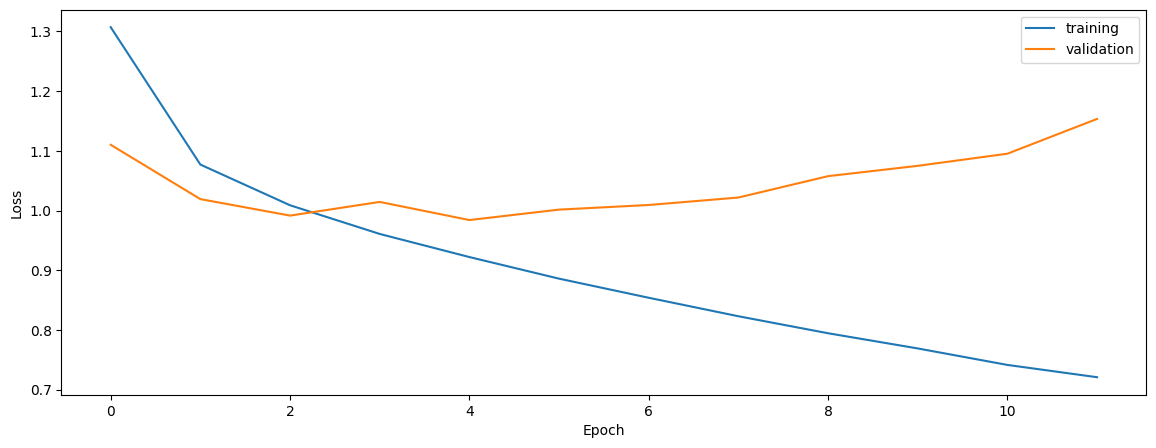

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6529284150307506
0.6126880877742946
0.595930939943545


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5885448637893445
0.5824527459443369
0.5608340168136149


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5807222364547988
0.5753639612936972
0.5610147815483448


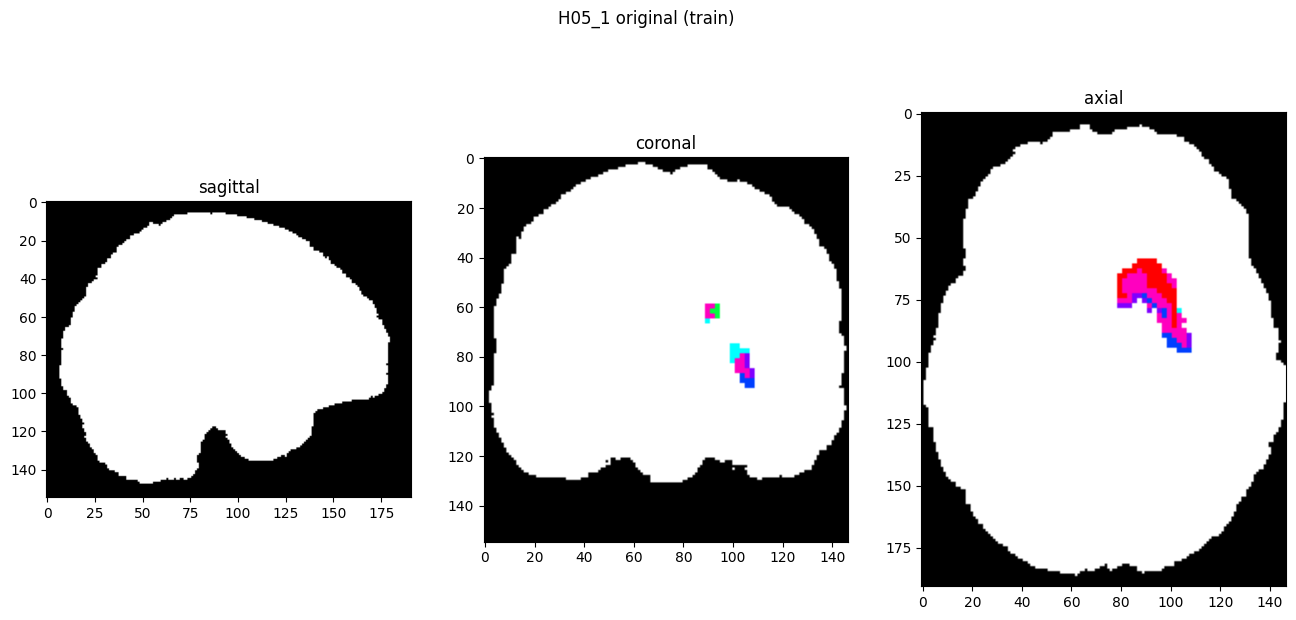

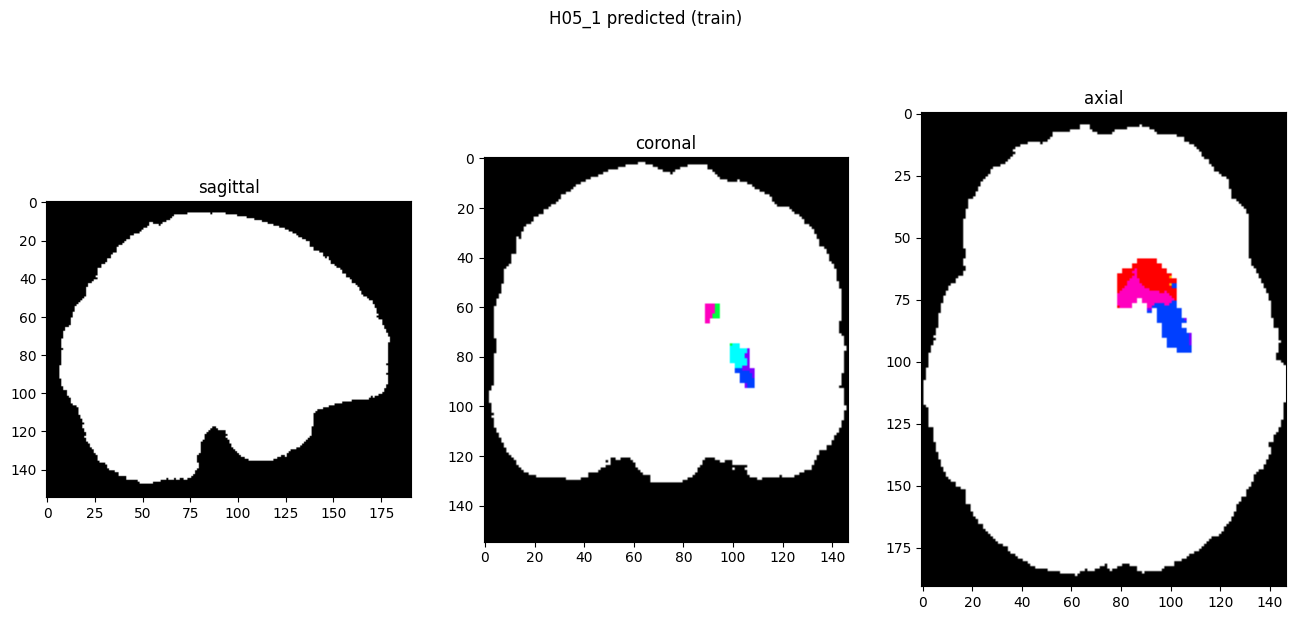

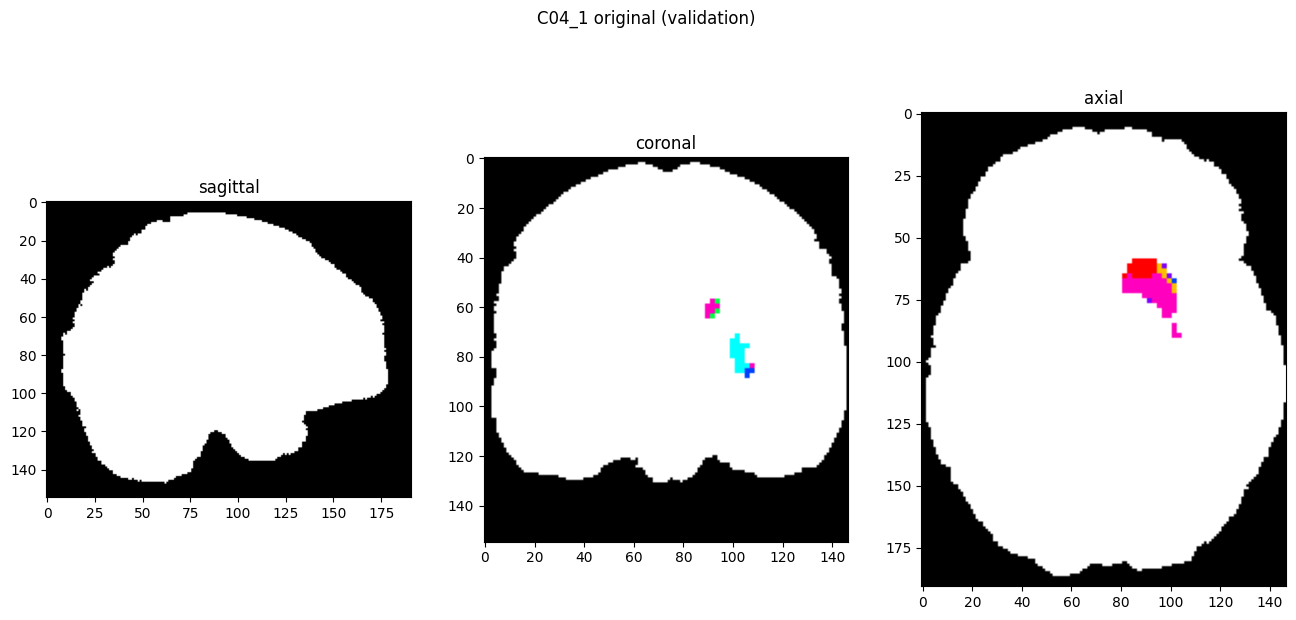

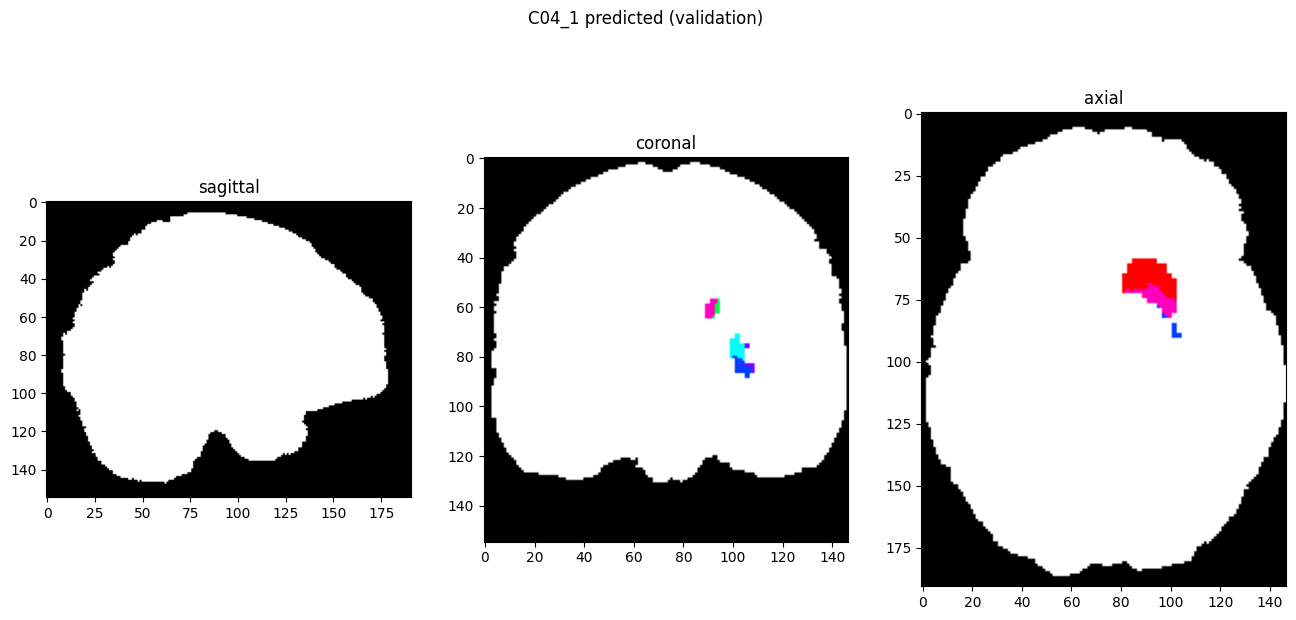

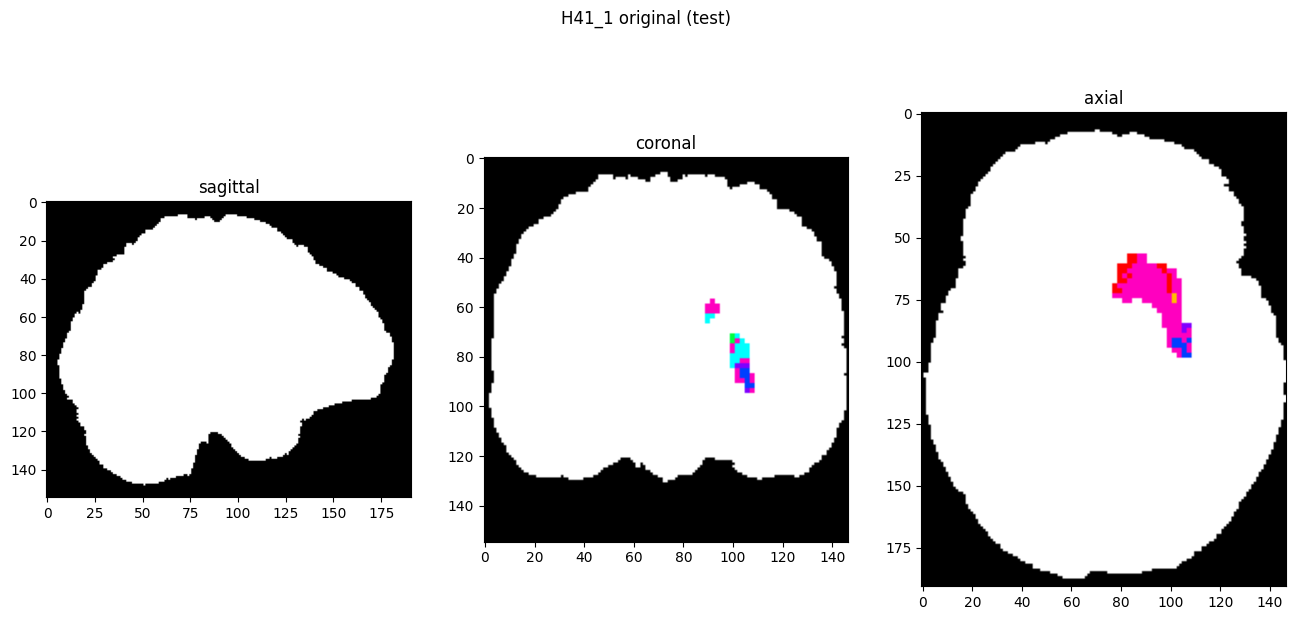

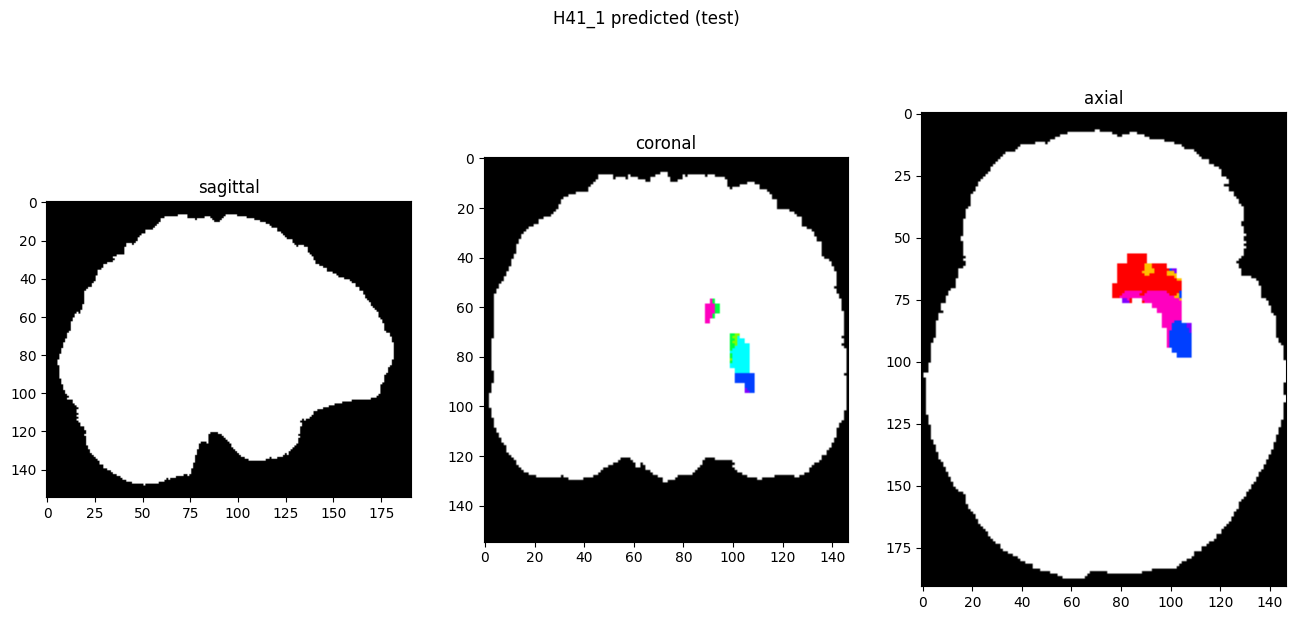

In [10]:
showResults(model, gen, threshold=0)